In [1]:
import clumpsptm
import pandas as pd
import os
import numpy as np
import glob
from tqdm import tqdm
import subprocess
import ast
import matplotlib.pyplot as plt
import sys
from agutil.parallel import parallelize2

sys.path.append("../../funcs")
import plotting as pl

---

__Author__:  Shankara Anand

__Email__: sanand@broadinstitute.org

This notebook walks through how to take a source dataset of PTM sites and map them to PDB structures to eventually use with PTM-CLUMPS. This is necessary pre-processing for a new dataset to map the feature space onto available structures. The CLUMPS-PTM tool repository may be found [here](https://github.com/getzlab/CLUMPS-PTM).

---

In [2]:
# Reference Files
UNIPROT_SWISSPROT = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
SIFTS_DB = "ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/pdb_chain_uniprot.tsv.gz"

# Source Files
CPTAC_REFSEQ_FASTA = "../../data/ref/genomic/RefSeq.20180629_Human_ucsc_hg38_cpdbnr_mito_264contams_553smORFs.fasta"
CPTAC_FEATURE_FILE = "../../data/processed/061721/var_map_full.tsv"
DATA_DIR = "../../data/processed/061721"

# Downloaded Database
PDB_DIR = "../../../getzlab-CLUMPS2/clumps/db/ref/pdbs"

# Output Directory
REF_DIR = "ref_uniprot_072522"
os.makedirs(REF_DIR, exist_ok=True)

## 1. Download Reference Files
---

* We are mapping our source fasta (from CPTAC) to the Uniprot Swissprot annotated database
* We use the Sifts protein database for mapping Uniprot files to annotated PDB protein chains

In [3]:
clumpsptm.mp.dl_ref(REF_DIR, [UNIPROT_SWISSPROT, SIFTS_DB])

## 2. Split Source Fasta
---

* Splits source fasta (from CPTAC) into individual protein sequence fastas for easy paralell processing
* Will select only 5 sequences to use blasting for example purposes

In [4]:
clumpsptm.mp.split_fastas(
    CPTAC_REFSEQ_FASTA,
    os.path.join(REF_DIR, "refseq_fastas")
)

100%|██████████| 42311/42311 [00:03<00:00, 11268.49it/s]


## 2.1 Get Accession Numbers in CPTAC Dataset
---

In [3]:
pmap_df = pd.read_csv(os.path.join(DATA_DIR, "var_map_full.tsv"), sep='\t', index_col=0)
accession_numbers = np.unique(pmap_df['accession_number'].dropna())
print("{} unique accession numbers.".format(accession_numbers.shape[0]))

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


23041 unique accession numbers.


In [4]:
def check_scraped_accession(accession_numbers, verbose=False):
    """
    Check scraped accession numbers.
    """
    scraped_accessions = {}

    for an in accession_numbers:
        if not os.path.isfile(os.path.join(REF_DIR, "refseq_fastas", "{}.seq".format(an))):
            match = glob.glob(os.path.join(REF_DIR, "refseq_fastas", "{}.seq".format(an.split('.')[0])))

            if len(match) > 0:
                scraped_accessions[an] = match[0]
            else:
                if verbose: print("Missing sequences for {}".format(an))
                scraped_accessions[an] = None
        else:
            scraped_accessions[an] = os.path.join(REF_DIR, "refseq_fastas", "{}.seq".format(an))
            
    return scraped_accessions

acc_dict = check_scraped_accession(accession_numbers)
m_an = list(acc_dict.values()).count(None)
print("Found {} / {} CPTAC RefSeq Ids".format(accession_numbers.shape[0]-m_an, accession_numbers.shape[0]))
refseq_seq_files = [x for x in acc_dict.values() if x!=None]

Found 22947 / 23041 CPTAC RefSeq Ids


## 3. Blast Protein Sequences
---

* Use clumps-ptm module to run blastp+ with easy scaling via multi-threading
* For full CPTAC source fasta (~22947 sequences to blast), this requires roughly 1 hr of run-time with an `n1-standard-96` on Google Cloud Compute using `384` threads

In [7]:
%%time

clumpsptm.mp.blast_sequences(
    os.path.join(REF_DIR, "uniprot_sprot.fasta"),
    refseq_seq_files,
    output_dir=REF_DIR,
    n_threads=384,
    db_title="UniprotDB",
    blast_dir_name="refseq_to_uniprot_blast",
    seq_db_name="uniprot_db"
)



Building a new DB, current time: 07/26/2022 00:28:28
New DB name:   /home/sanand/CPTAC_PanCan_2021/clumpsptm_analysis/ref_uniprot_072522/uniprot_db/uniprot_db
New DB title:  UniprotDB
Sequence type: Protein
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 567483 sequences in 15.2056 seconds.

   * Running 22947 blast sequences using 384 threads
CPU times: user 57.3 s, sys: 6min 43s, total: 7min 40s
Wall time: 52min 23s


## 4. Cross-Reference with Sifts Data-Base
---

In [5]:
sifts_df = pd.read_csv(os.path.join(REF_DIR, "pdb_chain_uniprot.tsv"), comment="#", sep='\t')

# Remove files that did not blast
[os.remove(x) for x in glob.glob(os.path.join(REF_DIR, "refseq_to_uniprot_blast/*.seq"))]

blasted_files = glob.glob(os.path.join(REF_DIR, "refseq_to_uniprot_blast/*"))

[]

In [ ]:
mapped_acc_df = clumpsptm.mp.get_blast_hits_with_sifts(blasted_files, sifts_df)
#mapped_acc_df = clumpsptm.mp.get_blast_hits_with_sifts(blasted_files, sifts_df, filter_only_human=True)

  1%|          | 139/22935 [00:05<12:47, 29.69it/s]

In [ ]:
w_sifts = mapped_acc_df[(mapped_acc_df['blast']) & (mapped_acc_df['sifts'])].shape[0]
w_blast = mapped_acc_df[mapped_acc_df['blast']].shape[0]
tot = mapped_acc_df.shape[0]

print(" {} / {} ({:.2f} %) with blast results.".format(w_blast, tot, 100*w_blast/tot))
print(" {} / {} ({:.2f} %) with sifts results.".format(w_sifts, tot, 100*w_sifts/tot))

In [9]:
mapped_acc_df.to_csv(os.path.join(REF_DIR, "mapped_accession_to_sifts.tsv"), sep="\t")

## 5. Filter SIFTS with Downloaded PDBs
---

In [5]:
mapped_acc_df = pd.read_csv(os.path.join(REF_DIR, "mapped_accession_to_sifts.tsv"), sep="\t", index_col=0)
sifts_df = pd.read_csv(os.path.join(REF_DIR, "pdb_chain_uniprot.tsv"), comment="#", sep='\t')

In [7]:
pdbstore = clumpsptm.PdbStore(PDB_DIR)
print(pdbstore)

# Sifts that overlap Uniprots
sifts_filt_df = sifts_df[sifts_df['SP_PRIMARY'].isin(mapped_acc_df['uniprot'])]

PDBStore
   * 112098 PDB files downloaded
   * Directory Path: ../../../getzlab-CLUMPS2/clumps/db/ref/pdbs


In [8]:
def check_missing_pdbs(sifts_filt_df):
    """Check how many PDBs are missing."""
    total_pdbs = len(set(sifts_filt_df['PDB']))
    missing_pdbs = set(sifts_filt_df['PDB']) - pdbstore.downloaded_pdbs

    print("Missing {} / {} ({:.2f} %) PDB files.".format(len(missing_pdbs), total_pdbs, 100*len(missing_pdbs)/total_pdbs))
    return missing_pdbs

In [9]:
missing_pdbs = check_missing_pdbs(sifts_filt_df)

Missing 760 / 59309 (1.28 %) PDB files.


In [14]:
unable_to_download = pdbstore.download_missing_pdbs(missing_pdbs, n_threads=384)

   * Downloading 3809 pdbs using 384 threads
   * Downloaded 3049 / 3809 successfully.


In [11]:
# Drop PDBs unable to be downloaded
sifts_filt_df = sifts_filt_df[sifts_filt_df["PDB"].isin(pdbstore.downloaded_pdbs)]
sifts_filt_df.to_csv(os.path.join(REF_DIR, "pdb_chain_uniprot_filt.tsv"), sep="\t")

## 6. Match PTMs from Source Data-Set to Uniprot-Mapped Proteins
---

In [6]:
ptm_df = pmap_df[pmap_df['feature'].isin(['phosphoproteome','acetylome'])].dropna(1)
ptm_df.head(3)

,id.description,geneSymbol,protein_mw,accession_number,feature,variableSites,sequence,sequenceVML
id,,,,,,,,
NP_001333374.1_S18s_1_1_18_18,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,"['S18s', 'S18s']","['ELLLPNWQGsGSHGLTIAQR', 'ELLLPNWQGsGSHGLTIAQR']","['ELLLPNWQGS(0.99)GS(0.0)HGLT(0.0)IAQR', 'ELLL..."
NP_001333374.1_S41s_1_1_41_41,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,"['S41s', 'S41s']","['DDGVFVQEVTQNsPAAR', 'DDGVFVQEVTQNsPAAR']","['DDGVFVQEVT(0.0)QNS(0.99)PAAR', 'DDGVFVQEVT(0..."
NP_001333374.1_S93s_1_1_93_93,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,"['S93s', 'S93s', 'S93s', 'S93s']","['GDRsPEPGQTWTR', 'KGDRsPEPGQTWTR', 'KGDRsPEPG...","['GDRS(0.99)PEPGQT(0.0)WT(0.0)R', 'KGDRS(0.99)..."


In [7]:
def grab_ptm_site(x):
    """Grab actual PTM site."""
    res = list()
    
    for s in x.split(" "):
        if s.startswith(("K","Y","S","T")):
            res.append(s)
        else:
            pass
        
    if len(res) == 1:
        return res[0]
    else:
        return res

# Expand PTMs in Each Feature
ptm_df['variableSites'] = ptm_df['variableSites'].apply(ast.literal_eval)
ptm_df = ptm_df.explode('variableSites').drop_duplicates()

# Proteins with single PTM sites
ptm_sing_df = ptm_df.loc[ptm_df.index.map(lambda x: x.split("_")[-3]=="1" and x.split("_")[-4]=="1")]
ptm_sing_df.loc[:,"ptmSite"] = ptm_sing_df['variableSites'].apply(grab_ptm_site)

# Proteins with multiple PTM sites
ptm_multi_df = pd.concat((
    ptm_df.loc[ptm_df.index.map(lambda x: x.split("_")[-3]=="3" and x.split("_")[-4]=="3")],
    ptm_df.loc[ptm_df.index.map(lambda x: x.split("_")[-3]=="2" and x.split("_")[-4]=="2")]
))

ptm_multi_df.loc[:,"ptmSite"] = ptm_multi_df['variableSites'].apply(grab_ptm_site)
ptm_multi_df = ptm_multi_df.explode("ptmSite")

# Combine & intersect accession numbers
ptm_comb_df = pd.concat((ptm_sing_df, ptm_multi_df))
ptm_comb_df = ptm_comb_df[ptm_comb_df["accession_number"].isin(mapped_acc_df.index)]

# Join PTM features from source data-set to mapped accession-numbers
ptm_comb_df = pd.merge(
    ptm_comb_df.reset_index(), 
    mapped_acc_df.reset_index().rename(columns={"query":"accession_number"}),
    how="left",
    on="accession_number"
).set_index("id")

ptm_comb_df["acc_res"] = ptm_comb_df["ptmSite"].apply(lambda x: x[0])
ptm_comb_df["acc_res_i"] = ptm_comb_df["ptmSite"].apply(lambda x: int(x[1:-1]))

print("  * {} single PTM sites total in CPTAC dataset".format(ptm_sing_df.shape[0]))
print("  * {} multi PTM sites total in CPTAC dataset".format(ptm_multi_df.shape[0]))

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


  * 133619 single PTM sites total in CPTAC dataset
  * 41394 multi PTM sites total in CPTAC dataset


In [8]:
# Filter
ptm_comb_filt_df = ptm_comb_df[ptm_comb_df['Hsp_query-from'].notna()].copy()
ptm_comb_filt_df['Hsp_query-from'] = ptm_comb_filt_df['Hsp_query-from'].astype(int)
ptm_comb_filt_df['Hsp_hit-from'] = ptm_comb_filt_df['Hsp_hit-from'].astype(int)

def get_source_blast_idx(row):
    """
    Get source blast index.
    """
    d = dict()
    c = row['Hsp_query-from']

    for idx,res in enumerate(row['Hsp_qseq']):
        if res is not '-':
            d[c] = idx
            c = c+1
    
    if row['acc_res_i'] not in d.keys():
        return "X"
    else:
        return d[row['acc_res_i']]

def get_uniprot_blast_i(row):
    """
    Get Uniprot Mapped Residue ID.
    """
    d = dict()
    c = row['Hsp_hit-from']

    for idx,res in enumerate(row['Hsp_hseq']):
        if res is not '-':
            d[idx] = c
            c = c+1

    if row['acc_res_idx'] not in d.keys():
        return "X"
    else:
        return d[row['acc_res_idx']]

def _get_qres(row):
    """Get query residue"""
    try:
        return row["Hsp_qseq"][row["acc_res_idx"]]
    except:
        return None

def _get_hres(row):
    """Get query residue"""
    try:
        return row["Hsp_hseq"][row["acc_res_idx"]]
    except:
        return None

ptm_comb_filt_df["acc_res_idx"] = ptm_comb_filt_df.apply(get_source_blast_idx, 1)
ptm_comb_filt_df["acc_res"] = ptm_comb_filt_df.apply(_get_qres, 1)

# Get Uniprot Matches
ptm_comb_filt_df["uniprot_res"] = ptm_comb_filt_df.apply(_get_hres, 1)
ptm_comb_filt_df["uniprot_res_i"] = ptm_comb_filt_df.apply(get_uniprot_blast_i, 1)
ptm_comb_filt_df['uniprot_match'] = ptm_comb_filt_df['acc_res']==ptm_comb_filt_df['uniprot_res']

No handles with labels found to put in legend.


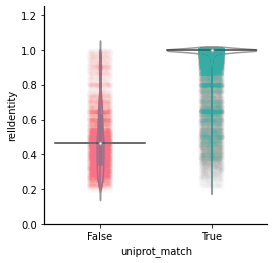

In [9]:
_ = pl.plot_strip(
    ptm_comb_filt_df[ptm_comb_filt_df['acc_res'].notna()][["relIdentity"]].T, 
    ptm_comb_filt_df[ptm_comb_filt_df['acc_res'].notna()]['uniprot_match'], yax="relIdentity",
    alpha=0.005,
    ylim=(0,1.25),
    figsize=(4,4),
    format_fig=True
)

## 7. Align Source PTMs to PDB Residues via SIFTS
---
* Extract information from each PDB structure header.
* Ran with `n1-standard-96` and compute time of ~ 6 hrs.

In [17]:
sifts_filt_df['PDB_BEG'] = sifts_filt_df['PDB_BEG'].apply(lambda x: 0 if x=="None" else x)
sifts_filt_df['len'] = sifts_filt_df['RES_END'] - sifts_filt_df['RES_BEG']
sifts_drop_dup = sifts_filt_df.drop_duplicates(subset=['PDB','len'])

ptm_comb_filt2_df = ptm_comb_filt_df[ptm_comb_filt_df["uniprot_match"]].copy()

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
def get_pdb_headers(sifts_df, pdbstore):
    """Get PDB headers.""" 
    
    pdb_chain_unis = [x for x in zip(sifts_df['PDB'], sifts_df['CHAIN'], sifts_df['SP_PRIMARY'])]
    print("   * Grabbing header info for {} pdb-chains".format(len(pdb_chain_unis)))
    headers = list()
    
    def get_header_info(pdb_ch_uni):
        """Download pdb."""
        pdb_headers = dict()
        
        try:
            pdb, chain, uniprot = pdb_ch_uni
            hd = pdbstore.load_header(pdb)

            for polymer in hd['polymers']:
                pdb_headers[polymer] = dict()
                if polymer.chid == chain:
                    for dbref in polymer.dbrefs:
                        pdb_headers[polymer]["PDB"] = pdb
                        pdb_headers[polymer]["CHAIN"] = chain
                        pdb_headers[polymer]["db_ref"] = dbref.database
                        pdb_headers[polymer]["db_accession"] = dbref.accession
                        pdb_headers[polymer]["db_first_from"] = dbref.first[0]
                        pdb_headers[polymer]["db_first_to"] = dbref.first[2]

                        if dbref.accession == uniprot:
                            continue

            headers.append(pd.DataFrame.from_dict(pdb_headers).dropna(1))
        except:
            print("  * Error for {}".format(pdb_ch_uni))
    
    for pdb_chain_uni in tqdm(pdb_chain_unis):
        get_header_info(pdb_chain_uni)
        
    return headers

pdb_headers = pd.concat(get_pdb_headers(sifts_drop_dup, pdbstore),1).T
pdb_headers.to_csv(os.path.join(REF_DIR, "pdb_headers.txt"), sep='\t')

  0%|          | 16/83655 [00:00<08:54, 156.34it/s]

   * Grabbing header info for 83655 pdb-chains


  9%|▉         | 7414/83655 [01:17<14:30, 87.56it/s]  

  * Error for ('1wo6', 'A', 'Q92793')


 26%|██▌       | 21895/83655 [04:29<17:28, 58.88it/s]  

  * Error for ('3j7o', 'T', 'P49666')
  * Error for ('3j7o', 'U', 'P67985')
  * Error for ('3j7o', 'V', 'P62831')
  * Error for ('3j7o', 'Z', 'A1XQU5')
  * Error for ('3j7o', 'd', 'P62901')
  * Error for ('3j7o', 'e', 'Q6QAT0')
  * Error for ('3j7o', 'g', 'Q29223')
  * Error for ('3j7o', 'o', 'P83884')
  * Error for ('3j7p', 'SD', 'Q0Z8U2')
  * Error for ('3j7p', 'SP', 'P62844')
  * Error for ('3j7p', 'SQ', 'Q29201')
  * Error for ('3j7p', 'SS', 'P62272')
  * Error for ('3j7p', 'SV', 'P63221')
  * Error for ('3j7p', 'Sa', 'P49171')
  * Error for ('3j7p', 'Sc', 'Q6QAT1')
  * Error for ('3j7p', 'Sg', 'P63246')
  * Error for ('3j7p', 'T', 'P49666')
  * Error for ('3j7p', 'U', 'P67985')
  * Error for ('3j7p', 'V', 'P62831')
  * Error for ('3j7p', 'Z', 'A1XQU5')
  * Error for ('3j7p', 'd', 'P62901')
  * Error for ('3j7p', 'e', 'Q6QAT0')
  * Error for ('3j7p', 'g', 'Q29223')
  * Error for ('3j7p', 'o', 'P83884')
  * Error for ('3j7q', 'T', 'P49666')
  * Error for ('3j7q', 'U', 'P67985')
  * 

 26%|██▋       | 21966/83655 [04:36<47:56, 21.44it/s]  

  * Error for ('3j8h', 'B', 'P62943')
  * Error for ('3j92', '0', 'O94822')
  * Error for ('3j92', 'u', 'O60524')


 26%|██▋       | 22052/83655 [04:37<28:02, 36.61it/s]

  * Error for ('3j9m', '0', 'Q9BYC8')
  * Error for ('3j9m', '1', 'O75394')
  * Error for ('3j9m', '2', 'Q9BQ48')
  * Error for ('3j9m', '5', 'Q9BZE1')
  * Error for ('3j9m', '6', 'Q96DV4')
  * Error for ('3j9m', '7', 'Q9NYK5')
  * Error for ('3j9m', '8', 'Q9NQ50')
  * Error for ('3j9m', '9', 'Q8IXM3')
  * Error for ('3j9m', 'A0', 'P82930')
  * Error for ('3j9m', 'A1', 'P82673')
  * Error for ('3j9m', 'A2', 'Q96BP2')
  * Error for ('3j9m', 'A3', 'Q9NWT8')
  * Error for ('3j9m', 'A4', 'Q96EY7')
  * Error for ('3j9m', 'AB', 'Q9Y399')
  * Error for ('3j9m', 'AC', 'Q96EL2')
  * Error for ('3j9m', 'AD', 'P82675')
  * Error for ('3j9m', 'AE', 'P82932')
  * Error for ('3j9m', 'AF', 'Q9Y2R9')
  * Error for ('3j9m', 'AG', 'P82933')
  * Error for ('3j9m', 'AH', 'P82664')
  * Error for ('3j9m', 'AI', 'P82912')
  * Error for ('3j9m', 'AJ', 'O15235')
  * Error for ('3j9m', 'AK', 'O60783')
  * Error for ('3j9m', 'AL', 'P82914')
  * Error for ('3j9m', 'AN', 'Q9Y2R5')
  * Error for ('3j9m', 'AO', 'Q9Y

 26%|██▋       | 22073/83655 [04:37<32:50, 31.25it/s]

  * Error for ('3jc1', 'Aa', 'P53990')
  * Error for ('3jc1', 'Ab', 'Q7LBR1')


 26%|██▋       | 22118/83655 [04:38<20:42, 49.53it/s]

  * Error for ('3jct', 'q', 'Q12080')
  * Error for ('3jct', 'r', 'P40078')
  * Error for ('3jct', 's', 'P40010')
  * Error for ('3jct', 'v', 'P36160')
  * Error for ('3jct', 'w', 'Q08746')


 43%|████▎     | 35943/83655 [07:28<07:16, 109.23it/s] 

  * Error for ('4ug0', 'LB', 'P39023')
  * Error for ('4ug0', 'LC', 'P36578')
  * Error for ('4ug0', 'LD', 'P46777')
  * Error for ('4ug0', 'LE', 'Q02878')
  * Error for ('4ug0', 'LF', 'P18124')
  * Error for ('4ug0', 'LG', 'P62424')
  * Error for ('4ug0', 'LH', 'P32969')
  * Error for ('4ug0', 'LI', 'Q96L21')
  * Error for ('4ug0', 'LL', 'P26373')
  * Error for ('4ug0', 'LM', 'P50914')
  * Error for ('4ug0', 'LO', 'P40429')
  * Error for ('4ug0', 'LP', 'P18621')
  * Error for ('4ug0', 'LQ', 'Q07020')
  * Error for ('4ug0', 'LS', 'Q02543')
  * Error for ('4ug0', 'LU', 'P35268')
  * Error for ('4ug0', 'La', 'P46776')
  * Error for ('4ug0', 'Lb', 'P47914')
  * Error for ('4ug0', 'Lf', 'P18077')
  * Error for ('4ug0', 'Lh', 'P42766')
  * Error for ('4ug0', 'Li', 'Q9Y3U8')
  * Error for ('4ug0', 'Lk', 'P63173')
  * Error for ('4ug0', 'Lr', 'P46779')
  * Error for ('4ug0', 'Lz', 'P62906')
  * Error for ('4ug0', 'SA', 'P08865')
  * Error for ('4ug0', 'SB', 'P61247')
  * Error for ('4ug0', 'S

 43%|████▎     | 36289/83655 [07:34<07:07, 110.81it/s]

  * Error for ('4v46', 'A0', 'Q9Y275')
  * Error for ('4v46', 'B0', 'Q96RJ3')
  * Error for ('4v6m', 'A0', 'P02647')
  * Error for ('4v6w', 'Cq', 'P05388')
  * Error for ('4v6x', 'AA', 'P08865')
  * Error for ('4v6x', 'AB', 'P61247')
  * Error for ('4v6x', 'AC', 'P15880')
  * Error for ('4v6x', 'AF', 'P46782')
  * Error for ('4v6x', 'AK', 'P46783')
  * Error for ('4v6x', 'AR', 'P08708')
  * Error for ('4v6x', 'AT', 'P39019')
  * Error for ('4v6x', 'Ae', 'P62861')
  * Error for ('4v6x', 'Af', 'P62979')
  * Error for ('4v6x', 'Ah', 'Q8NC51')
  * Error for ('4v6x', 'Az', 'P13639')
  * Error for ('4v6x', 'CB', 'P39023')
  * Error for ('4v6x', 'CC', 'P36578')
  * Error for ('4v6x', 'CD', 'P46777')
  * Error for ('4v6x', 'CE', 'Q02878')
  * Error for ('4v6x', 'CF', 'P18124')
  * Error for ('4v6x', 'CG', 'P62424')
  * Error for ('4v6x', 'CH', 'P32969')
  * Error for ('4v6x', 'CI', 'Q96L21')
  * Error for ('4v6x', 'CL', 'P26373')
  * Error for ('4v6x', 'CM', 'P50914')
  * Error for ('4v6x', 'C

 44%|████▎     | 36579/83655 [07:38<07:14, 108.38it/s]

  * Error for ('4wsn', 'A', 'Q13098')
  * Error for ('4wsn', 'B', 'P61201')
  * Error for ('4wsn', 'C', 'Q9UNS2')
  * Error for ('4wsn', 'D', 'Q9BT78')
  * Error for ('4wsn', 'E', 'Q92905')
  * Error for ('4wsn', 'F', 'Q7L5N1')
  * Error for ('4wsn', 'G', 'Q9UBW8')
  * Error for ('4wsn', 'H', 'Q99627')


 44%|████▍     | 36669/83655 [07:39<08:09, 95.99it/s] 

  * Error for ('4wzj', 'A', 'P62318')
  * Error for ('4wzj', 'B', 'P14678')


 46%|████▌     | 38319/83655 [08:12<07:47, 96.92it/s]  

  * Error for ('5aj0', 'AB', 'P39023')
  * Error for ('5aj0', 'AC', 'P36578')
  * Error for ('5aj0', 'AD', 'P46777')
  * Error for ('5aj0', 'AE', 'Q02878')
  * Error for ('5aj0', 'AF', 'P18124')
  * Error for ('5aj0', 'AG', 'P62424')
  * Error for ('5aj0', 'AH', 'P32969')
  * Error for ('5aj0', 'AI', 'P27635')
  * Error for ('5aj0', 'AK', 'P05388')
  * Error for ('5aj0', 'AL', 'P26373')
  * Error for ('5aj0', 'AM', 'P50914')
  * Error for ('5aj0', 'AO', 'P40429')
  * Error for ('5aj0', 'AP', 'P18621')
  * Error for ('5aj0', 'AQ', 'Q07020')
  * Error for ('5aj0', 'AS', 'Q02543')
  * Error for ('5aj0', 'AU', 'P35268')
  * Error for ('5aj0', 'Aa', 'P46776')
  * Error for ('5aj0', 'Ab', 'P47914')
  * Error for ('5aj0', 'Af', 'P18077')
  * Error for ('5aj0', 'Ah', 'P42766')
  * Error for ('5aj0', 'Ai', 'Q9Y3U8')
  * Error for ('5aj0', 'Ak', 'P63173')
  * Error for ('5aj0', 'Aq', 'P30050')
  * Error for ('5aj0', 'At', 'P46779')
  * Error for ('5aj0', 'Au', 'P62906')
  * Error for ('5aj0', 'B

 49%|████▊     | 40755/83655 [08:43<17:59, 39.73it/s] 

  * Error for ('5fl8', 'r', 'P53313')
  * Error for ('5fl8', 's', 'Q12019')
  * Error for ('5fl8', 's', 'Q12019')
  * Error for ('5fl8', 's', 'Q12019')
  * Error for ('5fl8', 's', 'Q12019')


 49%|████▉     | 41240/83655 [09:00<1:26:33,  8.17it/s]

  * Error for ('5gjr', '0', 'P17980')
  * Error for ('5gjr', '1', 'Q99460')
  * Error for ('5gjr', '2', 'Q9UNM6')
  * Error for ('5gjr', '3', 'O00232')
  * Error for ('5gjr', '5', 'Q15008')
  * Error for ('5gjr', '6', 'O43242')
  * Error for ('5gjr', '7', 'P48556')
  * Error for ('5gjr', '8', 'P51665')
  * Error for ('5gjr', '9', 'O00487')
  * Error for ('5gjr', 'AA', 'P55036')
  * Error for ('5gjr', 'AB', 'P60896')
  * Error for ('5gjr', 'AC', 'Q13200')
  * Error for ('5gjr', 'C', 'P25787')
  * Error for ('5gjr', 'D', 'P25789')
  * Error for ('5gjr', 'E', 'O14818')
  * Error for ('5gjr', 'G', 'P25786')
  * Error for ('5gjr', 'H', 'P35998')
  * Error for ('5gjr', 'K', 'P43686')
  * Error for ('5gjr', 'X', 'P25788')
  * Error for ('5gjr', 'a', 'P28072')
  * Error for ('5gjr', 'b', 'Q99436')
  * Error for ('5gjr', 'c', 'P49720')
  * Error for ('5gjr', 'd', 'P49721')
  * Error for ('5gjr', 'f', 'P20618')
  * Error for ('5gjr', 'g', 'P28070')


 49%|████▉     | 41249/83655 [09:00<1:04:31, 10.95it/s]

  * Error for ('5gky', 'B', 'P62943')
  * Error for ('5gkz', 'B', 'P62943')
  * Error for ('5gl0', 'B', 'P62943')
  * Error for ('5gl1', 'B', 'P62943')
  * Error for ('5gm6', 'O', 'Q12417')


 49%|████▉     | 41331/83655 [09:01<14:08, 49.85it/s]  

  * Error for ('5gpn', '7', 'P07470')


 51%|█████     | 42681/83655 [31:37<07:58, 85.63it/s]      

  * Error for ('5jcs', 'r', 'P53313')
  * Error for ('5jcs', 's', 'Q12019')


 52%|█████▏    | 43537/83655 [31:50<08:08, 82.18it/s] 

  * Error for ('5l1d', 'B', 'P68106')


 52%|█████▏    | 43596/83655 [31:51<07:24, 90.14it/s]

  * Error for ('5l4g', '1', 'P20618')
  * Error for ('5l4g', '2', 'P49721')
  * Error for ('5l4g', '3', 'P49720')
  * Error for ('5l4g', '4', 'P28070')
  * Error for ('5l4g', '5', 'P28074')
  * Error for ('5l4g', '6', 'P28072')
  * Error for ('5l4g', '7', 'Q99436')
  * Error for ('5l4g', 'B', 'P25787')
  * Error for ('5l4g', 'C', 'P25789')
  * Error for ('5l4g', 'D', 'O14818')
  * Error for ('5l4g', 'G', 'P25788')
  * Error for ('5l4g', 'H', 'P35998')
  * Error for ('5l4g', 'K', 'P43686')
  * Error for ('5l4g', 'L', 'P62333')
  * Error for ('5l4g', 'M', 'P17980')


 53%|█████▎    | 44103/83655 [32:24<16:30, 39.95it/s]  

  * Error for ('5lks', 'LB', 'P39023')
  * Error for ('5lks', 'LC', 'P36578')
  * Error for ('5lks', 'LD', 'P46777')
  * Error for ('5lks', 'LE', 'Q02878')
  * Error for ('5lks', 'LF', 'P18124')
  * Error for ('5lks', 'LG', 'P62424')
  * Error for ('5lks', 'LH', 'P32969')
  * Error for ('5lks', 'LI', 'Q96L21')
  * Error for ('5lks', 'LL', 'P26373')
  * Error for ('5lks', 'LM', 'P50914')
  * Error for ('5lks', 'LO', 'P40429')
  * Error for ('5lks', 'LP', 'P18621')
  * Error for ('5lks', 'LQ', 'Q07020')
  * Error for ('5lks', 'LS', 'Q02543')
  * Error for ('5lks', 'LU', 'P35268')
  * Error for ('5lks', 'La', 'P46776')
  * Error for ('5lks', 'Lf', 'P18077')
  * Error for ('5lks', 'Lh', 'P42766')
  * Error for ('5lks', 'Li', 'Q9Y3U8')
  * Error for ('5lks', 'Lk', 'P63173')
  * Error for ('5lks', 'Lr', 'P46779')
  * Error for ('5lks', 'Lz', 'P62906')
  * Error for ('5lks', 'SA', 'P08865')
  * Error for ('5lks', 'SB', 'P61247')
  * Error for ('5lks', 'SC', 'P15880')
  * Error for ('5lks', 'S

 53%|█████▎    | 44436/83655 [32:31<06:58, 93.70it/s]

  * Error for ('5lzs', 'jj', 'P68105')
  * Error for ('5lzw', 'ii', 'Q9BRX2')
  * Error for ('5lzw', 'jj', 'Q9Y450')
  * Error for ('5lzx', 'ii', 'Q9BRX2')
  * Error for ('5lzx', 'jj', 'Q9Y450')
  * Error for ('5lzy', 'ii', 'Q9BRX2')
  * Error for ('5lzy', 'jj', 'Q9Y450')
  * Error for ('5lzz', 'ii', 'Q9BRX2')
  * Error for ('5lzz', 'jj', 'Q9Y450')


 54%|█████▍    | 44988/83655 [32:51<10:15, 62.85it/s]  

  * Error for ('5mx7', 'B1', 'Q15788')


 54%|█████▍    | 45367/83655 [32:56<09:00, 70.82it/s]

  * Error for ('5nmb', 'B2', 'Q15788')


 54%|█████▍    | 45456/83655 [32:57<07:35, 83.91it/s]

  * Error for ('5nrl', 'H', 'P20053')


 58%|█████▊    | 48668/83655 [34:01<04:04, 142.81it/s] 

  * Error for ('5rxw', 'A', 'Q92835')


 59%|█████▊    | 49049/83655 [34:06<05:42, 101.05it/s]

  * Error for ('5t0c', 'AA', 'P35998')
  * Error for ('5t0c', 'AD', 'P43686')
  * Error for ('5t0c', 'AE', 'P62333')
  * Error for ('5t0c', 'AF', 'P17980')
  * Error for ('5t0c', 'AH', 'P25787')
  * Error for ('5t0c', 'AI', 'P25789')
  * Error for ('5t0c', 'AJ', 'O14818')
  * Error for ('5t0c', 'AL', 'P25786')
  * Error for ('5t0c', 'AM', 'P25788')
  * Error for ('5t0c', 'AN', 'P28072')
  * Error for ('5t0c', 'AO', 'Q99436')
  * Error for ('5t0c', 'AP', 'P49720')
  * Error for ('5t0c', 'AQ', 'P49721')
  * Error for ('5t0c', 'AS', 'P20618')
  * Error for ('5t0c', 'AT', 'P28070')
  * Error for ('5t0c', 'AU', 'Q99460')
  * Error for ('5t0c', 'AV', 'O43242')
  * Error for ('5t0c', 'AW', 'O00232')
  * Error for ('5t0c', 'AZ', 'P51665')
  * Error for ('5t0c', 'Aa', 'Q9UNM6')
  * Error for ('5t0c', 'Ab', 'P55036')
  * Error for ('5t0c', 'Ac', 'O00487')
  * Error for ('5t0c', 'Ad', 'P48556')
  * Error for ('5t0c', 'Ae', 'P60896')
  * Error for ('5t0c', 'Af', 'Q13200')


 59%|█████▉    | 49199/83655 [34:35<1:21:52,  7.01it/s]

  * Error for ('5t15', 'A', 'P68106')
  * Error for ('5t2c', 'AH', 'P62979')
  * Error for ('5t2c', 'AJ', 'P15880')
  * Error for ('5t2c', 'AT', 'P62861')
  * Error for ('5t2c', 'AU', 'P39019')
  * Error for ('5t2c', 'Ao', 'P08865')
  * Error for ('5t2c', 'Ap', 'P61247')
  * Error for ('5t2c', 'As', 'P46782')
  * Error for ('5t2c', 'Av', 'P46783')
  * Error for ('5t2c', 'Az', 'P08708')
  * Error for ('5t2c', 'E', 'P39023')
  * Error for ('5t2c', 'F', 'P36578')
  * Error for ('5t2c', 'G', 'P46777')
  * Error for ('5t2c', 'H', 'Q02878')
  * Error for ('5t2c', 'I', 'P40429')
  * Error for ('5t2c', 'J', 'P18621')
  * Error for ('5t2c', 'K', 'Q07020')
  * Error for ('5t2c', 'M', 'Q02543')
  * Error for ('5t2c', 'O', 'P35268')
  * Error for ('5t2c', 'U', 'P46776')
  * Error for ('5t2c', 'V', 'P47914')
  * Error for ('5t2c', 'Z', 'P18077')
  * Error for ('5t2c', 'b', 'P42766')
  * Error for ('5t2c', 'c', 'Q9Y3U8')
  * Error for ('5t2c', 'e', 'P63173')
  * Error for ('5t2c', 'k', 'P46779')
  *

 59%|█████▉    | 49354/83655 [34:36<08:35, 66.50it/s]  

  * Error for ('5t9m', 'A', 'P68106')
  * Error for ('5t9n', 'A', 'P68106')
  * Error for ('5t9r', 'A', 'P68106')
  * Error for ('5t9s', 'A', 'P68106')
  * Error for ('5t9v', 'A', 'P68106')
  * Error for ('5ta3', 'A', 'P68106')
  * Error for ('5tal', 'A', 'P68106')
  * Error for ('5tam', 'A', 'P68106')
  * Error for ('5tan', 'A', 'P68106')
  * Error for ('5tap', 'A', 'P68106')
  * Error for ('5taq', 'A', 'P68106')
  * Error for ('5tas', 'A', 'P68106')
  * Error for ('5tat', 'A', 'P68106')
  * Error for ('5tau', 'A', 'P68106')
  * Error for ('5tav', 'A', 'P68106')
  * Error for ('5taw', 'A', 'P68106')
  * Error for ('5tax', 'A', 'P68106')
  * Error for ('5tay', 'A', 'P68106')
  * Error for ('5taz', 'A', 'P68106')
  * Error for ('5tb0', 'A', 'P68106')
  * Error for ('5tb1', 'A', 'P68106')
  * Error for ('5tb2', 'A', 'P68106')
  * Error for ('5tb3', 'A', 'P68106')
  * Error for ('5tb4', 'A', 'P68106')


 60%|█████▉    | 50129/83655 [34:46<08:01, 69.63it/s] 

  * Error for ('5uot', '0', 'P20592')


 60%|██████    | 50601/83655 [34:53<21:41, 25.40it/s]

  * Error for ('5vfp', 'A', 'P35998')
  * Error for ('5vfp', 'D', 'P43686')
  * Error for ('5vfp', 'E', 'P62333')
  * Error for ('5vfp', 'F', 'P17980')
  * Error for ('5vfp', 'H', 'P25787')
  * Error for ('5vfp', 'I', 'P25789')
  * Error for ('5vfp', 'J', 'O14818')
  * Error for ('5vfp', 'L', 'P25786')
  * Error for ('5vfp', 'M', 'P25788')
  * Error for ('5vfp', 'N', 'P28072')
  * Error for ('5vfp', 'O', 'Q99436')
  * Error for ('5vfp', 'P', 'P49720')
  * Error for ('5vfp', 'Q', 'P49721')
  * Error for ('5vfp', 'R', 'P28074')
  * Error for ('5vfp', 'S', 'P20618')
  * Error for ('5vfp', 'T', 'P28070')
  * Error for ('5vfp', 'U', 'Q99460')
  * Error for ('5vfp', 'V', 'O43242')
  * Error for ('5vfp', 'W', 'O00232')
  * Error for ('5vfp', 'Y', 'Q15008')
  * Error for ('5vfp', 'Z', 'P51665')
  * Error for ('5vfp', 'a', 'Q9UNM6')
  * Error for ('5vfp', 'c', 'O00487')
  * Error for ('5vfp', 'd', 'P48556')
  * Error for ('5vfp', 'f', 'Q13200')
  * Error for ('5vfq', 'A', 'P35998')
  * Error fo

 61%|██████    | 50652/83655 [34:57<48:31, 11.33it/s]  

  * Error for ('5vfs', 'A', 'P35998')
  * Error for ('5vfs', 'D', 'P43686')
  * Error for ('5vfs', 'E', 'P62333')
  * Error for ('5vfs', 'F', 'P17980')
  * Error for ('5vfs', 'H', 'P25787')
  * Error for ('5vfs', 'I', 'P25789')
  * Error for ('5vfs', 'J', 'O14818')
  * Error for ('5vfs', 'L', 'P25786')
  * Error for ('5vfs', 'M', 'P25788')
  * Error for ('5vfs', 'N', 'P28072')
  * Error for ('5vfs', 'O', 'Q99436')
  * Error for ('5vfs', 'P', 'P49720')
  * Error for ('5vfs', 'Q', 'P49721')
  * Error for ('5vfs', 'R', 'P28074')
  * Error for ('5vfs', 'S', 'P20618')
  * Error for ('5vfs', 'T', 'P28070')
  * Error for ('5vfs', 'U', 'Q99460')
  * Error for ('5vfs', 'V', 'O43242')
  * Error for ('5vfs', 'W', 'O00232')
  * Error for ('5vfs', 'Y', 'Q15008')
  * Error for ('5vfs', 'Z', 'P51665')
  * Error for ('5vfs', 'a', 'Q9UNM6')
  * Error for ('5vfs', 'c', 'O00487')
  * Error for ('5vfs', 'd', 'P48556')
  * Error for ('5vfs', 'f', 'Q13200')


 61%|██████    | 50712/83655 [35:01<53:09, 10.33it/s]  

  * Error for ('5vfu', 'A', 'P35998')
  * Error for ('5vfu', 'D', 'P43686')
  * Error for ('5vfu', 'E', 'P62333')
  * Error for ('5vfu', 'F', 'P17980')
  * Error for ('5vfu', 'H', 'P25787')
  * Error for ('5vfu', 'I', 'P25789')
  * Error for ('5vfu', 'J', 'O14818')
  * Error for ('5vfu', 'L', 'P25786')
  * Error for ('5vfu', 'M', 'P25788')
  * Error for ('5vfu', 'N', 'P28072')
  * Error for ('5vfu', 'O', 'Q99436')
  * Error for ('5vfu', 'P', 'P49720')
  * Error for ('5vfu', 'Q', 'P49721')
  * Error for ('5vfu', 'R', 'P28074')
  * Error for ('5vfu', 'S', 'P20618')
  * Error for ('5vfu', 'T', 'P28070')
  * Error for ('5vfu', 'U', 'Q99460')
  * Error for ('5vfu', 'V', 'O43242')
  * Error for ('5vfu', 'W', 'O00232')
  * Error for ('5vfu', 'Y', 'Q15008')
  * Error for ('5vfu', 'Z', 'P51665')
  * Error for ('5vfu', 'a', 'Q9UNM6')
  * Error for ('5vfu', 'c', 'O00487')
  * Error for ('5vfu', 'd', 'P48556')
  * Error for ('5vfu', 'f', 'Q13200')


 61%|██████    | 51098/83655 [35:14<04:54, 110.66it/s] 

  * Error for ('5vyc', 'A1', 'P08865')
  * Error for ('5vyc', 'B1', 'P61247')
  * Error for ('5vyc', 'C1', 'P15880')
  * Error for ('5vyc', 'F1', 'P46782')
  * Error for ('5vyc', 'K1', 'P46783')
  * Error for ('5vyc', 'R1', 'P08708')
  * Error for ('5vyc', 'T1', 'P39019')
  * Error for ('5vyc', 'k1', 'Q9ULC4')
  * Error for ('5vyc', 'l1', 'O43583')


 62%|██████▏   | 51449/83655 [35:19<06:07, 87.62it/s] 

  * Error for ('5wlc', 'SC', 'P15646')
  * Error for ('5wlc', 'SN', 'P36144')
  * Error for ('5wlc', 'ST', 'Q99207')
  * Error for ('5wlc', 'SU', 'Q06512')


 62%|██████▏   | 51510/83655 [35:20<08:27, 63.37it/s]

  * Error for ('5wp9', 'A', 'O00429')
  * Error for ('5wp9', 'B', 'Q96C03')


 62%|██████▏   | 51629/83655 [35:22<06:34, 81.20it/s]

  * Error for ('5wyj', '3B', 'P15646')
  * Error for ('5wyj', 'U5', 'P36144')
  * Error for ('5wyk', '3B', 'P15646')
  * Error for ('5wyk', 'U5', 'P36144')


 62%|██████▏   | 51859/83655 [35:25<05:04, 104.53it/s]

  * Error for ('5xjc', 'A', 'Q6P2Q9')
  * Error for ('5xjc', 'C', 'Q15029')
  * Error for ('5xjc', 'D', 'O75643')
  * Error for ('5xjc', 'E', 'Q96DI7')
  * Error for ('5xjc', 'I', 'Q9HCS7')
  * Error for ('5xjc', 'J', 'Q9BZJ0')
  * Error for ('5xjc', 'K', 'O75934')
  * Error for ('5xjc', 'L', 'Q99459')
  * Error for ('5xjc', 'M', 'O95926')
  * Error for ('5xjc', 'N', 'P41223')
  * Error for ('5xjc', 'O', 'Q9NW64')
  * Error for ('5xjc', 'P', 'Q9P013')
  * Error for ('5xjc', 'Q', 'O60306')
  * Error for ('5xjc', 'R', 'Q13573')
  * Error for ('5xjc', 'S', 'Q9Y3C6')
  * Error for ('5xjc', 'T', 'O43660')
  * Error for ('5xjc', 'U', 'Q9UQ35')
  * Error for ('5xjc', 'V', 'Q9HCG8')
  * Error for ('5xjc', 'W', 'O60508')
  * Error for ('5xjc', 'X', 'Q9H875')
  * Error for ('5xjc', 'Y', 'Q14562')
  * Error for ('5xjc', 'Z', 'O95391')
  * Error for ('5xjc', 'a', 'P62318')
  * Error for ('5xjc', 'o', 'P09661')
  * Error for ('5xjc', 'q', 'Q9UMS4')
  * Error for ('5xjc', 'u', 'P38919')
  * Error fo

 62%|██████▏   | 52162/83655 [35:32<21:52, 24.00it/s] 

  * Error for ('5xth', '6', 'P07470')
  * Error for ('5xth', 'A', 'P49821')
  * Error for ('5xth', 'AA', 'O14949')
  * Error for ('5xth', 'AB', 'P47985')
  * Error for ('5xth', 'AC', 'P47985')
  * Error for ('5xth', 'AD', 'Q9UDW1')
  * Error for ('5xth', 'AE', 'P07919')
  * Error for ('5xth', 'AF', 'P14927')
  * Error for ('5xth', 'AG', 'O14957')
  * Error for ('5xth', 'AH', 'P08574')
  * Error for ('5xth', 'AJ', 'P00156')
  * Error for ('5xth', 'AK', 'P22695')
  * Error for ('5xth', 'AL', 'P31930')
  * Error for ('5xth', 'B', 'O00217')
  * Error for ('5xth', 'C', 'O75251')
  * Error for ('5xth', 'E', 'P56556')
  * Error for ('5xth', 'F', 'O43678')
  * Error for ('5xth', 'G', 'O14561')
  * Error for ('5xth', 'H', 'Q16718')
  * Error for ('5xth', 'I', 'O95182')
  * Error for ('5xth', 'J', 'Q16795')
  * Error for ('5xth', 'K', 'P56181')
  * Error for ('5xth', 'L', 'O43181')
  * Error for ('5xth', 'M', 'P28331')
  * Error for ('5xth', 'N', 'Q9UI09')
  * Error for ('5xth', 'O', 'P19404')
 

 63%|██████▎   | 52404/83655 [35:36<06:38, 78.48it/s]

  * Error for ('5ydt', 'U5', 'P36144')


 63%|██████▎   | 52660/83655 [35:40<05:28, 94.28it/s]

  * Error for ('5yzg', '1', 'Q9UNP9')
  * Error for ('5yzg', '2', 'Q96BP3')
  * Error for ('5yzg', '3', 'Q13427')
  * Error for ('5yzg', 'A', 'Q6P2Q9')
  * Error for ('5yzg', 'C', 'Q15029')
  * Error for ('5yzg', 'D', 'O75643')
  * Error for ('5yzg', 'E', 'Q96DI7')
  * Error for ('5yzg', 'I', 'Q9HCS7')
  * Error for ('5yzg', 'J', 'Q9BZJ0')
  * Error for ('5yzg', 'K', 'O75934')
  * Error for ('5yzg', 'L', 'Q99459')
  * Error for ('5yzg', 'M', 'O95926')
  * Error for ('5yzg', 'N', 'P41223')
  * Error for ('5yzg', 'O', 'Q9NW64')
  * Error for ('5yzg', 'P', 'Q9P013')
  * Error for ('5yzg', 'Q', 'O60306')
  * Error for ('5yzg', 'R', 'Q13573')
  * Error for ('5yzg', 'S', 'Q9Y3C6')
  * Error for ('5yzg', 'T', 'O43660')
  * Error for ('5yzg', 'U', 'Q9UQ35')
  * Error for ('5yzg', 'V', 'Q9HCG8')
  * Error for ('5yzg', 'W', 'O60508')
  * Error for ('5yzg', 'X', 'Q9NXE8')
  * Error for ('5yzg', 'Y', 'Q9BW85')
  * Error for ('5yzg', 'Z', 'Q92620')
  * Error for ('5yzg', 'a', 'P62318')
  * Error fo

 63%|██████▎   | 52702/83655 [35:42<21:40, 23.80it/s]

  * Error for ('5z56', '1', 'O75533')
  * Error for ('5z56', '2', 'Q13435')
  * Error for ('5z56', '3', 'Q15393')
  * Error for ('5z56', '4', 'Q15427')
  * Error for ('5z56', '5', 'Q9Y3B4')
  * Error for ('5z56', '6', 'Q7RTV0')
  * Error for ('5z56', '7', 'Q9BWJ5')
  * Error for ('5z56', 'A', 'Q6P2Q9')
  * Error for ('5z56', 'C', 'Q15029')
  * Error for ('5z56', 'D', 'O75643')
  * Error for ('5z56', 'E', 'Q96DI7')
  * Error for ('5z56', 'I', 'Q9HCS7')
  * Error for ('5z56', 'J', 'Q9BZJ0')
  * Error for ('5z56', 'K', 'O75934')
  * Error for ('5z56', 'L', 'Q99459')
  * Error for ('5z56', 'M', 'O15541')
  * Error for ('5z56', 'N', 'P41223')
  * Error for ('5z56', 'O', 'Q9NW64')
  * Error for ('5z56', 'P', 'Q9P013')
  * Error for ('5z56', 'Q', 'O60306')
  * Error for ('5z56', 'S', 'Q9Y3C6')
  * Error for ('5z56', 'T', 'O43660')
  * Error for ('5z56', 'U', 'Q9UQ35')
  * Error for ('5z56', 'V', 'Q9HCG8')
  * Error for ('5z56', 'W', 'O60508')
  * Error for ('5z56', 'X', 'Q8TAD8')
  * Error fo

 63%|██████▎   | 53075/83655 [36:00<06:31, 78.11it/s]  

  * Error for ('5zwm', 'K', 'P20053')


 64%|██████▍   | 53366/83655 [36:16<2:17:00,  3.68it/s]

  * Error for ('6ahd', '0', 'P55081')
  * Error for ('6ahd', '1', 'O75533')
  * Error for ('6ahd', '2', 'Q13435')
  * Error for ('6ahd', '3', 'Q15393')
  * Error for ('6ahd', '4', 'Q15427')
  * Error for ('6ahd', '5', 'Q9Y3B4')
  * Error for ('6ahd', '6', 'Q7RTV0')
  * Error for ('6ahd', '7', 'Q9BWJ5')
  * Error for ('6ahd', '8', 'Q96NC0')
  * Error for ('6ahd', '9', 'O43290')
  * Error for ('6ahd', 'A', 'Q6P2Q9')
  * Error for ('6ahd', 'C', 'Q15029')
  * Error for ('6ahd', 'D', 'O75643')
  * Error for ('6ahd', 'E', 'Q96DI7')
  * Error for ('6ahd', 'J', 'O43395')
  * Error for ('6ahd', 'K', 'O43172')
  * Error for ('6ahd', 'L', 'Q8WWY3')
  * Error for ('6ahd', 'M', 'P55769')
  * Error for ('6ahd', 'N', 'O94906')
  * Error for ('6ahd', 'O', 'P83876')
  * Error for ('6ahd', 'T', 'P62318')
  * Error for ('6ahd', 'W', 'O43447')
  * Error for ('6ahd', 'X', 'O75554')
  * Error for ('6ahd', 'Y', 'Q2TAY7')
  * Error for ('6ahd', 'Z', 'Q8NAV1')
  * Error for ('6ahd', 'o', 'P09661')
  * Error fo

 64%|██████▍   | 53821/83655 [36:23<06:17, 78.96it/s]  

  * Error for ('6bcu', 'A', 'P42345')
  * Error for ('6bcu', 'D', 'Q9BVC4')
  * Error for ('6bcu', 'R', 'Q15382')
  * Error for ('6bcu', 'W', 'Q8N122')
  * Error for ('6bcu', 'X', 'Q13541')
  * Error for ('6bcx', 'A', 'P42345')
  * Error for ('6bcx', 'D', 'Q9BVC4')
  * Error for ('6bcx', 'W', 'Q8N122')
  * Error for ('6bcx', 'X', 'Q13541')


 66%|██████▌   | 54984/83655 [37:01<09:55, 48.12it/s]  

  * Error for ('6d9j', '9', 'P13639')


 66%|██████▌   | 55220/83655 [37:04<06:49, 69.49it/s]

  * Error for ('6dqj', 'A', 'Q14573')
  * Error for ('6dqn', 'A', 'Q14573')
  * Error for ('6dqs', 'A', 'Q14573')
  * Error for ('6dqv', 'A', 'Q14573')
  * Error for ('6dqz', 'A', 'Q14573')
  * Error for ('6dr0', 'A', 'Q14573')
  * Error for ('6dr2', 'A', 'Q14573')
  * Error for ('6dra', 'A', 'Q14573')
  * Error for ('6drc', 'A', 'Q14573')


 66%|██████▋   | 55467/83655 [37:08<05:54, 79.54it/s]

  * Error for ('6e8g', 'A', 'P53990')
  * Error for ('6e8g', 'A', 'P53990')
  * Error for ('6e8g', 'AA', 'Q7LBR1')


 67%|██████▋   | 55663/83655 [37:11<04:55, 94.58it/s]

  * Error for ('6elz', 'A', 'Q08235')
  * Error for ('6elz', 'D', 'Q03532')
  * Error for ('6elz', 'I', 'Q07896')
  * Error for ('6elz', 'J', 'P36049')
  * Error for ('6elz', 'q', 'P40991')
  * Error for ('6elz', 'r', 'P40078')
  * Error for ('6elz', 's', 'P40010')
  * Error for ('6elz', 'w', 'P25582')
  * Error for ('6em1', '3', 'P10962')
  * Error for ('6em1', '4', 'P35178')
  * Error for ('6em1', '5', 'P53136')
  * Error for ('6em1', 'A', 'Q08235')
  * Error for ('6em1', 'D', 'Q03532')
  * Error for ('6em1', 'J', 'P36049')
  * Error for ('6em1', 'r', 'P40078')
  * Error for ('6em1', 's', 'P40010')
  * Error for ('6em1', 'x', 'P38805')


 67%|██████▋   | 56217/83655 [37:34<05:07, 89.19it/s]  

  * Error for ('6fec', '3', 'P60228')
  * Error for ('6fec', '6', 'Q9UBQ5')
  * Error for ('6fec', '7', 'Q9Y262')
  * Error for ('6fec', '8', 'Q7L2H7')
  * Error for ('6fec', 'S', 'P41091')
  * Error for ('6fec', 'U', 'P46782')
  * Error for ('6fec', 'V', 'P62861')
  * Error for ('6fec', 'e', 'P08708')
  * Error for ('6fec', 'f', 'P08865')
  * Error for ('6fec', 'i', 'P61247')
  * Error for ('6fec', 'p', 'P62979')
  * Error for ('6fec', 't', 'P46783')
  * Error for ('6fec', 'u', 'P23588')


 68%|██████▊   | 56485/83655 [38:16<06:29, 69.76it/s]  

  * Error for ('6fsz', 'MM', 'P47047')
  * Error for ('6ft6', 'MM', 'P47047')
  * Error for ('6ft6', 'r', 'P40078')
  * Error for ('6ft6', 's', 'P40010')
  * Error for ('6ft6', 'v', 'P36160')
  * Error for ('6ft6', 'w', 'Q08746')


 68%|██████▊   | 56633/83655 [38:19<16:40, 27.00it/s]

  * Error for ('6g2h', 'A', 'Q13085')
  * Error for ('6g2i', 'A', 'Q13085')
  * Error for ('6g2i', 'H', 'P38398')


 68%|██████▊   | 56820/83655 [38:31<08:23, 53.33it/s]  

  * Error for ('6gaw', 'BC', 'P46199')
  * Error for ('6gaz', 'BC', 'P46199')
  * Error for ('6gb2', 'BC', 'P46199')


 68%|██████▊   | 57139/83655 [38:37<04:56, 89.36it/s]

  * Error for ('6gsr', 'Aa', 'P02794')
  * Error for ('6gsr', 'Ab', 'P02786')


 68%|██████▊   | 57215/83655 [38:38<06:29, 67.81it/s]

  * Error for ('6h03', 'A', 'P01031')
  * Error for ('6h03', 'B', 'P13671')
  * Error for ('6h03', 'C', 'P07358')
  * Error for ('6h03', 'D', 'P10643')
  * Error for ('6h03', 'E', 'P07360')
  * Error for ('6h03', 'F', 'P07357')
  * Error for ('6h03', 'G', 'P02748')


 69%|██████▊   | 57331/83655 [38:42<07:45, 56.51it/s]

  * Error for ('6h5i', 'Aa', 'P02794')
  * Error for ('6h5i', 'Ab', 'P02786')


 69%|██████▉   | 57680/83655 [38:46<05:35, 77.53it/s] 

  * Error for ('6ht7', '1', 'P61604')
  * Error for ('6ht7', 'A', 'P10809')


 69%|██████▉   | 58005/83655 [38:53<04:41, 91.23it/s]

  * Error for ('6i9r', '0', 'Q9BYC8')
  * Error for ('6i9r', '1', 'O75394')
  * Error for ('6i9r', '2', 'Q9BQ48')
  * Error for ('6i9r', '5', 'Q9BZE1')
  * Error for ('6i9r', '6', 'Q96DV4')
  * Error for ('6i9r', '7', 'Q9NYK5')
  * Error for ('6i9r', '8', 'Q9NQ50')
  * Error for ('6i9r', '9', 'Q8IXM3')
  * Error for ('6i9r', 'D', 'Q5T653')
  * Error for ('6i9r', 'E', 'P09001')
  * Error for ('6i9r', 'F', 'Q9BYD3')
  * Error for ('6i9r', 'H', 'Q9BYD2')
  * Error for ('6i9r', 'I', 'Q7Z7H8')
  * Error for ('6i9r', 'J', 'Q9Y3B7')
  * Error for ('6i9r', 'K', 'Q9BYD1')
  * Error for ('6i9r', 'L', 'Q6P1L8')
  * Error for ('6i9r', 'M', 'Q9P015')
  * Error for ('6i9r', 'N', 'Q9NX20')
  * Error for ('6i9r', 'O', 'Q9NRX2')
  * Error for ('6i9r', 'Q', 'P49406')
  * Error for ('6i9r', 'R', 'Q9BYC9')
  * Error for ('6i9r', 'S', 'Q7Z2W9')
  * Error for ('6i9r', 'U', 'Q16540')
  * Error for ('6i9r', 'V', 'Q96A35')
  * Error for ('6i9r', 'W', 'Q9P0M9')
  * Error for ('6i9r', 'X', 'Q13084')
  * Error fo

 70%|██████▉   | 58359/83655 [39:28<04:30, 93.38it/s]  

  * Error for ('6ip5', '1E', 'P39023')
  * Error for ('6ip5', '1F', 'P36578')
  * Error for ('6ip5', '1G', 'P46777')
  * Error for ('6ip5', '1H', 'Q02878')
  * Error for ('6ip5', '20', 'P39019')
  * Error for ('6ip5', '2A', 'P18124')
  * Error for ('6ip5', '2B', 'P62424')
  * Error for ('6ip5', '2C', 'P32969')
  * Error for ('6ip5', '2D', 'Q96L21')
  * Error for ('6ip5', '2F', 'P26373')
  * Error for ('6ip5', '2G', 'P50914')
  * Error for ('6ip5', '2I', 'P40429')
  * Error for ('6ip5', '2J', 'P18621')
  * Error for ('6ip5', '2K', 'Q07020')
  * Error for ('6ip5', '2M', 'Q02543')
  * Error for ('6ip5', '2O', 'P35268')
  * Error for ('6ip5', '2U', 'P46776')
  * Error for ('6ip5', '2V', 'P47914')
  * Error for ('6ip5', '2Z', 'P18077')
  * Error for ('6ip5', '2b', 'P42766')
  * Error for ('6ip5', '2c', 'Q9Y3U8')
  * Error for ('6ip5', '2e', 'P63173')
  * Error for ('6ip5', '2k', 'P46779')
  * Error for ('6ip5', '2l', 'P62906')
  * Error for ('6ip5', '2n', 'P08865')
  * Error for ('6ip5', '2

 70%|███████   | 58578/83655 [39:31<08:45, 47.73it/s] 

  * Error for ('6j5k', 'A', 'P80021')
  * Error for ('6j5k', 'AJ', 'Q29307')
  * Error for ('6j5k', 'AS', 'Q2EN81')
  * Error for ('6j5k', 'Af', 'Q95339')


 70%|███████   | 58698/83655 [39:33<04:45, 87.35it/s]

  * Error for ('6jgz', 'A', 'P68106')
  * Error for ('6jh6', 'A', 'P68106')
  * Error for ('6jhn', 'B', 'P68106')
  * Error for ('6ji0', 'B', 'P68106')
  * Error for ('6ji8', 'B', 'P68106')
  * Error for ('6jii', 'A', 'P68106')
  * Error for ('6jiu', 'B', 'P68106')
  * Error for ('6jiy', 'B', 'P68106')


 70%|███████   | 58814/83655 [39:35<06:23, 64.70it/s]

  * Error for ('6jrr', 'B', 'P68106')
  * Error for ('6jrs', 'B', 'P68106')


 71%|███████   | 59134/83655 [39:40<04:58, 82.06it/s]

  * Error for ('6ke6', '3B', 'P15646')
  * Error for ('6ke6', 'RI', 'P36144')
  * Error for ('6ke6', 'RN', 'Q99207')
  * Error for ('6ke6', 'RO', 'Q06512')


 71%|███████▏  | 59766/83655 [39:50<03:52, 102.93it/s]

  * Error for ('6lqm', '0', 'Q969S3')
  * Error for ('6lqm', '3', 'Q96D46')
  * Error for ('6lqm', '6', 'P56537')
  * Error for ('6lqm', 'A', 'P62906')
  * Error for ('6lqm', 'B', 'P39023')
  * Error for ('6lqm', 'C', 'P47914')
  * Error for ('6lqm', 'D', 'P36578')
  * Error for ('6lqm', 'G', 'P62424')
  * Error for ('6lqm', 'H', 'P42766')
  * Error for ('6lqm', 'I', 'P32969')
  * Error for ('6lqm', 'J', 'Q96L21')
  * Error for ('6lqm', 'K', 'Q9Y3U8')
  * Error for ('6lqm', 'L', 'P46776')
  * Error for ('6lqm', 'O', 'P63173')
  * Error for ('6lqm', 'Q', 'P26373')
  * Error for ('6lqm', 'S', 'P50914')
  * Error for ('6lqm', 'V', 'P40429')
  * Error for ('6lqm', 'Y', 'P18621')
  * Error for ('6lqm', 'Z', 'Q07020')
  * Error for ('6lqm', 'b', 'Q02543')
  * Error for ('6lqm', 'd', 'P35268')
  * Error for ('6lqm', 'l', 'P46779')
  * Error for ('6lqm', 'r', 'P46777')
  * Error for ('6lqm', 'u', 'P18077')
  * Error for ('6lqm', 'v', 'Q02878')
  * Error for ('6lqm', 'w', 'P18124')
  * Error fo

 72%|███████▏  | 59850/83655 [39:51<02:49, 140.11it/s]

  * Error for ('6lsr', '0', 'Q969S3')
  * Error for ('6lsr', '1', 'Q9H089')
  * Error for ('6lsr', '3', 'Q96D46')
  * Error for ('6lsr', '6', 'P56537')
  * Error for ('6lsr', 'A', 'P62906')
  * Error for ('6lsr', 'B', 'P39023')
  * Error for ('6lsr', 'C', 'P47914')
  * Error for ('6lsr', 'D', 'P36578')
  * Error for ('6lsr', 'G', 'P62424')
  * Error for ('6lsr', 'H', 'P42766')
  * Error for ('6lsr', 'I', 'P32969')
  * Error for ('6lsr', 'K', 'Q9Y3U8')
  * Error for ('6lsr', 'L', 'P46776')
  * Error for ('6lsr', 'O', 'P63173')
  * Error for ('6lsr', 'Q', 'P26373')
  * Error for ('6lsr', 'S', 'P50914')
  * Error for ('6lsr', 'V', 'P40429')
  * Error for ('6lsr', 'Y', 'P18621')
  * Error for ('6lsr', 'Z', 'Q07020')
  * Error for ('6lsr', 'b', 'Q02543')
  * Error for ('6lsr', 'd', 'P35268')
  * Error for ('6lsr', 'l', 'P46779')
  * Error for ('6lsr', 'r', 'P46777')
  * Error for ('6lsr', 'u', 'P18077')
  * Error for ('6lsr', 'v', 'Q02878')
  * Error for ('6lsr', 'w', 'P18124')
  * Error fo

 72%|███████▏  | 59914/83655 [39:52<06:35, 59.96it/s] 

  * Error for ('6lu8', '1', 'Q13823')
  * Error for ('6lu8', '3', 'Q96D46')
  * Error for ('6lu8', '4', 'Q9BZE4')
  * Error for ('6lu8', '6', 'P56537')
  * Error for ('6lu8', '7', 'Q9UHA3')
  * Error for ('6lu8', '9', 'O00488')
  * Error for ('6lu8', 'A', 'P62906')
  * Error for ('6lu8', 'B', 'P39023')
  * Error for ('6lu8', 'C', 'P47914')
  * Error for ('6lu8', 'D', 'P36578')
  * Error for ('6lu8', 'G', 'P62424')
  * Error for ('6lu8', 'H', 'P42766')
  * Error for ('6lu8', 'I', 'P32969')
  * Error for ('6lu8', 'K', 'Q9Y3U8')
  * Error for ('6lu8', 'L', 'P46776')
  * Error for ('6lu8', 'O', 'P63173')
  * Error for ('6lu8', 'Q', 'P26373')
  * Error for ('6lu8', 'R', 'Q96EY4')
  * Error for ('6lu8', 'S', 'P50914')
  * Error for ('6lu8', 'Y', 'P18621')
  * Error for ('6lu8', 'Z', 'Q07020')
  * Error for ('6lu8', 'b', 'Q02543')
  * Error for ('6lu8', 'd', 'P35268')
  * Error for ('6lu8', 'l', 'P46779')
  * Error for ('6lu8', 'n', 'P18077')
  * Error for ('6lu8', 'o', 'Q02878')
  * Error fo

 72%|███████▏  | 60050/83655 [39:54<05:24, 72.83it/s]

  * Error for ('6m2w', 'B', 'P68106')


 72%|███████▏  | 60101/83655 [39:55<05:45, 68.08it/s]

  * Error for ('6m62', 'q', 'Q12080')
  * Error for ('6m62', 'r', 'P40078')
  * Error for ('6m62', 's', 'P40010')
  * Error for ('6m62', 'v', 'P36160')
  * Error for ('6m62', 'w', 'Q08746')


 72%|███████▏  | 60141/83655 [39:55<04:17, 91.32it/s]

  * Error for ('6m8p', 'A', 'Q9NZ08')
  * Error for ('6m8p', 'A', 'Q9NZ08')
  * Error for ('6m8p', 'A', 'Q9NZ08')
  * Error for ('6m8p', 'A', 'Q9NZ08')


 72%|███████▏  | 60590/83655 [40:00<05:06, 75.18it/s]

  * Error for ('6msb', 'A', 'P35998')
  * Error for ('6msb', 'D', 'P43686')
  * Error for ('6msb', 'E', 'P62333')
  * Error for ('6msb', 'F', 'P17980')
  * Error for ('6msb', 'H', 'P25787')
  * Error for ('6msb', 'I', 'P25789')
  * Error for ('6msb', 'J', 'O14818')
  * Error for ('6msb', 'L', 'P25786')
  * Error for ('6msb', 'M', 'P25788')
  * Error for ('6msb', 'N', 'P28072')
  * Error for ('6msb', 'O', 'Q99436')
  * Error for ('6msb', 'P', 'P49720')
  * Error for ('6msb', 'Q', 'P49721')
  * Error for ('6msb', 'S', 'P20618')
  * Error for ('6msb', 'T', 'P28070')
  * Error for ('6msb', 'U', 'Q99460')
  * Error for ('6msb', 'V', 'O43242')
  * Error for ('6msb', 'W', 'O00232')
  * Error for ('6msb', 'Z', 'P51665')
  * Error for ('6msb', 'a', 'Q9UNM6')
  * Error for ('6msb', 'b', 'P55036')
  * Error for ('6msb', 'c', 'O00487')
  * Error for ('6msb', 'd', 'P48556')
  * Error for ('6msb', 'e', 'P60896')
  * Error for ('6msb', 'f', 'Q13200')
  * Error for ('6msb', 'u', 'P0CG47')
  * Error fo

 73%|███████▎  | 60864/83655 [40:07<06:23, 59.41it/s]

  * Error for ('6n8j', 'r', 'P40078')
  * Error for ('6n8m', 'Y', 'Q02256')
  * Error for ('6n8n', 'Y', 'Q02256')
  * Error for ('6n8o', 'Y', 'Q02256')


 73%|███████▎  | 61384/83655 [40:18<08:03, 46.10it/s]

  * Error for ('6nu2', '0', 'Q9BYC8')
  * Error for ('6nu2', '1', 'O75394')
  * Error for ('6nu2', '2', 'Q9BQ48')
  * Error for ('6nu2', '3', 'Q9NZE8')
  * Error for ('6nu2', '5', 'Q9BZE1')
  * Error for ('6nu2', '6', 'Q96DV4')
  * Error for ('6nu2', '7', 'Q9NYK5')
  * Error for ('6nu2', '8', 'Q9NQ50')
  * Error for ('6nu2', '9', 'Q8IXM3')
  * Error for ('6nu2', 'A0', 'P82930')
  * Error for ('6nu2', 'A1', 'P82673')
  * Error for ('6nu2', 'A2', 'Q96BP2')
  * Error for ('6nu2', 'A3', 'Q9NWT8')
  * Error for ('6nu2', 'A4', 'Q96EY7')
  * Error for ('6nu2', 'AB', 'Q9Y399')
  * Error for ('6nu2', 'AC', 'Q96EL2')
  * Error for ('6nu2', 'AD', 'P82675')
  * Error for ('6nu2', 'AE', 'P82932')
  * Error for ('6nu2', 'AG', 'P82933')
  * Error for ('6nu2', 'AI', 'P82912')
  * Error for ('6nu2', 'AK', 'O60783')
  * Error for ('6nu2', 'AL', 'P82914')
  * Error for ('6nu2', 'AN', 'Q9Y2R5')
  * Error for ('6nu2', 'AO', 'Q9Y676')
  * Error for ('6nu2', 'AP', 'Q9Y3D5')
  * Error for ('6nu2', 'AQ', 'P829

 74%|███████▎  | 61532/83655 [40:20<05:22, 68.67it/s]

  * Error for ('6o2s', '1A', 'Q2XVP4')
  * Error for ('6o2s', '1H', 'P02554')
  * Error for ('6o2t', '1A', 'Q2XVP4')
  * Error for ('6o2t', '1H', 'P02554')


 74%|███████▍  | 61844/83655 [40:30<05:02, 72.05it/s]

  * Error for ('6oif', 'A', 'O14656')


 74%|███████▍  | 62042/83655 [40:31<03:37, 99.41it/s]

  * Error for ('6ole', 'B', 'P39023')
  * Error for ('6ole', 'C', 'P36578')
  * Error for ('6ole', 'F', 'P46777')
  * Error for ('6ole', 'G', 'Q02878')
  * Error for ('6ole', 'H', 'P18124')
  * Error for ('6ole', 'I', 'P62424')
  * Error for ('6ole', 'J', 'P32969')
  * Error for ('6ole', 'K', 'P27635')
  * Error for ('6ole', 'M', 'P26373')
  * Error for ('6ole', 'N', 'P50914')
  * Error for ('6ole', 'P', 'P40429')
  * Error for ('6ole', 'Q', 'P18621')
  * Error for ('6ole', 'R', 'Q07020')
  * Error for ('6ole', 'SA', 'P08865')
  * Error for ('6ole', 'SB', 'P61247')
  * Error for ('6ole', 'SC', 'P15880')
  * Error for ('6ole', 'SF', 'P46782')
  * Error for ('6ole', 'SK', 'P46783')
  * Error for ('6ole', 'SR', 'P08708')
  * Error for ('6ole', 'ST', 'P39019')
  * Error for ('6ole', 'Se', 'P62861')
  * Error for ('6ole', 'Sf', 'P62979')
  * Error for ('6ole', 'T', 'Q02543')
  * Error for ('6ole', 'V', 'P35268')
  * Error for ('6ole', 'b', 'P46776')
  * Error for ('6ole', 'c', 'P47914')
  *

 74%|███████▍  | 62100/83655 [40:31<03:46, 95.22it/s]

  * Error for ('6om7', 'B', 'P39023')
  * Error for ('6om7', 'C', 'P36578')
  * Error for ('6om7', 'F', 'P46777')
  * Error for ('6om7', 'G', 'Q02878')
  * Error for ('6om7', 'H', 'P18124')
  * Error for ('6om7', 'I', 'P62424')
  * Error for ('6om7', 'J', 'P32969')
  * Error for ('6om7', 'K', 'P27635')
  * Error for ('6om7', 'M', 'P26373')
  * Error for ('6om7', 'N', 'P50914')
  * Error for ('6om7', 'P', 'P40429')
  * Error for ('6om7', 'Q', 'P18621')
  * Error for ('6om7', 'R', 'Q07020')
  * Error for ('6om7', 'SA', 'P08865')
  * Error for ('6om7', 'SB', 'P61247')
  * Error for ('6om7', 'SC', 'P15880')
  * Error for ('6om7', 'SF', 'P46782')
  * Error for ('6om7', 'SK', 'P46783')
  * Error for ('6om7', 'SR', 'P08708')
  * Error for ('6om7', 'ST', 'P39019')
  * Error for ('6om7', 'Se', 'P62861')
  * Error for ('6om7', 'Sf', 'P62979')
  * Error for ('6om7', 'T', 'Q02543')
  * Error for ('6om7', 'V', 'P35268')
  * Error for ('6om7', 'b', 'P46776')
  * Error for ('6om7', 'c', 'P47914')
  *

 74%|███████▍  | 62155/83655 [40:32<04:18, 83.07it/s]

  * Error for ('6orv', 'AP', 'P63092')


 75%|███████▍  | 62655/83655 [40:40<10:46, 32.48it/s] 

  * Error for ('6pv6', 'A', 'P68106')


 75%|███████▌  | 63045/83655 [40:50<05:15, 65.31it/s]

  * Error for ('6qdv', '7', 'P38919')
  * Error for ('6qdv', '8', 'Q9Y5S9')
  * Error for ('6qdv', '9', 'Q96A72')
  * Error for ('6qdv', 'A', 'Q6P2Q9')
  * Error for ('6qdv', 'B', 'O75643')
  * Error for ('6qdv', 'C', 'Q15029')
  * Error for ('6qdv', 'D', 'Q9H875')
  * Error for ('6qdv', 'F', 'Q8WUQ7')
  * Error for ('6qdv', 'G', 'Q9Y421')
  * Error for ('6qdv', 'H', 'Q9HCG8')
  * Error for ('6qdv', 'J', 'O43660')
  * Error for ('6qdv', 'K', 'Q13573')
  * Error for ('6qdv', 'L', 'P41223')
  * Error for ('6qdv', 'N', 'Q96DI7')
  * Error for ('6qdv', 'O', 'Q99459')
  * Error for ('6qdv', 'P', 'Q9P013')
  * Error for ('6qdv', 'R', 'Q9UQ35')
  * Error for ('6qdv', 'S', 'Q9BZJ0')
  * Error for ('6qdv', 'T', 'Q9HCS7')
  * Error for ('6qdv', 'U', 'O60306')
  * Error for ('6qdv', 'V', 'Q14562')
  * Error for ('6qdv', 'W', 'P09661')
  * Error for ('6qdv', 'Y', 'P08579')
  * Error for ('6qdv', 'Z', 'Q8N5F7')
  * Error for ('6qdv', 'b', 'P14678')
  * Error for ('6qdv', 'c', 'O95391')
  * Error fo

 76%|███████▌  | 63299/83655 [40:52<05:15, 64.53it/s] 

  * Error for ('6qsw', 'AAA', 'P00751')
  * Error for ('6qsx', 'AAA', 'P00751')


 76%|███████▌  | 63404/83655 [40:53<03:26, 97.99it/s]

  * Error for ('6qw6', '43', 'P62318')
  * Error for ('6qw6', '4A', 'O43395')
  * Error for ('6qw6', '4B', 'O43172')
  * Error for ('6qw6', '4C', 'Q8WWY3')
  * Error for ('6qw6', '4D', 'P55769')
  * Error for ('6qw6', '4b', 'P14678')
  * Error for ('6qw6', '5A', 'Q6P2Q9')
  * Error for ('6qw6', '5B', 'O75643')
  * Error for ('6qw6', '5C', 'Q15029')
  * Error for ('6qw6', '5D', 'P83876')
  * Error for ('6qw6', '5J', 'O94906')
  * Error for ('6qw6', '5O', 'Q96DI7')
  * Error for ('6qw6', '5X', 'Q9BUQ8')
  * Error for ('6qw6', '62', 'Q9Y333')
  * Error for ('6qw6', '63', 'P62310')
  * Error for ('6qw6', '64', 'Q9Y4Z0')
  * Error for ('6qw6', '65', 'Q9Y4Y9')
  * Error for ('6qw6', '66', 'P62312')
  * Error for ('6qw6', '67', 'Q9UK45')
  * Error for ('6qw6', '68', 'O95777')
  * Error for ('6qw6', 'R', 'Q9BTD8')
  * Error for ('6qw6', 'S', 'O43290')
  * Error for ('6qw6', 'U', 'Q53GS9')
  * Error for ('6qw6', 'X', 'Q8WVK2')
  * Error for ('6qx9', '13', 'P62318')
  * Error for ('6qx9', '1A', 

 76%|███████▌  | 63467/83655 [40:53<02:23, 140.95it/s]

  * Error for ('6qza', 'AAA', 'P01903')
  * Error for ('6qza', 'BBB', 'P01911')
  * Error for ('6qzc', 'AAA', 'P01903')
  * Error for ('6qzc', 'BBB', 'P01911')
  * Error for ('6qzd', 'AAA', 'P01903')
  * Error for ('6qzd', 'BBB', 'P01911')
  * Error for ('6qzp', 'LB', 'P39023')
  * Error for ('6qzp', 'LC', 'P36578')
  * Error for ('6qzp', 'LD', 'P46777')
  * Error for ('6qzp', 'LE', 'Q02878')
  * Error for ('6qzp', 'LF', 'P18124')
  * Error for ('6qzp', 'LG', 'P62424')
  * Error for ('6qzp', 'LH', 'P32969')
  * Error for ('6qzp', 'LI', 'Q96L21')
  * Error for ('6qzp', 'LL', 'P26373')
  * Error for ('6qzp', 'LM', 'P50914')
  * Error for ('6qzp', 'LO', 'P40429')
  * Error for ('6qzp', 'LP', 'P18621')
  * Error for ('6qzp', 'LQ', 'Q07020')
  * Error for ('6qzp', 'LS', 'Q02543')
  * Error for ('6qzp', 'LU', 'P35268')
  * Error for ('6qzp', 'La', 'P46776')
  * Error for ('6qzp', 'Lb', 'P47914')
  * Error for ('6qzp', 'Lh', 'P42766')
  * Error for ('6qzp', 'Li', 'Q9Y3U8')
  * Error for ('6qz

 76%|███████▌  | 63533/83655 [40:54<04:53, 68.63it/s] 

  * Error for ('6r5q', '1', 'P17861')
  * Error for ('6r6g', '1', 'P17861')


 76%|███████▌  | 63557/83655 [40:55<05:53, 56.88it/s]

  * Error for ('6r6p', '1', 'P17861')


 76%|███████▌  | 63637/83655 [40:57<08:00, 41.64it/s]

  * Error for ('6r7q', '1', 'P17861')
  * Error for ('6r84', 'A', 'P40024')
  * Error for ('6r84', 'R', 'Q04311')
  * Error for ('6r84', 'R', 'Q04311')
  * Error for ('6r86', 'R', 'Q04311')
  * Error for ('6r87', 'R', 'Q04311')


 76%|███████▌  | 63686/83655 [40:59<07:09, 46.51it/s]

  * Error for ('6rav', 'AAA', 'P00751')


 76%|███████▋  | 63825/83655 [41:02<06:09, 53.65it/s]

  * Error for ('6rlw', 'AAA', 'O15527')


 77%|███████▋  | 64081/83655 [41:06<06:18, 51.72it/s]

  * Error for ('6rw4', '0', 'P82930')
  * Error for ('6rw4', '1', 'P82673')
  * Error for ('6rw4', '2', 'Q96BP2')
  * Error for ('6rw4', '3', 'Q9NWT8')
  * Error for ('6rw4', '4', 'Q96EY7')
  * Error for ('6rw4', '8', 'Q9H2K0')
  * Error for ('6rw4', 'B', 'Q9Y399')
  * Error for ('6rw4', 'C', 'Q96EL2')
  * Error for ('6rw4', 'D', 'P82675')
  * Error for ('6rw4', 'E', 'P82932')
  * Error for ('6rw4', 'F', 'Q9Y2R9')
  * Error for ('6rw4', 'G', 'P82933')
  * Error for ('6rw4', 'H', 'P82664')
  * Error for ('6rw4', 'I', 'P82912')
  * Error for ('6rw4', 'J', 'O15235')
  * Error for ('6rw4', 'K', 'O60783')
  * Error for ('6rw4', 'L', 'P82914')
  * Error for ('6rw4', 'M', 'Q9Y3D3')
  * Error for ('6rw4', 'N', 'Q9Y2R5')
  * Error for ('6rw4', 'O', 'Q9Y676')
  * Error for ('6rw4', 'P', 'Q9Y3D5')
  * Error for ('6rw4', 'Q', 'P82921')
  * Error for ('6rw4', 'R', 'P82650')
  * Error for ('6rw4', 'S', 'Q9Y3D9')
  * Error for ('6rw4', 'T', 'P82663')
  * Error for ('6rw4', 'U', 'Q9BYN8')
  * Error fo

 77%|███████▋  | 64127/83655 [41:06<04:56, 65.82it/s]

  * Error for ('6rzz', 's', 'Q02256')
  * Error for ('6s05', 's', 'Q02256')
  * Error for ('6s1c', 'B', 'P25559')
  * Error for ('6s1c', 'D', 'P49956')


 77%|███████▋  | 64418/83655 [41:12<04:23, 73.12it/s]

  * Error for ('6sh1', 'AAA', 'P08473')
  * Error for ('6sh2', 'AAA', 'P08473')


 77%|███████▋  | 64483/83655 [41:13<03:38, 87.73it/s]

  * Error for ('6slh', 'AAA', 'Q9GZT4')


 77%|███████▋  | 64503/83655 [41:13<03:39, 87.41it/s]

  * Error for ('6sno', 'A', 'P36871')


 77%|███████▋  | 64557/83655 [41:14<03:33, 89.49it/s]

  * Error for ('6sqq', 'AAA', 'P09012')
  * Error for ('6sqt', 'AAA', 'P09012')
  * Error for ('6sqv', 'AAA', 'P09012')
  * Error for ('6sr7', 'AAA', 'P09012')
  * Error for ('6ss2', 'AAA', 'P78540')
  * Error for ('6ss4', 'AAA', 'P78540')
  * Error for ('6ss6', 'AAA', 'P78540')


 77%|███████▋  | 64646/83655 [41:16<06:19, 50.12it/s]

  * Error for ('6swa', 'A', 'P62918')
  * Error for ('6swa', 'F', 'P14148')
  * Error for ('6swa', 'J', 'Q9CXW4')
  * Error for ('6swa', 'M', 'Q9CZM2')
  * Error for ('6swa', 'U', 'Q8BP67')
  * Error for ('6swa', 'V', 'P62751')
  * Error for ('6swa', 'a', 'P62889')
  * Error for ('6swa', 'h', 'Q9D823')
  * Error for ('6swa', 'o', 'P84099')
  * Error for ('6swn', 'AAA', 'O60885')
  * Error for ('6swo', 'AAA', 'P25440')
  * Error for ('6swp', 'AAA', 'P25440')
  * Error for ('6swq', 'AAA', 'O60885')
  * Error for ('6sxo', 'A', 'Q9UQ80')
  * Error for ('6sxo', 'Lh', 'P42766')
  * Error for ('6sxo', 'Lk', 'P63173')
  * Error for ('6syp', 'AAA', 'Q02127')


 77%|███████▋  | 64724/83655 [41:17<03:32, 89.00it/s]

  * Error for ('6t28', 'AAA', 'Q8IU85')
  * Error for ('6t29', 'AAA', 'Q8IU85')


 77%|███████▋  | 64772/83655 [41:17<03:09, 99.82it/s] 

  * Error for ('6t59', 'TT', 'Q8N0Z6')


 77%|███████▋  | 64817/83655 [41:18<03:24, 92.29it/s]

  * Error for ('6t8u', 'AAA', 'P00751')
  * Error for ('6t8v', 'AAA', 'P00751')
  * Error for ('6t8w', 'AAA', 'P00751')
  * Error for ('6t9d', 'CCC', 'P15692')
  * Error for ('6t9e', 'CCC', 'P01127')


 78%|███████▊  | 64926/83655 [41:22<11:14, 27.78it/s]

  * Error for ('6tf9', 'jP1', 'O93400')
  * Error for ('6tg4', 'AAA', 'Q9H2K2')
  * Error for ('6tg8', 'AAA', 'Q14145')


 78%|███████▊  | 64986/83655 [41:23<05:23, 57.78it/s]

  * Error for ('6tjj', 'AAA', 'P04062')
  * Error for ('6tjk', 'AAA', 'P04062')
  * Error for ('6tjq', 'BBB', 'P04062')
  * Error for ('6tka', 'AAA', 'O15294')
  * Error for ('6tkm', 'AAA', 'Q9H2K2')
  * Error for ('6tkn', 'AAA', 'Q9H2K2')
  * Error for ('6tkp', 'AAA', 'Q9H2K2')
  * Error for ('6tkq', 'AAA', 'Q9H2K2')
  * Error for ('6tkr', 'AAA', 'Q9H2K2')
  * Error for ('6tks', 'AAA', 'Q9H2K2')


 78%|███████▊  | 65050/83655 [41:26<21:04, 14.71it/s]

  * Error for ('6tlu', 'AAA', 'P68400')


 78%|███████▊  | 65090/83655 [41:28<22:06, 14.00it/s]

  * Error for ('6tmp', 'AAA', 'Q15119')
  * Error for ('6tmq', 'AAA', 'Q15119')
  * Error for ('6tmz', 'AAA', 'Q15119')
  * Error for ('6tn0', 'AAA', 'Q15119')
  * Error for ('6tn1', 'AAA', 'P04062')
  * Error for ('6tn2', 'AAA', 'Q15119')
  * Error for ('6tn4', 'AAA', 'P07900')
  * Error for ('6tn5', 'AAA', 'P07900')


 78%|███████▊  | 65140/83655 [41:30<09:07, 33.81it/s]

  * Error for ('6toq', 'AAA', 'Q13362')


 78%|███████▊  | 65163/83655 [41:31<05:58, 51.53it/s]

  * Error for ('6tpx', 'AAA', 'O60885')
  * Error for ('6tpy', 'AAA', 'O60885')
  * Error for ('6tpz', 'AAA', 'O60885')
  * Error for ('6tq1', 'AAA', 'P25440')
  * Error for ('6tq2', 'AAA', 'P25440')


 78%|███████▊  | 65194/83655 [41:31<04:13, 72.70it/s]

  * Error for ('6tr9', 'AAA', 'P02792')
  * Error for ('6ts0', 'AAA', 'P02792')
  * Error for ('6ts1', 'AAA', 'P02792')
  * Error for ('6tsa', 'AAA', 'P02792')
  * Error for ('6tsf', 'AAA', 'P02792')
  * Error for ('6tsj', 'AAA', 'P02792')


 78%|███████▊  | 65216/83655 [41:31<04:23, 69.99it/s]

  * Error for ('6tt5', 'AAA', 'Q96SD1')


 78%|███████▊  | 65257/83655 [41:32<03:56, 77.95it/s]

  * Error for ('6tur', 'AAA', 'P28715')
  * Error for ('6tur', 'AAA', 'P28715')


 78%|███████▊  | 65285/83655 [41:32<04:17, 71.42it/s]

  * Error for ('6twz', 'A', 'P31947')


 78%|███████▊  | 65311/83655 [41:33<08:31, 35.85it/s]

  * Error for ('6txq', 'AAA', 'P26038')
  * Error for ('6txs', 'AAA', 'P26038')
  * Error for ('6txs', 'BBB', 'P16070')
  * Error for ('6tz4', '01', 'P53990')
  * Error for ('6tz4', '02', 'Q7LBR1')
  * Error for ('6tz5', 'A', 'P53990')
  * Error for ('6tz5', 'AA', 'Q7LBR1')
  * Error for ('6tz9', 'A', 'Q7LBR1')


 78%|███████▊  | 65360/83655 [41:34<07:11, 42.35it/s]

  * Error for ('6u2l', 'A', 'Q2M385')


 78%|███████▊  | 65401/83655 [41:35<05:35, 54.46it/s]

  * Error for ('6u42', '5A', 'A8I9E8')


 79%|███████▉  | 66013/83655 [41:46<04:03, 72.37it/s]

  * Error for ('6v41', 'AAA', 'Q9Y6F8')


 79%|███████▉  | 66072/83655 [41:47<03:29, 84.06it/s]

  * Error for ('6v6s', 'A', 'Q9BSJ2')
  * Error for ('6v6s', 'A', 'Q9BSJ2')
  * Error for ('6v6s', 'B', 'Q96CW5')
  * Error for ('6v6s', 'I', 'Q9UGJ1')
  * Error for ('6v6s', 'J', 'Q96RT8')
  * Error for ('6v6s', 'L', 'Q96RT7')
  * Error for ('6v6s', 'a', 'P23258')


 79%|███████▉  | 66110/83655 [41:47<04:36, 63.54it/s]

  * Error for ('6v8w', 'A', 'Q8N8U2')


 79%|███████▉  | 66135/83655 [41:48<06:20, 46.07it/s]

  * Error for ('6v9t', 'AAA', 'Q9H7E2')


 79%|███████▉  | 66386/83655 [41:51<03:28, 82.69it/s]

  * Error for ('6vlz', '0', 'Q9BYC8')
  * Error for ('6vlz', '1', 'O75394')
  * Error for ('6vlz', '2', 'Q9BQ48')
  * Error for ('6vlz', '5', 'Q9BZE1')
  * Error for ('6vlz', '6', 'Q96DV4')
  * Error for ('6vlz', '7', 'Q9NYK5')
  * Error for ('6vlz', '8', 'Q9NQ50')
  * Error for ('6vlz', '9', 'Q8IXM3')
  * Error for ('6vlz', 'A0', 'P82930')
  * Error for ('6vlz', 'A1', 'P82673')
  * Error for ('6vlz', 'A2', 'Q96BP2')
  * Error for ('6vlz', 'A3', 'Q9NWT8')
  * Error for ('6vlz', 'A4', 'Q96EY7')
  * Error for ('6vlz', 'AB', 'Q9Y399')
  * Error for ('6vlz', 'AC', 'Q96EL2')
  * Error for ('6vlz', 'AD', 'P82675')
  * Error for ('6vlz', 'AE', 'P82932')
  * Error for ('6vlz', 'AF', 'Q9Y2R9')
  * Error for ('6vlz', 'AG', 'P82933')
  * Error for ('6vlz', 'AH', 'P82664')
  * Error for ('6vlz', 'AI', 'P82912')
  * Error for ('6vlz', 'AJ', 'O15235')
  * Error for ('6vlz', 'AK', 'O60783')
  * Error for ('6vlz', 'AL', 'P82914')
  * Error for ('6vlz', 'AN', 'Q9Y2R5')
  * Error for ('6vlz', 'AO', 'Q9Y

 79%|███████▉  | 66412/83655 [41:52<03:07, 91.79it/s]

  * Error for ('6vmi', '0', 'Q9BYC8')
  * Error for ('6vmi', '1', 'O75394')
  * Error for ('6vmi', '2', 'Q9BQ48')
  * Error for ('6vmi', '5', 'Q9BZE1')
  * Error for ('6vmi', '6', 'Q96DV4')
  * Error for ('6vmi', '7', 'Q9NYK5')
  * Error for ('6vmi', '8', 'Q9NQ50')
  * Error for ('6vmi', '9', 'Q8IXM3')
  * Error for ('6vmi', 'A0', 'P82930')
  * Error for ('6vmi', 'A1', 'P82673')
  * Error for ('6vmi', 'A2', 'Q96BP2')
  * Error for ('6vmi', 'A3', 'Q9NWT8')
  * Error for ('6vmi', 'A4', 'Q96EY7')
  * Error for ('6vmi', 'AB', 'Q9Y399')
  * Error for ('6vmi', 'AC', 'Q96EL2')
  * Error for ('6vmi', 'AD', 'P82675')
  * Error for ('6vmi', 'AE', 'P82932')
  * Error for ('6vmi', 'AF', 'Q9Y2R9')
  * Error for ('6vmi', 'AG', 'P82933')
  * Error for ('6vmi', 'AH', 'P82664')
  * Error for ('6vmi', 'AI', 'P82912')
  * Error for ('6vmi', 'AJ', 'O15235')
  * Error for ('6vmi', 'AK', 'O60783')
  * Error for ('6vmi', 'AL', 'P82914')
  * Error for ('6vmi', 'AN', 'Q9Y2R5')
  * Error for ('6vmi', 'AO', 'Q9Y

 80%|███████▉  | 66671/83655 [41:58<08:47, 32.17it/s]

  * Error for ('6w1n', 'A', 'P68106')


 80%|███████▉  | 66787/83655 [42:00<06:11, 45.40it/s]

  * Error for ('6w6l', '1', 'P61619')
  * Error for ('6w6l', '2', 'P60059')
  * Error for ('6w6l', '3', 'P60468')
  * Error for ('6w6l', '4', 'Q9BVK8')
  * Error for ('6w6l', '5', 'Q969V3')
  * Error for ('6w6l', '6', 'Q9UM00')
  * Error for ('6w6l', '7', 'Q96A33')
  * Error for ('6w6l', 'B', 'P39023')
  * Error for ('6w6l', 'C', 'P36578')
  * Error for ('6w6l', 'F', 'P46777')
  * Error for ('6w6l', 'G', 'Q02878')
  * Error for ('6w6l', 'H', 'P18124')
  * Error for ('6w6l', 'I', 'P62424')
  * Error for ('6w6l', 'J', 'P32969')
  * Error for ('6w6l', 'K', 'P27635')
  * Error for ('6w6l', 'M', 'P26373')
  * Error for ('6w6l', 'N', 'P50914')
  * Error for ('6w6l', 'P', 'P40429')
  * Error for ('6w6l', 'Q', 'P18621')
  * Error for ('6w6l', 'T', 'Q02543')
  * Error for ('6w6l', 'V', 'P35268')
  * Error for ('6w6l', 'b', 'P46776')
  * Error for ('6w6l', 'c', 'P47914')
  * Error for ('6w6l', 'g', 'P18077')
  * Error for ('6w6l', 'i', 'P42766')
  * Error for ('6w6l', 'j', 'Q9Y3U8')
  * Error fo

 80%|███████▉  | 66858/83655 [42:01<03:35, 77.77it/s]

  * Error for ('6wat', 'A', 'Q16695')
  * Error for ('6wat', 'AA', 'O43189')


 80%|████████  | 66935/83655 [42:02<04:38, 60.09it/s]

  * Error for ('6wet', 'AaA', 'P22413')
  * Error for ('6weu', 'AbA', 'P22413')
  * Error for ('6wev', 'AbA', 'P22413')
  * Error for ('6wew', 'AbA', 'P22413')
  * Error for ('6wfj', 'AcA', 'P22413')


 80%|████████  | 67039/83655 [42:04<02:58, 93.15it/s]

  * Error for ('6wjd', 'A', 'P35998')
  * Error for ('6wjd', 'D', 'P43686')
  * Error for ('6wjd', 'F', 'P17980')
  * Error for ('6wjd', 'H', 'P25787')
  * Error for ('6wjd', 'I', 'P25789')
  * Error for ('6wjd', 'J', 'O14818')
  * Error for ('6wjd', 'L', 'P25786')
  * Error for ('6wjd', 'M', 'P25788')
  * Error for ('6wjd', 'N', 'P28072')
  * Error for ('6wjd', 'O', 'Q99436')
  * Error for ('6wjd', 'P', 'P49720')
  * Error for ('6wjd', 'Q', 'P49721')
  * Error for ('6wjd', 'S', 'P20618')
  * Error for ('6wjd', 'T', 'P28070')
  * Error for ('6wjd', 'U', 'Q99460')
  * Error for ('6wjd', 'V', 'O43242')
  * Error for ('6wjd', 'W', 'O00232')
  * Error for ('6wjd', 'Y', 'Q15008')
  * Error for ('6wjd', 'Z', 'P51665')
  * Error for ('6wjd', 'a', 'Q9UNM6')
  * Error for ('6wjd', 'b', 'P55036')
  * Error for ('6wjd', 'c', 'O00487')
  * Error for ('6wjd', 'd', 'P48556')
  * Error for ('6wjd', 'e', 'P60896')
  * Error for ('6wjd', 'f', 'Q13200')


 80%|████████  | 67206/83655 [42:15<07:46, 35.27it/s]

  * Error for ('6wot', 'E', 'P68106')
  * Error for ('6wou', 'E', 'P68106')
  * Error for ('6wov', 'E', 'P68106')


 80%|████████  | 67250/83655 [42:15<04:58, 54.97it/s]

  * Error for ('6ws0', 'CCC', 'Q9UI95')
  * Error for ('6ws0', 'HHH', 'Q9UBZ9')
  * Error for ('6ws0', 'ZZZ', 'O60673')
  * Error for ('6ws5', 'CCC', 'Q9UI95')
  * Error for ('6ws5', 'HHH', 'Q9UBZ9')
  * Error for ('6ws5', 'ZZZ', 'O60673')


 81%|████████  | 67410/83655 [42:18<05:09, 52.49it/s]

  * Error for ('6x1a', 'A', 'P63092')


 81%|████████  | 67439/83655 [42:18<04:49, 56.06it/s]

  * Error for ('6x32', 'A', 'P68106')
  * Error for ('6x33', 'A', 'P68106')


 81%|████████  | 67462/83655 [42:19<05:02, 53.61it/s]

  * Error for ('6x35', 'A', 'P68106')
  * Error for ('6x36', 'A', 'P68106')


 81%|████████  | 67613/83655 [42:21<02:51, 93.39it/s]

  * Error for ('6xa1', 'LB', 'P39023')
  * Error for ('6xa1', 'LC', 'P36578')
  * Error for ('6xa1', 'LD', 'P46777')
  * Error for ('6xa1', 'LE', 'Q02878')
  * Error for ('6xa1', 'LF', 'P18124')
  * Error for ('6xa1', 'LG', 'P62424')
  * Error for ('6xa1', 'LH', 'P32969')
  * Error for ('6xa1', 'LI', 'Q96L21')
  * Error for ('6xa1', 'LL', 'P26373')
  * Error for ('6xa1', 'LM', 'P50914')
  * Error for ('6xa1', 'LO', 'P40429')
  * Error for ('6xa1', 'LP', 'P18621')
  * Error for ('6xa1', 'LQ', 'Q07020')
  * Error for ('6xa1', 'LS', 'Q02543')
  * Error for ('6xa1', 'La', 'P46776')
  * Error for ('6xa1', 'Lb', 'P47914')
  * Error for ('6xa1', 'Lf', 'P18077')
  * Error for ('6xa1', 'Lh', 'P42766')
  * Error for ('6xa1', 'Li', 'Q9Y3U8')
  * Error for ('6xa1', 'Lk', 'P63173')
  * Error for ('6xa1', 'Lr', 'P46779')
  * Error for ('6xa1', 'SA', 'P08865')
  * Error for ('6xa1', 'SB', 'P61247')
  * Error for ('6xa1', 'SC', 'P15880')
  * Error for ('6xa1', 'SF', 'P46782')
  * Error for ('6xa1', 'S

 81%|████████  | 67880/83655 [42:36<23:47, 11.05it/s]  

  * Error for ('6xtj', 'AAA', 'Q96AC1')


 81%|████████  | 67958/83655 [42:38<06:19, 41.41it/s]

  * Error for ('6xwz', 'AAA', 'P00918')


 81%|████████▏ | 67980/83655 [42:39<04:47, 54.57it/s]

  * Error for ('6xy7', 'AAA', 'Q92835')
  * Error for ('6xyw', 'Br', 'P39697')


 81%|████████▏ | 68038/83655 [42:39<03:02, 85.74it/s]

  * Error for ('6y0g', 'LB', 'P39023')
  * Error for ('6y0g', 'LC', 'P36578')
  * Error for ('6y0g', 'LD', 'P46777')
  * Error for ('6y0g', 'LE', 'Q02878')
  * Error for ('6y0g', 'LF', 'P18124')
  * Error for ('6y0g', 'LG', 'P62424')
  * Error for ('6y0g', 'LH', 'P32969')
  * Error for ('6y0g', 'LI', 'Q96L21')
  * Error for ('6y0g', 'LL', 'P26373')
  * Error for ('6y0g', 'LM', 'P50914')
  * Error for ('6y0g', 'LO', 'P40429')
  * Error for ('6y0g', 'LP', 'P18621')
  * Error for ('6y0g', 'LQ', 'Q07020')
  * Error for ('6y0g', 'LS', 'Q02543')
  * Error for ('6y0g', 'LU', 'P35268')
  * Error for ('6y0g', 'La', 'P46776')
  * Error for ('6y0g', 'Lb', 'P47914')
  * Error for ('6y0g', 'Lf', 'P18077')
  * Error for ('6y0g', 'Lh', 'P42766')
  * Error for ('6y0g', 'Li', 'Q9Y3U8')
  * Error for ('6y0g', 'Lk', 'P63173')
  * Error for ('6y0g', 'Lr', 'P46779')
  * Error for ('6y0g', 'SA', 'P08865')
  * Error for ('6y0g', 'SB', 'P61247')
  * Error for ('6y0g', 'SC', 'P15880')
  * Error for ('6y0g', 'S

 81%|████████▏ | 68097/83655 [42:39<02:20, 110.98it/s]

  * Error for ('6y2l', 'LB', 'P39023')
  * Error for ('6y2l', 'LC', 'P36578')
  * Error for ('6y2l', 'LD', 'P46777')
  * Error for ('6y2l', 'LE', 'Q02878')
  * Error for ('6y2l', 'LF', 'P18124')
  * Error for ('6y2l', 'LG', 'P62424')
  * Error for ('6y2l', 'LH', 'P32969')
  * Error for ('6y2l', 'LI', 'Q96L21')
  * Error for ('6y2l', 'LL', 'P26373')
  * Error for ('6y2l', 'LM', 'P50914')
  * Error for ('6y2l', 'LO', 'P40429')
  * Error for ('6y2l', 'LP', 'P18621')
  * Error for ('6y2l', 'LQ', 'Q07020')
  * Error for ('6y2l', 'LS', 'Q02543')
  * Error for ('6y2l', 'LU', 'P35268')
  * Error for ('6y2l', 'La', 'P46776')
  * Error for ('6y2l', 'Lb', 'P47914')
  * Error for ('6y2l', 'Lf', 'P18077')
  * Error for ('6y2l', 'Lh', 'P42766')
  * Error for ('6y2l', 'Li', 'Q9Y3U8')
  * Error for ('6y2l', 'Lk', 'P63173')
  * Error for ('6y2l', 'Lr', 'P46779')
  * Error for ('6y2l', 'SA', 'P08865')
  * Error for ('6y2l', 'SB', 'P61247')
  * Error for ('6y2l', 'SC', 'P15880')
  * Error for ('6y2l', 'S

 82%|████████▏ | 68196/83655 [42:41<05:26, 47.35it/s] 

  * Error for ('6y57', 'LB', 'P39023')
  * Error for ('6y57', 'LC', 'P36578')
  * Error for ('6y57', 'LD', 'P46777')
  * Error for ('6y57', 'LE', 'Q02878')
  * Error for ('6y57', 'LF', 'P18124')
  * Error for ('6y57', 'LG', 'P62424')
  * Error for ('6y57', 'LH', 'P32969')
  * Error for ('6y57', 'LI', 'Q96L21')
  * Error for ('6y57', 'LL', 'P26373')
  * Error for ('6y57', 'LM', 'P50914')
  * Error for ('6y57', 'LO', 'P40429')
  * Error for ('6y57', 'LP', 'P18621')
  * Error for ('6y57', 'LQ', 'Q07020')
  * Error for ('6y57', 'LS', 'Q02543')
  * Error for ('6y57', 'LU', 'P35268')
  * Error for ('6y57', 'La', 'P46776')
  * Error for ('6y57', 'Lb', 'P47914')
  * Error for ('6y57', 'Lf', 'P18077')
  * Error for ('6y57', 'Lh', 'P42766')
  * Error for ('6y57', 'Li', 'Q9Y3U8')
  * Error for ('6y57', 'Lk', 'P63173')
  * Error for ('6y57', 'Lr', 'P46779')
  * Error for ('6y57', 'SA', 'P08865')
  * Error for ('6y57', 'SB', 'P61247')
  * Error for ('6y57', 'SC', 'P15880')
  * Error for ('6y57', 'S

 82%|████████▏ | 68284/83655 [42:43<05:27, 46.94it/s]

  * Error for ('6y6x', 'LB', 'P39023')
  * Error for ('6y6x', 'LC', 'P36578')
  * Error for ('6y6x', 'LD', 'P46777')
  * Error for ('6y6x', 'LE', 'Q02878')
  * Error for ('6y6x', 'LF', 'P18124')
  * Error for ('6y6x', 'LG', 'P62424')
  * Error for ('6y6x', 'LH', 'P32969')
  * Error for ('6y6x', 'LI', 'Q96L21')
  * Error for ('6y6x', 'LL', 'P26373')
  * Error for ('6y6x', 'LM', 'P50914')
  * Error for ('6y6x', 'LO', 'P40429')
  * Error for ('6y6x', 'LP', 'P18621')
  * Error for ('6y6x', 'LQ', 'Q07020')
  * Error for ('6y6x', 'LS', 'Q02543')
  * Error for ('6y6x', 'LU', 'P35268')
  * Error for ('6y6x', 'La', 'P46776')
  * Error for ('6y6x', 'Lb', 'P47914')
  * Error for ('6y6x', 'Lf', 'P18077')
  * Error for ('6y6x', 'Lh', 'P42766')
  * Error for ('6y6x', 'Li', 'Q9Y3U8')
  * Error for ('6y6x', 'Lk', 'P63173')
  * Error for ('6y6x', 'Lr', 'P46779')
  * Error for ('6y6x', 'Lz', 'P62906')
  * Error for ('6y7q', 'AAA', 'Q9NS40')


 82%|████████▏ | 68326/83655 [42:44<03:32, 71.98it/s]

  * Error for ('6yax', 'AAA', 'P31995')
  * Error for ('6yb4', 'AAA', 'Q6PL18')


 82%|████████▏ | 68388/83655 [42:46<08:33, 29.76it/s]

  * Error for ('6ydp', 'BC', 'Q96RP9')
  * Error for ('6ydw', 'BC', 'Q96RP9')
  * Error for ('6yel', 'A', 'Q13586')


 82%|████████▏ | 68447/83655 [42:47<03:23, 74.60it/s]

  * Error for ('6yi0', 'AAA', 'Q9BX68')


 82%|████████▏ | 68479/83655 [42:47<02:46, 91.14it/s]

  * Error for ('6yjq', 'AAA', 'Q09328')
  * Error for ('6yjq', 'AAA', 'Q09328')
  * Error for ('6yjr', 'AAA', 'Q09328')
  * Error for ('6yjs', 'AAA', 'Q09328')
  * Error for ('6yjt', 'AAA', 'Q09328')
  * Error for ('6yju', 'AAA', 'Q09328')
  * Error for ('6yjv', 'AAA', 'Q09328')
  * Error for ('6ykg', 'AAA', 'Q8NEB9')
  * Error for ('6ykg', 'AAA', 'Q8NEB9')


 82%|████████▏ | 68527/83655 [42:47<02:15, 111.59it/s]

  * Error for ('6ylf', 'AP1', 'Q12019')
  * Error for ('6ylg', 's', 'P40010')
  * Error for ('6ylg', 't', 'P53313')
  * Error for ('6ylh', 's', 'P40010')
  * Error for ('6ylh', 't', 'P53313')
  * Error for ('6ylh', 'v', 'Q12019')
  * Error for ('6ylx', 'q', 'Q12080')
  * Error for ('6ylx', 's', 'P40010')
  * Error for ('6ylx', 'w', 'P25582')
  * Error for ('6yly', 'q', 'Q12080')
  * Error for ('6yly', 's', 'P40010')
  * Error for ('6ymq', 'D000', 'Q9NZC2')


 82%|████████▏ | 68624/83655 [42:48<02:06, 118.72it/s]

  * Error for ('6ypr', 'AAA', 'Q9BX68')
  * Error for ('6ypx', 'AAA', 'Q9BX68')
  * Error for ('6yqd', 'AAA', 'Q9BX68')
  * Error for ('6yqm', 'AAA', 'P49773')
  * Error for ('6yqr', 'AAA', 'Q9H8M2')
  * Error for ('6yqs', 'AAA', 'Q9H8M2')


 82%|████████▏ | 68638/83655 [42:49<02:21, 106.08it/s]

  * Error for ('6yru', 'AAA', 'A0A248QE08')
  * Error for ('6yrv', 'AAA', 'A0A248QE08')
  * Error for ('6yrx', 'AAA', 'A0A248QE08')
  * Error for ('6yrz', 'AAA', 'A0A248QE08')
  * Error for ('6ys1', 'AAA', 'A0A248QE08')
  * Error for ('6ys2', 'AAA', 'A0A248QE08')


 82%|████████▏ | 68674/83655 [42:49<03:20, 74.63it/s] 

  * Error for ('6ytp', 'AAA', 'P04062')
  * Error for ('6ytr', 'AAA', 'P04062')
  * Error for ('6yul', 'AAA', 'P68400')
  * Error for ('6yum', 'AAA', 'P68400')
  * Error for ('6yut', 'AAA', 'P04062')


 82%|████████▏ | 68694/83655 [42:49<03:13, 77.19it/s]

  * Error for ('6yv3', 'AAA', 'P04062')
  * Error for ('6yvp', 'AAA', 'Q9BX68')


 82%|████████▏ | 68783/83655 [42:51<03:34, 69.33it/s]

  * Error for ('6yyn', 'AAA', 'P25774')
  * Error for ('6yyo', 'AAA', 'P25774')
  * Error for ('6yyp', 'AAA', 'P25774')
  * Error for ('6yyq', 'AAA', 'P25774')
  * Error for ('6yyr', 'AAA', 'P25774')


 82%|████████▏ | 68795/83655 [42:51<03:08, 78.63it/s]

  * Error for ('6z1q', 'AAA', 'Q99558')


 82%|████████▏ | 68807/83655 [42:51<06:21, 38.93it/s]

  * Error for ('6z1t', 'AAA', 'Q99558')


 82%|████████▏ | 68842/83655 [42:52<05:04, 48.60it/s]

  * Error for ('6z39', 'AAA', 'P04062')
  * Error for ('6z3i', 'BBB', 'P04062')


 82%|████████▏ | 68862/83655 [42:53<07:16, 33.87it/s]

  * Error for ('6z3v', 'AAA', 'P00441')


 82%|████████▏ | 68888/83655 [42:53<04:43, 52.17it/s]

  * Error for ('6z4g', 'AAA', 'P00441')
  * Error for ('6z4h', 'AAA', 'P00441')
  * Error for ('6z4i', 'AAA', 'P00441')
  * Error for ('6z4j', 'AAA', 'P00441')
  * Error for ('6z4k', 'AAA', 'P00441')
  * Error for ('6z4l', 'AAA', 'P00441')
  * Error for ('6z4m', 'AAA', 'P00441')
  * Error for ('6z4o', 'AAA', 'P00441')
  * Error for ('6z5f', 'AAA', 'P07896')
  * Error for ('6z5o', 'AAA', 'P07896')
  * Error for ('6z5v', 'AAA', 'P07896')
  * Error for ('6z6l', 'CA', 'Q9UQ80')
  * Error for ('6z6l', 'CE', 'Q96CT7')
  * Error for ('6z6l', 'LB', 'P39023')
  * Error for ('6z6l', 'LC', 'P36578')
  * Error for ('6z6l', 'LD', 'P46777')
  * Error for ('6z6l', 'LE', 'Q02878')
  * Error for ('6z6l', 'LF', 'P18124')
  * Error for ('6z6l', 'LG', 'P62424')
  * Error for ('6z6l', 'LH', 'P32969')
  * Error for ('6z6l', 'LI', 'Q96L21')
  * Error for ('6z6l', 'LL', 'P26373')
  * Error for ('6z6l', 'LM', 'P50914')
  * Error for ('6z6l', 'LO', 'P40429')
  * Error for ('6z6l', 'LP', 'P18621')
  * Error for 

 82%|████████▏ | 69005/83655 [42:54<03:21, 72.71it/s]

  * Error for ('6z6m', 'SA', 'P08865')
  * Error for ('6z6m', 'SB', 'P61247')
  * Error for ('6z6m', 'SC', 'P15880')
  * Error for ('6z6m', 'SF', 'P46782')
  * Error for ('6z6m', 'SK', 'P46783')
  * Error for ('6z6m', 'SR', 'P08708')
  * Error for ('6z6m', 'ST', 'P39019')
  * Error for ('6z6m', 'Se', 'P62861')
  * Error for ('6z6m', 'Sf', 'P62979')
  * Error for ('6z6n', 'CA', 'Q9UQ80')
  * Error for ('6z6n', 'CB', 'P13639')
  * Error for ('6z6n', 'CD', 'Q8NC51')
  * Error for ('6z6n', 'LB', 'P39023')
  * Error for ('6z6n', 'LC', 'P36578')
  * Error for ('6z6n', 'LD', 'P46777')
  * Error for ('6z6n', 'LE', 'Q02878')
  * Error for ('6z6n', 'LF', 'P18124')
  * Error for ('6z6n', 'LG', 'P62424')
  * Error for ('6z6n', 'LH', 'P32969')
  * Error for ('6z6n', 'LI', 'Q96L21')
  * Error for ('6z6n', 'LL', 'P26373')
  * Error for ('6z6n', 'LM', 'P50914')
  * Error for ('6z6n', 'LO', 'P40429')
  * Error for ('6z6n', 'LP', 'P18621')
  * Error for ('6z6n', 'LQ', 'Q07020')
  * Error for ('6z6n', 'L

 83%|████████▎ | 69039/83655 [42:54<03:48, 64.08it/s]

  * Error for ('6z8p', 'AAA', 'P25440')


 83%|████████▎ | 69064/83655 [42:55<03:52, 62.63it/s]

  * Error for ('6zb0', 'AAA', 'P25440')
  * Error for ('6zb1', 'AAA', 'P25440')
  * Error for ('6zb2', 'AAA', 'P25440')
  * Error for ('6zb3', 'AAA', 'O60885')
  * Error for ('6zba', 'AAA', 'Q08499')


 83%|████████▎ | 69116/83655 [42:55<02:48, 86.04it/s]

  * Error for ('6zdk', 'AAA', 'Q5SRI9')
  * Error for ('6zdl', 'AAA', 'Q5SRI9')
  * Error for ('6zdm', 'AAA', 'Q9Y251')
  * Error for ('6zdm', 'BBB', 'Q9Y251')
  * Error for ('6zed', 'AAA', 'O60885')


 83%|████████▎ | 69132/83655 [42:56<03:36, 67.03it/s]

  * Error for ('6zel', 'AAA', 'O60885')
  * Error for ('6zf9', 'AAA', 'O60885')
  * Error for ('6zfa', 'AAA', 'Q5SRI9')
  * Error for ('6zfn', 'AAA', 'Q5SRI9')
  * Error for ('6zfq', 'AAA', 'Q5SRI9')


 83%|████████▎ | 69180/83655 [42:57<05:25, 44.43it/s]

  * Error for ('6zhc', 'AAA', 'P40337')
  * Error for ('6zhc', 'BBB', 'Q15370')
  * Error for ('6zhc', 'DDD', 'Q07817')


 83%|████████▎ | 69208/83655 [42:58<07:25, 32.45it/s]

  * Error for ('6zib', 'AAA', 'P07896')
  * Error for ('6zic', 'AAA', 'P07896')


 83%|████████▎ | 69251/83655 [42:58<04:10, 57.41it/s]

  * Error for ('6zj1', 'AAA', 'Q5SRI9')
  * Error for ('6zj5', 'AAA', 'Q5SRI9')
  * Error for ('6zk0', 'AAA', 'P29218')
  * Error for ('6zk7', 'AAAA', 'Q8WU10')


 83%|████████▎ | 69521/83655 [42:59<06:41, 35.17it/s]

  * Error for ('6zm5', '0', 'Q9BYC8')
  * Error for ('6zm5', '1', 'O75394')
  * Error for ('6zm5', '2', 'Q9BQ48')
  * Error for ('6zm5', '5', 'Q9BZE1')
  * Error for ('6zm5', '6', 'Q96DV4')
  * Error for ('6zm5', '7', 'Q9NYK5')
  * Error for ('6zm5', '8', 'Q9NQ50')
  * Error for ('6zm5', '9', 'Q8IXM3')
  * Error for ('6zm5', 'A0', 'P82930')
  * Error for ('6zm5', 'A1', 'P82673')
  * Error for ('6zm5', 'A2', 'Q96BP2')
  * Error for ('6zm5', 'A3', 'Q9NWT8')
  * Error for ('6zm5', 'A4', 'Q96EY7')
  * Error for ('6zm5', 'AB', 'Q9Y399')
  * Error for ('6zm5', 'AC', 'Q96EL2')
  * Error for ('6zm5', 'AD', 'P82675')
  * Error for ('6zm5', 'AE', 'P82932')
  * Error for ('6zm5', 'AF', 'Q9Y2R9')
  * Error for ('6zm5', 'AG', 'P82933')
  * Error for ('6zm5', 'AH', 'P82664')
  * Error for ('6zm5', 'AI', 'P82912')
  * Error for ('6zm5', 'AJ', 'O15235')
  * Error for ('6zm5', 'AK', 'O60783')
  * Error for ('6zm5', 'AL', 'P82914')
  * Error for ('6zm5', 'AN', 'Q9Y2R5')
  * Error for ('6zm5', 'AO', 'Q9Y

  * Error for ('6zmo', 'CE', 'Q9NX58')
  * Error for ('6zmo', 'LB', 'P39023')
  * Error for ('6zmo', 'LC', 'P36578')
  * Error for ('6zmo', 'LD', 'P46777')
  * Error for ('6zmo', 'LE', 'Q02878')
  * Error for ('6zmo', 'LF', 'P18124')
  * Error for ('6zmo', 'LG', 'P62424')
  * Error for ('6zmo', 'LH', 'P32969')
  * Error for ('6zmo', 'LI', 'Q96L21')
  * Error for ('6zmo', 'LL', 'P26373')
  * Error for ('6zmo', 'LM', 'P50914')
  * Error for ('6zmo', 'LO', 'P40429')
  * Error for ('6zmo', 'LP', 'P18621')
  * Error for ('6zmo', 'LQ', 'Q07020')
  * Error for ('6zmo', 'LS', 'Q02543')
  * Error for ('6zmo', 'LU', 'P35268')
  * Error for ('6zmo', 'La', 'P46776')
  * Error for ('6zmo', 'Lb', 'P47914')
  * Error for ('6zmo', 'Lf', 'P18077')
  * Error for ('6zmo', 'Lh', 'P42766')
  * Error for ('6zmo', 'Li', 'Q9Y3U8')
  * Error for ('6zmo', 'Lk', 'P63173')
  * Error for ('6zmo', 'Lr', 'P46779')
  * Error for ('6zmo', 'Ls', 'P05388')
  * Error for ('6zmo', 'Lt', 'P30050')
  * Error for ('6zmo', 'L

 83%|████████▎ | 69587/83655 [43:01<05:58, 39.25it/s]

  * Error for ('6zmw', '1', 'P55884')
  * Error for ('6zmw', '2', 'Q13347')
  * Error for ('6zmw', '3', 'Q9UBQ5')
  * Error for ('6zmw', '4', 'O00303')
  * Error for ('6zmw', '5', 'Q9Y262')
  * Error for ('6zmw', '6', 'Q7L2H7')
  * Error for ('6zmw', '8', 'O15372')
  * Error for ('6zmw', 'F', 'P62861')
  * Error for ('6zmw', 'L', 'P15880')
  * Error for ('6zmw', 'M', 'P08708')
  * Error for ('6zmw', 'N', 'P08865')
  * Error for ('6zmw', 'O', 'P61247')
  * Error for ('6zmw', 'V', 'P46782')
  * Error for ('6zmw', 'a', 'P46783')
  * Error for ('6zmw', 'd', 'P39019')
  * Error for ('6zmw', 'g', 'Q04637')
  * Error for ('6zmw', 'k', 'P62979')
  * Error for ('6zmw', 'o', 'O75821')
  * Error for ('6zmw', 'p', 'P41567')
  * Error for ('6zmw', 'q', 'P47813')
  * Error for ('6zmw', 'r', 'P05198')
  * Error for ('6zmw', 's', 'P20042')
  * Error for ('6zmw', 't', 'P41091')
  * Error for ('6zmw', 'u', 'Q14152')
  * Error for ('6zmw', 'v', 'P60228')
  * Error for ('6zmw', 'x', 'O15371')
  * Error fo

 83%|████████▎ | 69700/83655 [43:04<04:50, 48.05it/s]

  * Error for ('6zon', 'A', 'Q14152')
  * Error for ('6zon', 'B', 'P55884')
  * Error for ('6zon', 'C', 'Q99613')
  * Error for ('6zon', 'D', 'O15371')
  * Error for ('6zon', 'E', 'P60228')
  * Error for ('6zon', 'F', 'O00303')
  * Error for ('6zon', 'H', 'O15372')
  * Error for ('6zon', 'I', 'Q13347')
  * Error for ('6zon', 'K', 'Q9UBQ5')
  * Error for ('6zon', 'L', 'Q9Y262')
  * Error for ('6zon', 'M', 'Q7L2H7')
  * Error for ('6zon', 'T', 'P62861')
  * Error for ('6zon', 'U', 'P62979')
  * Error for ('6zon', 'a', 'P08865')
  * Error for ('6zon', 'd', 'P15880')
  * Error for ('6zon', 'e', 'P46782')
  * Error for ('6zon', 'p', 'P61247')
  * Error for ('6zon', 'u', 'P46783')
  * Error for ('6zon', 'w', 'P08708')
  * Error for ('6zon', 'x', 'P39019')
  * Error for ('6zp4', '4', 'P20042')
  * Error for ('6zp4', 'A', 'Q14152')
  * Error for ('6zp4', 'B', 'P55884')
  * Error for ('6zp4', 'C', 'Q99613')
  * Error for ('6zp4', 'E', 'P60228')
  * Error for ('6zp4', 'F', 'O00303')
  * Error fo

 83%|████████▎ | 69727/83655 [43:05<06:57, 33.33it/s]

  * Error for ('6zqa', 'CA', 'P15646')
  * Error for ('6zqa', 'UB', 'Q99207')
  * Error for ('6zqa', 'US', 'Q06512')
  * Error for ('6zqa', 'UZ', 'P36144')
  * Error for ('6zqb', 'CA', 'P15646')
  * Error for ('6zqb', 'UB', 'Q99207')
  * Error for ('6zqb', 'US', 'Q06512')
  * Error for ('6zqb', 'UZ', 'P36144')
  * Error for ('6zqc', 'CA', 'P15646')
  * Error for ('6zqc', 'UB', 'Q99207')
  * Error for ('6zqc', 'US', 'Q06512')
  * Error for ('6zqc', 'UZ', 'P36144')
  * Error for ('6zqd', 'CA', 'P15646')
  * Error for ('6zqd', 'UB', 'Q99207')
  * Error for ('6zqd', 'US', 'Q06512')
  * Error for ('6zqe', 'CA', 'P15646')
  * Error for ('6zqe', 'UB', 'Q99207')
  * Error for ('6zqe', 'US', 'Q06512')
  * Error for ('6zqf', 'UB', 'Q99207')
  * Error for ('6zqf', 'US', 'Q06512')
  * Error for ('6zqg', 'UB', 'Q99207')


 83%|████████▎ | 69796/83655 [43:08<06:46, 34.06it/s]

  * Error for ('6zr7', 'AAA', 'O60469')
  * Error for ('6zs9', '0', 'Q9BYC8')
  * Error for ('6zs9', '1', 'O75394')
  * Error for ('6zs9', '2', 'Q9BQ48')
  * Error for ('6zs9', '5', 'Q9BZE1')
  * Error for ('6zs9', '6', 'Q96DV4')
  * Error for ('6zs9', '7', 'Q9NYK5')
  * Error for ('6zs9', '8', 'Q9NQ50')
  * Error for ('6zs9', '9', 'Q8IXM3')
  * Error for ('6zs9', 'A0', 'P82930')
  * Error for ('6zs9', 'A1', 'P82673')
  * Error for ('6zs9', 'A2', 'Q96BP2')
  * Error for ('6zs9', 'A3', 'Q9NWT8')
  * Error for ('6zs9', 'A4', 'Q96EY7')
  * Error for ('6zs9', 'A5', 'Q96E11')
  * Error for ('6zs9', 'AB', 'Q9Y399')
  * Error for ('6zs9', 'AC', 'Q96EL2')
  * Error for ('6zs9', 'AD', 'P82675')
  * Error for ('6zs9', 'AE', 'P82932')
  * Error for ('6zs9', 'AF', 'Q9Y2R9')
  * Error for ('6zs9', 'AG', 'P82933')
  * Error for ('6zs9', 'AH', 'P82664')
  * Error for ('6zs9', 'AI', 'P82912')
  * Error for ('6zs9', 'AJ', 'O15235')
  * Error for ('6zs9', 'AK', 'O60783')
  * Error for ('6zs9', 'AL', 'P8

 84%|████████▍ | 70289/83655 [43:08<04:35, 48.51it/s]

  * Error for ('6zsp', 'AAA', 'Q9GZT4')
  * Error for ('6zuj', 'AAA', 'Q9GZT4')
  * Error for ('6zvj', '1', 'P61221')
  * Error for ('6zvj', 'A', 'Q14152')
  * Error for ('6zvj', 'B', 'P55884')
  * Error for ('6zvj', 'D', 'O15371')
  * Error for ('6zvj', 'E', 'P60228')
  * Error for ('6zvj', 'F', 'O00303')
  * Error for ('6zvj', 'G', 'O75822')
  * Error for ('6zvj', 'H', 'O15372')
  * Error for ('6zvj', 'I', 'Q13347')
  * Error for ('6zvj', 'K', 'Q9UBQ5')
  * Error for ('6zvj', 'L', 'Q9Y262')
  * Error for ('6zvj', 'M', 'Q7L2H7')
  * Error for ('6zvj', 'N', 'P41567')
  * Error for ('6zvj', 'T', 'P62861')
  * Error for ('6zvj', 'U', 'P62979')
  * Error for ('6zvj', 'a', 'P08865')
  * Error for ('6zvj', 'e', 'P46782')
  * Error for ('6zvj', 'p', 'P61247')
  * Error for ('6zvj', 'u', 'P46783')
  * Error for ('6zvj', 'w', 'P08708')
  * Error for ('6zvj', 'x', 'P39019')
  * Error for ('6zvk', 'S2', 'Q07020')
  * Error for ('6zvk', 'V2', 'P62424')
  * Error for ('6zvn', 'BBB', 'P21579')


 84%|████████▍ | 70564/83655 [43:25<07:56, 27.47it/s]

  * Error for ('6zzr', 'AAA', 'P00338')
  * Error for ('7a01', 'S2', 'Q07020')
  * Error for ('7a01', 'V2', 'P62424')
  * Error for ('7a09', '4', 'P20042')
  * Error for ('7a09', 'A', 'Q14152')
  * Error for ('7a09', 'B', 'P55884')
  * Error for ('7a09', 'C', 'Q99613')
  * Error for ('7a09', 'C', 'Q99613')
  * Error for ('7a09', 'E', 'P60228')
  * Error for ('7a09', 'F', 'O00303')
  * Error for ('7a09', 'G', 'P47813')
  * Error for ('7a09', 'H', 'O15372')
  * Error for ('7a09', 'I', 'Q13347')
  * Error for ('7a09', 'J', 'P61221')
  * Error for ('7a09', 'K', 'Q9UBQ5')
  * Error for ('7a09', 'L', 'Q9Y262')
  * Error for ('7a09', 'M', 'Q7L2H7')
  * Error for ('7a09', 'N', 'O15371')
  * Error for ('7a09', 'O', 'P05198')
  * Error for ('7a09', 'T', 'P62861')
  * Error for ('7a09', 'U', 'P62979')
  * Error for ('7a09', 'Y', 'P41091')
  * Error for ('7a09', 'Z', 'P41567')
  * Error for ('7a09', 'a', 'P08865')
  * Error for ('7a09', 'd', 'P15880')
  * Error for ('7a09', 'e', 'P46782')
  * Erro

 84%|████████▍ | 70651/83655 [43:26<02:47, 77.41it/s]

  * Error for ('7a5f', '03', 'Q9BYC8')
  * Error for ('7a5f', '13', 'O75394')
  * Error for ('7a5f', '23', 'Q9BQ48')
  * Error for ('7a5f', '53', 'Q9BZE1')
  * Error for ('7a5f', '63', 'Q96DV4')
  * Error for ('7a5f', '73', 'Q9NYK5')
  * Error for ('7a5f', '93', 'Q8IXM3')
  * Error for ('7a5f', 'A', 'Q9NQ50')
  * Error for ('7a5f', 'B6', 'Q9Y399')
  * Error for ('7a5f', 'C6', 'Q96EL2')
  * Error for ('7a5f', 'D', 'Q9BYD2')
  * Error for ('7a5f', 'D3', 'Q5T653')
  * Error for ('7a5f', 'D6', 'P82675')
  * Error for ('7a5f', 'E3', 'P09001')
  * Error for ('7a5f', 'E6', 'P82932')
  * Error for ('7a5f', 'F3', 'Q9BYD3')
  * Error for ('7a5f', 'F6', 'Q9Y2R9')
  * Error for ('7a5f', 'G6', 'P82933')
  * Error for ('7a5f', 'H6', 'P82664')
  * Error for ('7a5f', 'I3', 'Q7Z7H8')
  * Error for ('7a5f', 'I6', 'P82912')
  * Error for ('7a5f', 'J3', 'Q9Y3B7')
  * Error for ('7a5f', 'J6', 'O15235')
  * Error for ('7a5f', 'K3', 'Q9BYD1')
  * Error for ('7a5f', 'K6', 'O60783')
  * Error for ('7a5f', 'L3'

 85%|████████▍ | 71075/83655 [43:40<07:29, 27.97it/s] 

  * Error for ('7a6w', 'AAA', 'Q13451')
  * Error for ('7a6x', 'AAA', 'Q13451')
  * Error for ('7a7d', 'A', 'Q14126')
  * Error for ('7a7d', 'a', 'Q02487')


 85%|████████▍ | 71100/83655 [43:40<04:47, 43.62it/s]

  * Error for ('7a9c', 'AAA', 'P02768')
  * Error for ('7a9u', 'AAA', 'O60885')
  * Error for ('7a9y', 'AAA', 'P29762')
  * Error for ('7a9z', 'AAA', 'P29762')
  * Error for ('7aa0', 'AAA', 'P29373')
  * Error for ('7aa1', 'AAA', 'P29373')
  * Error for ('7aae', 'AAA', 'P02768')
  * Error for ('7aai', 'AAA', 'P02768')


 85%|████████▌ | 71185/83655 [43:42<05:48, 35.77it/s]

  * Error for ('7abf', 'A', 'Q6P2Q9')
  * Error for ('7abf', 'A4', 'O14776')
  * Error for ('7abf', 'G', 'O43660')
  * Error for ('7abf', 'I', 'Q8NAV1')
  * Error for ('7abf', 'K', 'P55081')
  * Error for ('7abf', 'N', 'Q96NC0')
  * Error for ('7abf', 'Q', 'P41223')
  * Error for ('7abf', 'R', 'Q9P013')
  * Error for ('7abf', 'X', 'Q9Y2W2')
  * Error for ('7abf', 'r', 'Q15029')
  * Error for ('7abf', 'v', 'Q13573')
  * Error for ('7abg', '0', 'Q8TAD8')
  * Error for ('7abg', '4', 'Q12874')
  * Error for ('7abg', '9', 'P62310')
  * Error for ('7abg', 'A', 'Q6P2Q9')
  * Error for ('7abg', 'A1', 'P52298')
  * Error for ('7abg', 'A2', 'Q9UK45')
  * Error for ('7abg', 'A3', 'O95777')
  * Error for ('7abg', 'A4', 'O14776')
  * Error for ('7abg', 'A5', 'Q09161')
  * Error for ('7abg', 'B', 'P08579')
  * Error for ('7abg', 'C', 'Q9Y4Z0')
  * Error for ('7abg', 'D', 'Q96DI7')
  * Error for ('7abg', 'E', 'Q15393')
  * Error for ('7abg', 'F', 'Q15428')
  * Error for ('7abg', 'G', 'O43660')
  * Er

 85%|████████▌ | 71257/83655 [44:06<55:03,  3.75it/s]  

  * Error for ('7ac0', 'AAA', 'O52866')


 85%|████████▌ | 71354/83655 [44:09<08:48, 23.27it/s]

  * Error for ('7ael', 'AAA', 'P01009')
  * Error for ('7aet', 'AAA', 'P69905')
  * Error for ('7aet', 'BBB', 'P68871')
  * Error for ('7aeu', 'AAA', 'P69905')
  * Error for ('7aeu', 'BBB', 'P68871')
  * Error for ('7aev', 'AAA', 'P69905')
  * Error for ('7aev', 'BBB', 'P68871')
  * Error for ('7aew', 'AAA', 'P31947')
  * Error for ('7aew', 'BBB', 'P15144')


 85%|████████▌ | 71391/83655 [44:10<04:19, 47.24it/s]

  * Error for ('7ahz', 'CCC', 'P0CG47')
  * Error for ('7ahz', 'CCC', 'P0CG47')
  * Error for ('7ai0', 'AAA', 'Q00987')
  * Error for ('7ai0', 'CCC', 'P0CG47')
  * Error for ('7ai0', 'CCC', 'P0CG47')
  * Error for ('7ai1', 'AAA', 'Q00987')
  * Error for ('7ai1', 'CCC', 'P0CG47')
  * Error for ('7ai1', 'CCC', 'P0CG47')
  * Error for ('7aia', 'AAA', 'Q8TB36')


 86%|████████▌ | 71550/83655 [44:10<02:36, 77.18it/s]

  * Error for ('7ajb', '8', 'P03929')
  * Error for ('7ajb', 'AD', 'P00829')
  * Error for ('7ajb', 'AG', 'P05631')
  * Error for ('7ajb', 'AH', 'P05630')
  * Error for ('7ajb', 'AI', 'P05632')
  * Error for ('7ajb', 'AK', 'P07926')
  * Error for ('7ajb', 'Aa', 'P00847')
  * Error for ('7ajb', 'Ab', 'P13619')
  * Error for ('7ajb', 'Ad', 'P13620')
  * Error for ('7ajb', 'Af', 'Q28851')
  * Error for ('7ajb', 'Ag', 'Q28852')
  * Error for ('7ajb', 'Ah', 'P02721')
  * Error for ('7ajb', 'Aj', 'P14790')
  * Error for ('7ajb', 'Ak', 'Q3ZBI7')
  * Error for ('7ajc', '8', 'P03929')
  * Error for ('7ajc', 'AD', 'P00829')
  * Error for ('7ajc', 'AG', 'P05631')
  * Error for ('7ajc', 'AH', 'P05630')
  * Error for ('7ajc', 'AI', 'P05632')
  * Error for ('7ajc', 'AK', 'P07926')
  * Error for ('7ajc', 'Aa', 'P00847')
  * Error for ('7ajc', 'Ab', 'P13619')
  * Error for ('7ajc', 'Ad', 'P13620')
  * Error for ('7ajc', 'Af', 'Q28851')
  * Error for ('7ajc', 'Ag', 'Q28852')
  * Error for ('7ajc', 'Ah'

 86%|████████▌ | 71638/83655 [44:13<05:41, 35.17it/s]

  * Error for ('7ar4', 'AAA', 'P35222')
  * Error for ('7as4', '1', 'P23258')
  * Error for ('7as4', '3', 'Q96CW5')
  * Error for ('7as4', '4', 'Q96RT7')
  * Error for ('7as4', '5', 'Q08AG7')
  * Error for ('7as4', 'A', 'Q9BSJ2')
  * Error for ('7as4', 'I', 'Q9UGJ1')
  * Error for ('7as4', 'J', 'Q96RT8')


 86%|████████▌ | 71723/83655 [44:15<03:57, 50.24it/s]

  * Error for ('7av4', 'AAA', 'A0A248QE08')
  * Error for ('7av8', 'AAA', 'Q8WWQ0')
  * Error for ('7av9', 'AAA', 'Q8WWQ0')
  * Error for ('7avc', 'AAA', 'Q9NWS0')


 86%|████████▌ | 71843/83655 [44:17<01:55, 102.21it/s]

  * Error for ('7ax3', 'A', 'Q05193')


 86%|████████▌ | 71884/83655 [44:18<02:11, 89.33it/s] 

  * Error for ('7ayy', 'AAA', 'O15527')


 86%|████████▌ | 72052/83655 [44:21<02:47, 69.47it/s]

  * Error for ('7b7d', 'EF', 'P16521')


 86%|████████▋ | 72188/83655 [44:23<02:04, 91.90it/s] 

  * Error for ('7bbo', 'AAA', 'Q8WWQ0')
  * Error for ('7bbp', 'AAA', 'Q8WWQ0')


 86%|████████▋ | 72236/83655 [44:23<02:09, 88.24it/s]

  * Error for ('7bf1', 'CCC', 'P12277')
  * Error for ('7bf2', 'CCC', 'P06732')
  * Error for ('7bfa', 'AAA', 'P00918')
  * Error for ('7bg5', 'AAA', 'P00918')


 86%|████████▋ | 72306/83655 [44:24<01:37, 115.81it/s]

  * Error for ('7bhp', 'A', 'Q9UQ80')
  * Error for ('7bhp', 'LB', 'P39023')
  * Error for ('7bhp', 'LC', 'P36578')
  * Error for ('7bhp', 'LD', 'P46777')
  * Error for ('7bhp', 'LE', 'Q02878')
  * Error for ('7bhp', 'LF', 'P18124')
  * Error for ('7bhp', 'LG', 'P62424')
  * Error for ('7bhp', 'LH', 'P32969')
  * Error for ('7bhp', 'LI', 'Q96L21')
  * Error for ('7bhp', 'LL', 'P26373')
  * Error for ('7bhp', 'LM', 'P50914')
  * Error for ('7bhp', 'LO', 'P40429')
  * Error for ('7bhp', 'LP', 'P18621')
  * Error for ('7bhp', 'LQ', 'Q07020')
  * Error for ('7bhp', 'LS', 'Q02543')
  * Error for ('7bhp', 'LU', 'P35268')
  * Error for ('7bhp', 'La', 'P46776')
  * Error for ('7bhp', 'Lb', 'P47914')
  * Error for ('7bhp', 'Lf', 'P18077')
  * Error for ('7bhp', 'Lh', 'P42766')
  * Error for ('7bhp', 'Li', 'Q9Y3U8')
  * Error for ('7bhp', 'Lk', 'P63173')
  * Error for ('7bhp', 'Lr', 'P46779')


 86%|████████▋ | 72359/83655 [44:24<01:20, 140.64it/s]

  * Error for ('7bl1', 'AAA', 'Q9P2Y5')
  * Error for ('7bl1', 'BBB', 'Q8NEB9')
  * Error for ('7bl1', 'CCC', 'Q99570')
  * Error for ('7bl1', 'DDD', 'P20339')
  * Error for ('7bl1', 'EEE', 'Q14457')


 87%|████████▋ | 72408/83655 [44:25<01:25, 132.14it/s]

  * Error for ('7bn2', 'AAA', 'Q00610')
  * Error for ('7bns', 'B2', 'Q15788')
  * Error for ('7bnu', 'B2', 'Q15788')
  * Error for ('7bo7', 'AAA', 'O14744')
  * Error for ('7bo7', 'BBB', 'Q9BQA1')


 87%|████████▋ | 72483/83655 [44:25<01:43, 108.43it/s]

  * Error for ('7bt6', 'r', 'P40078')
  * Error for ('7bt6', 'v', 'P36160')
  * Error for ('7bt6', 'w', 'Q08746')
  * Error for ('7btb', 'q', 'Q12080')
  * Error for ('7btb', 'r', 'P40078')
  * Error for ('7btb', 'v', 'P36160')
  * Error for ('7btb', 'w', 'Q08746')


 87%|████████▋ | 72707/83655 [44:29<03:19, 54.78it/s] 

  * Error for ('7cf9', 'B', 'P68106')


 87%|████████▋ | 72887/83655 [44:31<02:32, 70.68it/s]

  * Error for ('7cpu', 'LA', 'P62918')
  * Error for ('7cpu', 'LF', 'P14148')
  * Error for ('7cpu', 'LJ', 'Q9CXW4')
  * Error for ('7cpu', 'LN', 'Q9CZM2')
  * Error for ('7cpu', 'LR', 'P84099')
  * Error for ('7cpu', 'LW', 'Q8BP67')
  * Error for ('7cpu', 'LX', 'P62751')
  * Error for ('7cpu', 'LY', 'P61255')
  * Error for ('7cpu', 'Lc', 'P62889')
  * Error for ('7cpu', 'Lj', 'Q9D823')
  * Error for ('7cpu', 'Ll', 'P62892')
  * Error for ('7cpu', 'Lp', 'P61514')
  * Error for ('7cpu', 'SE', 'P62702')
  * Error for ('7cpu', 'SG', 'P62754')
  * Error for ('7cpu', 'SH', 'P62082')
  * Error for ('7cpu', 'SI', 'P62242')
  * Error for ('7cpu', 'SL', 'P62281')
  * Error for ('7cpu', 'SN', 'P62301')
  * Error for ('7cpu', 'SU', 'P60867')
  * Error for ('7cpu', 'SW', 'P62245')
  * Error for ('7cpu', 'SX', 'P62267')
  * Error for ('7cpu', 'SY', 'P62849')
  * Error for ('7cpu', 'SZ', 'P62852')
  * Error for ('7cpu', 'Sb', 'Q6ZWU9')
  * Error for ('7cpu', 'Sd', 'P62274')
  * Error for ('7cpv', 'L

 87%|████████▋ | 73099/83655 [44:36<05:15, 33.44it/s]

  * Error for ('7d4i', '3B', 'P15646')
  * Error for ('7d4i', 'M4', 'P47047')
  * Error for ('7d4i', 'RN', 'Q99207')
  * Error for ('7d4i', 'RO', 'Q06512')


 87%|████████▋ | 73146/83655 [44:38<06:14, 28.07it/s]

  * Error for ('7d5s', '3B', 'P15646')
  * Error for ('7d5s', 'RI', 'P36144')
  * Error for ('7d5s', 'RN', 'Q99207')
  * Error for ('7d5s', 'RO', 'Q06512')
  * Error for ('7d5t', '3B', 'P15646')
  * Error for ('7d5t', 'RN', 'Q99207')


 87%|████████▋ | 73156/83655 [44:38<05:27, 32.03it/s]

  * Error for ('7d63', '3B', 'P15646')
  * Error for ('7d63', 'RN', 'Q99207')
  * Error for ('7d63', 'RO', 'Q06512')


 88%|████████▊ | 73308/83655 [44:41<01:53, 91.27it/s]

  * Error for ('7dgq', 'B2', 'P07470')
  * Error for ('7dgr', 'C3', 'P07470')
  * Error for ('7dgs', 'B8', 'P07470')


 88%|████████▊ | 73318/83655 [44:41<01:58, 87.41it/s]

  * Error for ('7dkf', 'J3', 'P07470')


 88%|████████▊ | 73508/83655 [45:02<41:18,  4.09it/s]  

  * Error for ('7dwx', 'A', 'Q695T7')
  * Error for ('7dwx', 'B', 'Q9BYF1')
  * Error for ('7dwx', 'B', 'Q9BYF1')


 88%|████████▊ | 73933/83655 [45:36<32:54,  4.92it/s]

  * Error for ('7egb', '0', 'P51948')
  * Error for ('7egb', '1', 'P32780')
  * Error for ('7egb', '2', 'Q13888')
  * Error for ('7egb', '3', 'Q13889')
  * Error for ('7egb', '4', 'Q92759')
  * Error for ('7egb', '5', 'Q6ZYL4')
  * Error for ('7egb', '6', 'P19447')
  * Error for ('7egb', '7', 'P18074')
  * Error for ('7egb', '8', 'P50613')
  * Error for ('7egb', '9', 'P51946')
  * Error for ('7egb', 'A', 'P21675')
  * Error for ('7egb', 'B', 'Q6P1X5')
  * Error for ('7egb', 'D', 'O00268')
  * Error for ('7egb', 'E', 'Q15542')
  * Error for ('7egb', 'F', 'P49848')
  * Error for ('7egb', 'G', 'Q15545')
  * Error for ('7egb', 'H', 'Q7Z7C8')
  * Error for ('7egb', 'I', 'Q16594')
  * Error for ('7egb', 'J', 'Q12962')
  * Error for ('7egb', 'L', 'Q16514')
  * Error for ('7egb', 'O', 'P52657')
  * Error for ('7egb', 'P', 'P20226')
  * Error for ('7egb', 'Q', 'P52655')
  * Error for ('7egb', 'R', 'Q00403')
  * Error for ('7egb', 'S', 'P35269')
  * Error for ('7egb', 'T', 'P13984')
  * Error fo

 89%|████████▊ | 74224/83655 [45:49<08:57, 17.56it/s]

  * Error for ('7ena', '0', 'P51948')
  * Error for ('7ena', '1', 'P32780')
  * Error for ('7ena', '2', 'Q13888')
  * Error for ('7ena', '3', 'Q13889')
  * Error for ('7ena', '4', 'Q92759')
  * Error for ('7ena', '5', 'Q6ZYL4')
  * Error for ('7ena', '6', 'P19447')
  * Error for ('7ena', '7', 'P18074')
  * Error for ('7ena', '8', 'P50613')
  * Error for ('7ena', '9', 'P51946')
  * Error for ('7ena', 'BA', 'Q00403')
  * Error for ('7ena', 'DA', 'P21675')
  * Error for ('7ena', 'DB', 'Q6P1X5')
  * Error for ('7ena', 'DD', 'O00268')
  * Error for ('7ena', 'DE', 'Q15542')
  * Error for ('7ena', 'DF', 'P49848')
  * Error for ('7ena', 'DG', 'Q15545')
  * Error for ('7ena', 'DH', 'Q7Z7C8')
  * Error for ('7ena', 'DI', 'Q16594')
  * Error for ('7ena', 'DJ', 'Q12962')
  * Error for ('7ena', 'DL', 'Q16514')
  * Error for ('7ena', 'DO', 'P52657')
  * Error for ('7ena', 'DP', 'P20226')
  * Error for ('7ena', 'Dc', 'Q5VWG9')
  * Error for ('7ena', 'Dk', 'Q15544')
  * Error for ('7ena', 'Dm', 'Q1554

 89%|████████▉ | 74491/83655 [45:55<02:09, 70.89it/s]

  * Error for ('7f5s', 'LB', 'P39023')
  * Error for ('7f5s', 'LC', 'P36578')
  * Error for ('7f5s', 'LD', 'P46777')
  * Error for ('7f5s', 'LE', 'Q02878')
  * Error for ('7f5s', 'LF', 'P18124')
  * Error for ('7f5s', 'LG', 'P62424')
  * Error for ('7f5s', 'LH', 'P32969')
  * Error for ('7f5s', 'LI', 'P27635')
  * Error for ('7f5s', 'LL', 'P26373')
  * Error for ('7f5s', 'LM', 'P50914')
  * Error for ('7f5s', 'LO', 'P40429')
  * Error for ('7f5s', 'LP', 'P18621')
  * Error for ('7f5s', 'LQ', 'Q07020')
  * Error for ('7f5s', 'LS', 'Q02543')
  * Error for ('7f5s', 'LU', 'P35268')
  * Error for ('7f5s', 'La', 'P46776')
  * Error for ('7f5s', 'Lb', 'P47914')
  * Error for ('7f5s', 'Lf', 'P18077')
  * Error for ('7f5s', 'Lh', 'P42766')
  * Error for ('7f5s', 'Li', 'Q9Y3U8')
  * Error for ('7f5s', 'Lk', 'P63173')
  * Error for ('7f5s', 'Lr', 'P46779')


 89%|████████▉ | 74606/83655 [45:57<02:24, 62.54it/s]

  * Error for ('7fff', 'D', 'Q86YD5')
  * Error for ('7ffl', 'D', 'Q86YD5')


 89%|████████▉ | 74695/83655 [46:00<03:37, 41.12it/s]

  * Error for ('7jgl', 'A', 'P02794')
  * Error for ('7jgm', 'A', 'P02794')
  * Error for ('7jgn', 'A', 'P02794')


 89%|████████▉ | 74773/83655 [46:01<02:48, 52.80it/s]

  * Error for ('7jmf', 'A', 'P68106')
  * Error for ('7jmg', 'A', 'P68106')
  * Error for ('7jmh', 'A', 'P68106')
  * Error for ('7jmi', 'A', 'P68106')
  * Error for ('7jmj', 'A', 'P68106')


 90%|████████▉ | 74919/83655 [46:05<03:49, 38.10it/s]

  * Error for ('7ju4', '0', 'Q7XJ96')
  * Error for ('7ju4', '1', 'P0DL09')
  * Error for ('7ju4', '2', 'A8JB22')
  * Error for ('7ju4', 'v', 'Q39604')


 90%|████████▉ | 75199/83655 [46:10<02:54, 48.59it/s]

  * Error for ('7k71', 'A', 'P42336')


 90%|█████████ | 75568/83655 [46:17<04:29, 29.99it/s]

  * Error for ('7kts', 'B', 'O75529')
  * Error for ('7kts', 'C', 'Q8NEM7')
  * Error for ('7kts', 'C', 'Q8NEM7')
  * Error for ('7kts', 'D', 'O94864')
  * Error for ('7kts', 'E', 'Q9HBM6')
  * Error for ('7kts', 'F', 'Q9Y6J9')
  * Error for ('7kts', 'G', 'Q16514')
  * Error for ('7kts', 'H', 'Q12962')
  * Error for ('7kts', 'I', 'O75486')
  * Error for ('7kts', 'J', 'Q96BN2')
  * Error for ('7kts', 'N', 'O15265')
  * Error for ('7kts', 'S', 'Q15393')
  * Error for ('7kts', 'T', 'Q9BWJ5')


 90%|█████████ | 75633/83655 [46:18<02:00, 66.38it/s]

  * Error for ('7kzm', 'C', 'Q39575')
  * Error for ('7kzm', 'D', 'Q39578')
  * Error for ('7kzm', 'E', 'P27766')


 90%|█████████ | 75688/83655 [46:19<02:38, 50.26it/s]

  * Error for ('7kzo', 'C', 'Q39575')
  * Error for ('7kzp', 'A', 'O15360')
  * Error for ('7kzp', 'B', 'Q8NB91')
  * Error for ('7kzp', 'E', 'Q9HB96')
  * Error for ('7kzp', 'G', 'O15287')
  * Error for ('7kzp', 'L', 'Q9NW38')
  * Error for ('7kzp', 'P', 'Q0VG06')
  * Error for ('7kzq', 'A', 'O15360')
  * Error for ('7kzq', 'B', 'Q8NB91')
  * Error for ('7kzq', 'E', 'Q9HB96')
  * Error for ('7kzq', 'G', 'O15287')
  * Error for ('7kzq', 'L', 'Q9NW38')
  * Error for ('7kzq', 'P', 'Q0VG06')
  * Error for ('7kzq', 'V', 'Q9BXW9')
  * Error for ('7kzr', 'A', 'O15360')
  * Error for ('7kzr', 'B', 'Q8NB91')
  * Error for ('7kzr', 'E', 'Q9HB96')
  * Error for ('7kzr', 'G', 'O15287')
  * Error for ('7kzr', 'L', 'Q9NW38')
  * Error for ('7kzr', 'P', 'Q0VG06')
  * Error for ('7kzr', 'V', 'Q9BXW9')
  * Error for ('7kzr', 'X', 'Q9NPD8')
  * Error for ('7kzs', 'A', 'O15360')
  * Error for ('7kzs', 'B', 'Q8NB91')
  * Error for ('7kzs', 'E', 'Q9HB96')
  * Error for ('7kzs', 'G', 'O15287')
  * Error fo

 91%|█████████ | 75835/83655 [46:19<01:12, 108.14it/s]

  * Error for ('7l20', '0', 'Q9BYC8')
  * Error for ('7l20', '1', 'O75394')
  * Error for ('7l20', '2', 'Q9BQ48')
  * Error for ('7l20', '5', 'Q9BZE1')
  * Error for ('7l20', '6', 'Q96DV4')
  * Error for ('7l20', '7', 'Q9NYK5')
  * Error for ('7l20', '8', 'Q9NQ50')
  * Error for ('7l20', '9', 'Q8IXM3')
  * Error for ('7l20', 'D', 'Q5T653')
  * Error for ('7l20', 'E', 'P09001')
  * Error for ('7l20', 'F', 'Q9BYD3')
  * Error for ('7l20', 'H', 'Q9BYD2')
  * Error for ('7l20', 'I', 'Q7Z7H8')
  * Error for ('7l20', 'J', 'Q9Y3B7')
  * Error for ('7l20', 'K', 'Q9BYD1')
  * Error for ('7l20', 'L', 'Q6P1L8')
  * Error for ('7l20', 'M', 'Q9P015')
  * Error for ('7l20', 'N', 'Q9NX20')
  * Error for ('7l20', 'O', 'Q9NRX2')
  * Error for ('7l20', 'Q', 'P49406')
  * Error for ('7l20', 'R', 'Q9BYC9')
  * Error for ('7l20', 'S', 'Q7Z2W9')
  * Error for ('7l20', 'TA', 'P52815')
  * Error for ('7l20', 'U', 'Q16540')
  * Error for ('7l20', 'V', 'Q96A35')
  * Error for ('7l20', 'W', 'Q9P0M9')
  * Error f

 91%|█████████ | 76019/83655 [46:22<01:26, 88.61it/s] 

  * Error for ('7lbm', '0', 'Q9Y2X0')
  * Error for ('7lbm', '1', 'Q9ULK4')
  * Error for ('7lbm', '2', 'O75448')
  * Error for ('7lbm', '3', 'Q71SY5')
  * Error for ('7lbm', 'A', 'P24928')
  * Error for ('7lbm', 'B', 'P30876')
  * Error for ('7lbm', 'C', 'P19387')
  * Error for ('7lbm', 'D', 'O15514')
  * Error for ('7lbm', 'E', 'P19388')
  * Error for ('7lbm', 'F', 'P61218')
  * Error for ('7lbm', 'G', 'P62487')
  * Error for ('7lbm', 'H', 'P52434')
  * Error for ('7lbm', 'J', 'P62875')
  * Error for ('7lbm', 'K', 'P52435')
  * Error for ('7lbm', 'L', 'P53803')
  * Error for ('7lbm', 'M', 'P52655')
  * Error for ('7lbm', 'N', 'P52657')
  * Error for ('7lbm', 'O', 'Q00403')
  * Error for ('7lbm', 'P', 'P20226')
  * Error for ('7lbm', 'Q', 'P29083')
  * Error for ('7lbm', 'R', 'P29084')
  * Error for ('7lbm', 'S', 'P35269')
  * Error for ('7lbm', 'T', 'P13984')
  * Error for ('7lbm', 'W', 'P19447')
  * Error for ('7lbm', 'X', 'P18074')
  * Error for ('7lbm', 'Y', 'P32780')
  * Error fo

 91%|█████████ | 76262/83655 [46:25<02:01, 61.01it/s]

  * Error for ('7ls1', 'A', 'Q9CY58')
  * Error for ('7ls1', 'A1', 'P14148')
  * Error for ('7ls1', 'C3', 'P60867')
  * Error for ('7ls1', 'D1', 'P86048')
  * Error for ('7ls1', 'D2', 'P62918')
  * Error for ('7ls1', 'E1', 'Q9CXW4')
  * Error for ('7ls1', 'E3', 'P62267')
  * Error for ('7ls1', 'H1', 'Q9CZM2')
  * Error for ('7ls1', 'H3', 'P62274')
  * Error for ('7ls1', 'K3', 'P62754')
  * Error for ('7ls1', 'L2', 'P84099')
  * Error for ('7ls1', 'L3', 'Q6ZWN5')
  * Error for ('7ls1', 'N3', 'P62301')
  * Error for ('7ls1', 'P3', 'P62245')
  * Error for ('7ls1', 'Q2', 'Q8BP67')
  * Error for ('7ls1', 'Q3', 'P62849')
  * Error for ('7ls1', 'R2', 'P62751')
  * Error for ('7ls1', 'R3', 'P62852')
  * Error for ('7ls1', 'S2', 'P61255')
  * Error for ('7ls1', 'S3', 'Q6ZWY3')
  * Error for ('7ls1', 'W2', 'P62889')
  * Error for ('7ls1', 'd2', 'Q9D823')
  * Error for ('7ls1', 'f2', 'P62892')
  * Error for ('7ls1', 'j2', 'P61514')
  * Error for ('7ls1', 'r2', 'P62702')
  * Error for ('7ls1', 'u'

 91%|█████████▏| 76506/83655 [46:32<01:23, 85.53it/s]

  * Error for ('7m6a', 'F', 'P68106')
  * Error for ('7m6l', 'F', 'P68106')


 92%|█████████▏| 76586/83655 [46:33<02:21, 50.10it/s]

  * Error for ('7mf0', 'AAA', 'Q9NZJ5')


 92%|█████████▏| 76619/83655 [46:33<02:16, 51.54it/s]

  * Error for ('7mhe', 'AAA', 'P49327')


 92%|█████████▏| 76879/83655 [46:36<01:42, 66.31it/s]

  * Error for ('7mq8', 'L5', 'P46782')
  * Error for ('7mq8', 'LH', 'Q8IWA0')
  * Error for ('7mq8', 'LJ', 'Q8TED0')
  * Error for ('7mq8', 'LK', 'Q15061')
  * Error for ('7mq8', 'LM', 'Q9H583')
  * Error for ('7mq8', 'LN', 'Q969X6')
  * Error for ('7mq8', 'LO', 'Q15269')
  * Error for ('7mq8', 'LP', 'Q9NYH9')
  * Error for ('7mq8', 'LQ', 'Q9UNX4')
  * Error for ('7mq8', 'LR', 'Q12788')
  * Error for ('7mq8', 'LS', 'Q9Y5J1')
  * Error for ('7mq8', 'LT', 'Q8NI36')
  * Error for ('7mq8', 'LU', 'Q9NV06')
  * Error for ('7mq8', 'LW', 'O15213')
  * Error for ('7mq8', 'LZ', 'Q9NV31')
  * Error for ('7mq8', nan, 'O00566')
  * Error for ('7mq8', 'NB', 'Q9NQZ2')
  * Error for ('7mq8', 'NC', 'Q8NEJ9')
  * Error for ('7mq8', 'ND', 'Q9UMY1')
  * Error for ('7mq8', 'NE', 'Q8NDD1')
  * Error for ('7mq8', 'NH', 'Q9H6R4')
  * Error for ('7mq8', 'NI', 'Q9Y3A4')
  * Error for ('7mq8', 'NJ', 'Q9H0A0')
  * Error for ('7mq8', 'NM', 'P61247')
  * Error for ('7mq8', 'NN', 'Q9NY61')
  * Error for ('7mq8', 'NU

 92%|█████████▏| 77016/83655 [46:38<01:17, 85.96it/s]

  * Error for ('7n3m', 'AAA', 'Q9Y6A2')


 92%|█████████▏| 77059/83655 [46:38<01:03, 104.05it/s]

  * Error for ('7n61', '0A', 'P93107')
  * Error for ('7n6g', '1N', 'A8ICS9')
  * Error for ('7n6g', '1O', 'A8J666')
  * Error for ('7n6g', '1O', 'A8J666')
  * Error for ('7n6g', '3F', 'A8IUG5')
  * Error for ('7n6g', '3H', 'D4P3R7')
  * Error for ('7n7x', 'AAA', 'P03952')


 92%|█████████▏| 77124/83655 [46:39<01:07, 97.18it/s] 

  * Error for ('7nb1', 'AAA', 'P35790')
  * Error for ('7nb2', 'AAA', 'P35790')
  * Error for ('7nb3', 'AAA', 'P35790')
  * Error for ('7nbc', 'AAA', 'Q9GZT4')
  * Error for ('7nbd', 'AAA', 'Q9GZT4')
  * Error for ('7nbf', 'AAA', 'Q9GZT4')
  * Error for ('7nbg', 'AAA', 'Q9GZT4')
  * Error for ('7nbh', 'AAA', 'Q9GZT4')


 92%|█████████▏| 77157/83655 [46:40<01:23, 78.21it/s]

  * Error for ('7ndq', 'AAA', 'P13747')
  * Error for ('7ndq', 'BBB', 'P61769')
  * Error for ('7ndt', 'AAA', 'P13747')
  * Error for ('7ndt', 'BBB', 'P61769')
  * Error for ('7ndu', 'AAA', 'P13747')
  * Error for ('7ndu', 'BBB', 'P61769')


 92%|█████████▏| 77192/83655 [46:42<04:49, 22.33it/s]

  * Error for ('7nfx', 't', 'P37108')
  * Error for ('7nfx', 'u', 'Q9UHB9')
  * Error for ('7nfx', 'v', 'Q9Y5M8')
  * Error for ('7nfx', 'w', 'P49458')
  * Error for ('7nfx', 'x', 'P61011')
  * Error for ('7nfx', 'y', 'P08240')
  * Error for ('7nfx', 'z', 'O76094')


 92%|█████████▏| 77219/83655 [46:42<03:17, 32.61it/s]

  * Error for ('7nh6', 'AAA', 'P00918')
  * Error for ('7nh8', 'AAA', 'P00918')


 92%|█████████▏| 77345/83655 [46:44<01:20, 78.32it/s]

  * Error for ('7nmu', 'AAA', 'Q9HCN6')
  * Error for ('7nmz', 'AA', 'Q04917')
  * Error for ('7nmz', 'C', 'Q96PU5')


 92%|█████████▏| 77372/83655 [46:45<01:16, 81.93it/s]

  * Error for ('7npm', 'AAA', 'P03950')
  * Error for ('7npy', 'AAA', 'P25440')
  * Error for ('7npz', 'AAA', 'P25440')
  * Error for ('7nq0', 'AAA', 'P25440')
  * Error for ('7nq1', 'AAA', 'P25440')
  * Error for ('7nq2', 'AAA', 'P25440')
  * Error for ('7nq3', 'AAA', 'P25440')
  * Error for ('7nq5', 'AAA', 'P25440')
  * Error for ('7nq7', 'AAA', 'P25440')
  * Error for ('7nq9', 'AAA', 'P25440')
  * Error for ('7nqh', 'BL', 'Q9UGC7')
  * Error for ('7nql', 'BL', 'Q14197')


 93%|█████████▎| 77401/83655 [46:45<01:09, 90.06it/s]

  * Error for ('7nrc', 'So', 'P53295')


 93%|█████████▎| 77423/83655 [46:45<01:09, 89.97it/s]

  * Error for ('7nsh', 'BC', 'Q969S9')
  * Error for ('7nsh', 'BG', 'Q96E11')
  * Error for ('7nsi', 'BG', 'Q96E11')


 93%|█████████▎| 77444/83655 [46:45<01:13, 83.95it/s]

  * Error for ('7nvj', 'AAA', 'Q9Y3C8')
  * Error for ('7nvk', 'AAA', 'Q9GZZ9')
  * Error for ('7nvk', 'AAA', 'Q9Y3C8')


 93%|█████████▎| 77631/83655 [47:07<09:33, 10.51it/s]

  * Error for ('7nw1', 'AAA', 'Q9Y3C8')
  * Error for ('7nw1', 'CCC', 'Q9GZZ9')
  * Error for ('7nwh', 'ii', 'P62497')
  * Error for ('7nwv', 'AAA', 'P04062')


 93%|█████████▎| 77668/83655 [47:07<03:17, 30.36it/s]

  * Error for ('7nxl', 'AAA', 'P43235')
  * Error for ('7nxz', 'AAA', 'P05231')


 93%|█████████▎| 77721/83655 [47:08<02:25, 40.82it/s]

  * Error for ('7nyk', 'AAA', 'Q9UQF2')
  * Error for ('7nyl', 'AAA', 'Q9UQF2')
  * Error for ('7nym', 'AAA', 'Q9UQF2')
  * Error for ('7nyn', 'AAA', 'Q9UQF2')
  * Error for ('7nyo', 'AAA', 'Q9UQF2')
  * Error for ('7nzb', 'AAA', 'Q9UQF2')
  * Error for ('7nzc', 'AAA', 'Q7Z6J0')
  * Error for ('7nzd', 'AAA', 'Q7Z6J0')
  * Error for ('7nze', 'AAA', 'P01903')
  * Error for ('7nze', 'EEE', 'P02458')
  * Error for ('7o00', 'AAA', 'P01903')


 93%|█████████▎| 77749/83655 [47:09<01:38, 60.25it/s]

  * Error for ('7o18', 'AAA', 'O60885')


 93%|█████████▎| 77852/83655 [47:10<01:09, 84.01it/s]

  * Error for ('7o6x', 'A', 'Q9H2K2')
  * Error for ('7o6x', 'AAA', 'Q9H2K2')


 93%|█████████▎| 77971/83655 [47:10<01:07, 84.11it/s]

  * Error for ('7o80', 'By', 'P62497')
  * Error for ('7o9k', '0', 'Q9BYC8')
  * Error for ('7o9k', '1', 'O75394')
  * Error for ('7o9k', '2', 'Q9BQ48')
  * Error for ('7o9k', '5', 'Q9BZE1')
  * Error for ('7o9k', '6', 'Q96DV4')
  * Error for ('7o9k', '7', 'Q9NYK5')
  * Error for ('7o9k', '8', 'Q9NQ50')
  * Error for ('7o9k', '9', 'Q8IXM3')
  * Error for ('7o9k', 'A1', 'Q96CB9')
  * Error for ('7o9k', 'A2', 'Q7Z6M4')
  * Error for ('7o9k', 'C', 'Q9BT17')
  * Error for ('7o9k', 'D', 'Q5T653')
  * Error for ('7o9k', 'E', 'P09001')
  * Error for ('7o9k', 'F', 'Q9BYD3')
  * Error for ('7o9k', 'FF', 'P52815')
  * Error for ('7o9k', 'G', 'Q9H4K7')
  * Error for ('7o9k', 'H', 'Q9BYD2')
  * Error for ('7o9k', 'I', 'Q7Z7H8')
  * Error for ('7o9k', 'J', 'Q9Y3B7')
  * Error for ('7o9k', 'K', 'Q9BYD1')
  * Error for ('7o9k', 'L', 'Q6P1L8')
  * Error for ('7o9k', 'M', 'Q9P015')
  * Error for ('7o9k', 'N', 'Q9NX20')
  * Error for ('7o9k', 'O', 'Q9NRX2')
  * Error for ('7o9k', 'Q', 'P49406')
  * Erro

 94%|█████████▎| 78220/83655 [47:13<01:20, 67.91it/s]

  * Error for ('7odr', '0', 'Q9BYC8')
  * Error for ('7odr', '1', 'O75394')
  * Error for ('7odr', '2', 'Q9BQ48')
  * Error for ('7odr', '5', 'Q9BZE1')
  * Error for ('7odr', '6', 'Q96DV4')
  * Error for ('7odr', '7', 'Q9NYK5')
  * Error for ('7odr', '8', 'Q9NQ50')
  * Error for ('7odr', '9', 'Q8IXM3')
  * Error for ('7odr', 'D', 'Q5T653')
  * Error for ('7odr', 'E', 'P09001')
  * Error for ('7odr', 'F', 'Q9BYD3')
  * Error for ('7odr', 'H', 'Q9BYD2')
  * Error for ('7odr', 'I', 'Q7Z7H8')
  * Error for ('7odr', 'J', 'Q9Y3B7')
  * Error for ('7odr', 'K', 'Q9BYD1')
  * Error for ('7odr', 'L', 'Q6P1L8')
  * Error for ('7odr', 'M', 'Q9P015')
  * Error for ('7odr', 'N', 'Q9NX20')
  * Error for ('7odr', 'O', 'Q9NRX2')
  * Error for ('7odr', 'P', 'Q9H0U6')
  * Error for ('7odr', 'Q', 'P49406')
  * Error for ('7odr', 'R', 'Q9BYC9')
  * Error for ('7odr', 'S', 'Q7Z2W9')
  * Error for ('7odr', 'U', 'Q16540')
  * Error for ('7odr', 'V', 'Q96A35')
  * Error for ('7odr', 'W', 'Q9P0M9')
  * Error fo

 94%|█████████▍| 78653/83655 [47:24<10:04,  8.27it/s]

  * Error for ('7of1', 'r', 'P40078')
  * Error for ('7of2', '0', 'Q9BYC8')
  * Error for ('7of2', '1', 'O75394')
  * Error for ('7of2', '2', 'Q9BQ48')
  * Error for ('7of2', '5', 'Q9BZE1')
  * Error for ('7of2', '6', 'Q96DV4')
  * Error for ('7of2', '7', 'Q9NYK5')
  * Error for ('7of2', '8', 'Q9NQ50')
  * Error for ('7of2', '9', 'Q8IXM3')
  * Error for ('7of2', 'C', 'O43824')
  * Error for ('7of2', 'D', 'Q5T653')
  * Error for ('7of2', 'E', 'P09001')
  * Error for ('7of2', 'F', 'Q9BYD3')
  * Error for ('7of2', 'H', 'Q9BYD2')
  * Error for ('7of2', 'I', 'Q7Z7H8')
  * Error for ('7of2', 'J', 'Q9Y3B7')
  * Error for ('7of2', 'K', 'Q9BYD1')
  * Error for ('7of2', 'L', 'Q6P1L8')
  * Error for ('7of2', 'M', 'Q9P015')
  * Error for ('7of2', 'N', 'Q9NX20')
  * Error for ('7of2', 'O', 'Q9NRX2')
  * Error for ('7of2', 'P', 'Q9H0U6')
  * Error for ('7of2', 'Q', 'P49406')
  * Error for ('7of2', 'R', 'Q9BYC9')
  * Error for ('7of2', 'S', 'Q7Z2W9')
  * Error for ('7of2', 'U', 'Q16540')
  * Error fo

  * Error for ('7oho', 'BBB', 'Q0JRZ9')
  * Error for ('7oho', 'MMM', 'P84092')
  * Error for ('7oho', 'MMM', 'P84092')
  * Error for ('7ohp', 'D', 'Q03532')
  * Error for ('7ohp', 'r', 'P40078')
  * Error for ('7ohq', 'q', 'Q12080')
  * Error for ('7ohq', 'r', 'P40078')
  * Error for ('7ohq', 's', 'P40010')
  * Error for ('7ohq', 'v', 'P36160')
  * Error for ('7ohq', 'w', 'Q08746')
  * Error for ('7ohr', 'A', 'Q08235')
  * Error for ('7ohr', 'D', 'Q03532')
  * Error for ('7ohr', 'I', 'Q07896')
  * Error for ('7ohr', 'J', 'P36049')
  * Error for ('7ohr', 'q', 'P40991')
  * Error for ('7ohr', 'r', 'P40078')
  * Error for ('7ohr', 's', 'P40010')
  * Error for ('7ohr', 'w', 'P25582')
  * Error for ('7ohs', '3', 'P10962')
  * Error for ('7ohs', '4', 'P35178')
  * Error for ('7ohs', '5', 'P53136')
  * Error for ('7ohs', 'A', 'Q08235')
  * Error for ('7ohs', 'D', 'Q03532')
  * Error for ('7ohs', 'r', 'P40078')
  * Error for ('7ohs', 'x', 'P38805')
  * Error for ('7oht', 'r', 'P40078')
  * Er

 94%|█████████▍| 79005/83655 [48:19<13:21,  5.81it/s]

  * Error for ('7oic', '0', 'Q9BYC8')
  * Error for ('7oic', '1', 'O75394')
  * Error for ('7oic', '2', 'Q9BQ48')
  * Error for ('7oic', '5', 'Q9BZE1')
  * Error for ('7oic', '6', 'Q96DV4')
  * Error for ('7oic', '7', 'Q9NYK5')
  * Error for ('7oic', '8', 'Q9NQ50')
  * Error for ('7oic', '9', 'Q8IXM3')
  * Error for ('7oic', 'D', 'Q5T653')
  * Error for ('7oic', 'E', 'P09001')
  * Error for ('7oic', 'F', 'Q9BYD3')
  * Error for ('7oic', 'H', 'Q9BYD2')
  * Error for ('7oic', 'I', 'Q7Z7H8')
  * Error for ('7oic', 'J', 'Q9Y3B7')
  * Error for ('7oic', 'K', 'Q9BYD1')
  * Error for ('7oic', 'L', 'Q6P1L8')
  * Error for ('7oic', 'M', 'Q9P015')
  * Error for ('7oic', 'N', 'Q9NX20')
  * Error for ('7oic', 'O', 'Q9NRX2')
  * Error for ('7oic', 'P', 'Q9H0U6')
  * Error for ('7oic', 'Q', 'P49406')
  * Error for ('7oic', 'R', 'Q9BYC9')
  * Error for ('7oic', 'S', 'Q7Z2W9')
  * Error for ('7oic', 'U', 'Q16540')
  * Error for ('7oic', 'V', 'Q96A35')
  * Error for ('7oic', 'W', 'Q9P0M9')
  * Error fo

 95%|█████████▍| 79165/83655 [48:28<06:33, 11.41it/s]

  * Error for ('7oiq', 'AAA', 'P84092')
  * Error for ('7oiq', 'CCC', 'Q0JRZ9')
  * Error for ('7oit', 'BBB', 'Q0JRZ9')
  * Error for ('7ojo', 'A', 'Q9H2K2')
  * Error for ('7ojo', 'AAA', 'Q9H2K2')
  * Error for ('7ok6', 'AAA', 'A6NIH7')


 95%|█████████▍| 79171/83655 [48:28<05:04, 14.73it/s]

  * Error for ('7ok8', 'AAA', 'P00918')


 95%|█████████▍| 79223/83655 [48:30<02:47, 26.48it/s]

  * Error for ('7olj', 'A', 'Q9H2K2')
  * Error for ('7olj', 'AAA', 'Q9H2K2')
  * Error for ('7om1', 'A', 'Q9H2K2')
  * Error for ('7om1', 'AAA', 'Q9H2K2')
  * Error for ('7omc', 'A', 'Q9H2K2')
  * Error for ('7omc', 'AAA', 'Q9H2K2')


 95%|█████████▍| 79255/83655 [48:30<01:49, 40.36it/s]

  * Error for ('7onm', 'AAA', 'P00918')
  * Error for ('7onm', 'AAA', 'P00918')
  * Error for ('7onp', 'AAA', 'P00918')
  * Error for ('7onp', 'AAA', 'P00918')
  * Error for ('7onq', 'AAA', 'P00918')
  * Error for ('7onq', 'AAA', 'P00918')
  * Error for ('7onv', 'AAA', 'P00918')


 95%|█████████▍| 79390/83655 [48:41<01:34, 45.24it/s]

  * Error for ('7orp', 'AAA', 'P00918')
  * Error for ('7orq', 'AAA', 'P00918')


 95%|█████████▍| 79422/83655 [48:41<01:20, 52.35it/s]

  * Error for ('7ou6', 'AAA', 'O60502')


 95%|█████████▌| 79475/83655 [48:42<01:21, 51.60it/s]

  * Error for ('7oyc', 's1', 'A3KMU5')
  * Error for ('7oyd', 't', 'P10160')
  * Error for ('7ozb', 'AAA', 'P11362')
  * Error for ('7ozd', 'AAA', 'P11362')
  * Error for ('7ozf', 'AAA', 'P11362')


 95%|█████████▌| 79496/83655 [48:43<01:32, 44.85it/s]

  * Error for ('7ozt', 'BBB', 'P42771')
  * Error for ('7ozy', 'AAA', 'P21802')


 95%|█████████▌| 79535/83655 [48:43<00:55, 74.72it/s]

  * Error for ('7p1n', 'A', 'P22303')
  * Error for ('7p1n', 'aa', 'P22303')
  * Error for ('7p1p', 'A', 'P22303')
  * Error for ('7p1p', 'aa', 'P22303')
  * Error for ('7p2z', 'AAA', 'P10253')
  * Error for ('7p32', 'AAA', 'P10253')


 95%|█████████▌| 79593/83655 [48:44<01:07, 59.82it/s]

  * Error for ('7p6v', 'AAA', 'O60885')
  * Error for ('7p6w', 'AAA', 'O60885')
  * Error for ('7p6y', 'AAA', 'O60885')


 95%|█████████▌| 79653/83655 [48:45<00:43, 91.24it/s]

  * Error for ('7pbd', 'A', 'P14867')
  * Error for ('7pbd', 'A', 'P14867')
  * Error for ('7pbd', 'B', 'P28472')
  * Error for ('7pbd', 'B', 'P28472')
  * Error for ('7pbz', 'A', 'P14867')
  * Error for ('7pbz', 'A', 'P14867')
  * Error for ('7pbz', 'B', 'P28472')
  * Error for ('7pbz', 'B', 'P28472')
  * Error for ('7pc0', 'A', 'P14867')
  * Error for ('7pc0', 'A', 'P14867')
  * Error for ('7pc0', 'B', 'P28472')
  * Error for ('7pc0', 'B', 'P28472')


 95%|█████████▌| 79723/83655 [48:45<00:33, 115.94it/s]

  * Error for ('7pd3', '0', 'Q9BYC8')
  * Error for ('7pd3', '1', 'O75394')
  * Error for ('7pd3', '2', 'Q9BQ48')
  * Error for ('7pd3', '5', 'Q9BZE1')
  * Error for ('7pd3', '6', 'Q96DV4')
  * Error for ('7pd3', '7', 'Q9NYK5')
  * Error for ('7pd3', '8', 'Q9NQ50')
  * Error for ('7pd3', '9', 'Q8IXM3')
  * Error for ('7pd3', 'C', 'Q9BYD2')
  * Error for ('7pd3', 'D', 'Q5T653')
  * Error for ('7pd3', 'E', 'P09001')
  * Error for ('7pd3', 'F', 'Q9BYD3')
  * Error for ('7pd3', 'G', 'Q7Z7H8')
  * Error for ('7pd3', 'J', 'Q9Y3B7')
  * Error for ('7pd3', 'K', 'Q9BYD1')
  * Error for ('7pd3', 'L', 'Q6P1L8')
  * Error for ('7pd3', 'M', 'Q9P015')
  * Error for ('7pd3', 'N', 'Q9NX20')
  * Error for ('7pd3', 'O', 'Q9NRX2')
  * Error for ('7pd3', 'P', 'Q9H0U6')
  * Error for ('7pd3', 'Q', 'P49406')
  * Error for ('7pd3', 'R', 'Q9BYC9')
  * Error for ('7pd3', 'S', 'Q7Z2W9')
  * Error for ('7pd3', 'U', 'Q16540')
  * Error for ('7pd3', 'V', 'Q96A35')
  * Error for ('7pd3', 'W', 'Q9P0M9')
  * Error fo

 95%|█████████▌| 79765/83655 [48:47<01:37, 40.02it/s] 

  * Error for ('7peq', 'AC', 'Q8WUM0')
  * Error for ('7peq', 'AD', 'P57740')
  * Error for ('7peq', 'AE', 'P52948')
  * Error for ('7peq', 'AF', 'P55735')
  * Error for ('7peq', 'AG', 'Q96EE3')
  * Error for ('7peq', 'AH', 'Q9BW27')
  * Error for ('7peq', 'AI', 'Q8NFH3')
  * Error for ('7peq', 'AJ', 'Q12769')
  * Error for ('7peq', 'AK', 'Q8NFH4')


 95%|█████████▌| 79796/83655 [48:50<03:32, 18.20it/s]

  * Error for ('7pfo', '2', 'P49736')
  * Error for ('7pfo', '3', 'P25205')
  * Error for ('7pfo', '4', 'P33991')
  * Error for ('7pfo', '5', 'P33992')
  * Error for ('7pfo', '6', 'Q14566')
  * Error for ('7pfo', '7', 'P33993')
  * Error for ('7pfo', 'A', 'P56282')
  * Error for ('7pfo', 'B', 'Q07864')
  * Error for ('7pfo', 'C', 'O75419')
  * Error for ('7pfo', 'C', 'O75419')
  * Error for ('7pfo', 'D', 'Q14691')
  * Error for ('7pfo', 'E', 'Q9Y248')
  * Error for ('7pfo', 'F', 'Q9BRX5')
  * Error for ('7pfo', 'G', 'Q9BRT9')
  * Error for ('7pfo', 'H', 'O75717')
  * Error for ('7pfo', 'K', 'Q9UNS1')
  * Error for ('7pfo', 'L', 'Q9BVW5')
  * Error for ('7pfo', 'Q', 'Q9HAW4')


 95%|█████████▌| 79834/83655 [48:51<02:28, 25.76it/s]

  * Error for ('7pi4', 'AAA', 'P40337')
  * Error for ('7pi4', 'BBB', 'Q15370')
  * Error for ('7pi4', 'DDD', 'Q05397')


 96%|█████████▌| 79910/83655 [48:52<01:14, 50.09it/s]

  * Error for ('7pks', 'I', 'P60899')
  * Error for ('7pks', 'U', 'Q9H3P2')
  * Error for ('7pks', 'V', 'Q8WX92')
  * Error for ('7pks', 'W', 'Q8IXH7')
  * Error for ('7pks', 'Z', 'O00267')
  * Error for ('7pks', 'a', 'Q8N201')
  * Error for ('7pks', 'b', 'Q9H0H0')
  * Error for ('7pks', 'd', 'Q96HW7')
  * Error for ('7pks', 'e', 'Q6P9B9')
  * Error for ('7pks', 'f', 'Q9UL03')
  * Error for ('7pks', 'g', 'Q9NVH2')
  * Error for ('7pks', 'h', 'Q75QN2')
  * Error for ('7pks', 'i', 'Q9NV88')
  * Error for ('7pks', 'k', 'Q5TA45')
  * Error for ('7pks', 'p', 'P30153')
  * Error for ('7pks', 'q', 'P67775')
  * Error for ('7plo', '2', 'P49736')
  * Error for ('7plo', '3', 'P25205')
  * Error for ('7plo', '4', 'P33991')
  * Error for ('7plo', '5', 'P33992')
  * Error for ('7plo', '6', 'Q14566')
  * Error for ('7plo', '7', 'P33993')
  * Error for ('7plo', 'A', 'P56282')
  * Error for ('7plo', 'B', 'Q07864')
  * Error for ('7plo', 'C', 'O75419')
  * Error for ('7plo', 'C', 'O75419')
  * Error fo

 96%|█████████▌| 80212/83655 [48:53<00:45, 75.62it/s]

  * Error for ('7pnx', '0', 'P82930')
  * Error for ('7pnx', '1', 'P82673')
  * Error for ('7pnx', '3', 'Q9NWT8')
  * Error for ('7pnx', '4', 'Q96EY7')
  * Error for ('7pnx', 'B', 'Q9Y399')
  * Error for ('7pnx', 'C', 'Q96EL2')
  * Error for ('7pnx', 'D', 'P82675')
  * Error for ('7pnx', 'E', 'P82932')
  * Error for ('7pnx', 'F', 'Q9Y2R9')
  * Error for ('7pnx', 'G', 'P82933')
  * Error for ('7pnx', 'H', 'P82664')
  * Error for ('7pnx', 'I', 'P82912')
  * Error for ('7pnx', 'J', 'O15235')
  * Error for ('7pnx', 'K', 'O60783')
  * Error for ('7pnx', 'L', 'P82914')
  * Error for ('7pnx', 'M', 'Q9Y3D3')
  * Error for ('7pnx', 'N', 'Q9Y2R5')
  * Error for ('7pnx', 'O', 'Q9Y676')
  * Error for ('7pnx', 'P', 'Q9Y3D5')
  * Error for ('7pnx', 'Q', 'P82921')
  * Error for ('7pnx', 'R', 'P82650')
  * Error for ('7pnx', 'S', 'Q9Y3D9')
  * Error for ('7pnx', 'T', 'P82663')
  * Error for ('7pnx', 'U', 'Q9BYN8')
  * Error for ('7pnx', 'V', 'Q92552')
  * Error for ('7pnx', 'W', 'Q9Y2Q9')
  * Error fo

  * Error for ('7pqn', 'A', 'O00187')
  * Error for ('7pqn', 'B', 'O00187')
  * Error for ('7pqo', 'A', 'P48740')
  * Error for ('7pus', 'AAA', 'Q13164')
  * Error for ('7q2u', 'AAA', 'P49773')


 96%|█████████▌| 80365/83655 [48:56<00:57, 56.95it/s]

  * Error for ('7q5t', 'AAA', 'P43405')
  * Error for ('7q5t', 'GGG', 'P30273')
  * Error for ('7q5u', 'AAA', 'P43405')
  * Error for ('7q5u', 'GGG', 'P09693')
  * Error for ('7q5w', 'AAA', 'P43405')
  * Error for ('7q5w', 'GGG', 'O43914')
  * Error for ('7q63', 'AAA', 'P43405')
  * Error for ('7q6h', 'AAA', 'P52333')
  * Error for ('7q9q', 'BBB', 'O43924')
  * Error for ('7q9r', 'BBB', 'O43924')
  * Error for ('7q9s', 'AAA', 'O43924')
  * Error for ('7q9u', 'CCC', 'O43924')
  * Error for ('7qb1', 'AAA', 'P37231')
  * Error for ('7qbh', 'AAA', 'P00918')


 96%|█████████▌| 80471/83655 [48:59<01:17, 41.14it/s]

  * Error for ('7qf9', 'AAA', 'O43924')
  * Error for ('7qgf', 'AAA', 'P01308')
  * Error for ('7qgf', 'BBB', 'P01308')


 96%|█████████▋| 80628/83655 [49:09<02:53, 17.49it/s]

  * Error for ('7qi4', '0', 'Q9BYC8')
  * Error for ('7qi4', '1', 'O75394')
  * Error for ('7qi4', '2', 'Q9BQ48')
  * Error for ('7qi4', '5', 'Q9BZE1')
  * Error for ('7qi4', '6', 'Q96DV4')
  * Error for ('7qi4', '7', 'Q9NYK5')
  * Error for ('7qi4', '8', 'Q9NQ50')
  * Error for ('7qi4', '9', 'Q8IXM3')
  * Error for ('7qi4', 'A0', 'P82930')
  * Error for ('7qi4', 'A1', 'P82673')
  * Error for ('7qi4', 'A2', 'Q96BP2')
  * Error for ('7qi4', 'A3', 'Q9NWT8')
  * Error for ('7qi4', 'A4', 'Q96EY7')
  * Error for ('7qi4', 'AB', 'Q9Y399')
  * Error for ('7qi4', 'AC', 'Q96EL2')
  * Error for ('7qi4', 'AD', 'P82675')
  * Error for ('7qi4', 'AE', 'P82932')
  * Error for ('7qi4', 'AF', 'Q9Y2R9')
  * Error for ('7qi4', 'AG', 'P82933')
  * Error for ('7qi4', 'AH', 'P82664')
  * Error for ('7qi4', 'AI', 'P82912')
  * Error for ('7qi4', 'AJ', 'O15235')
  * Error for ('7qi4', 'AK', 'O60783')
  * Error for ('7qi4', 'AL', 'P82914')
  * Error for ('7qi4', 'AN', 'Q9Y2R5')
  * Error for ('7qi4', 'AO', 'Q9Y

 96%|█████████▋| 80680/83655 [49:15<04:54, 10.11it/s]

  * Error for ('7qj5', '1', 'P23258')
  * Error for ('7qj5', 'A', 'Q9BSJ2')
  * Error for ('7qj5', 'B', 'Q96CW5')
  * Error for ('7qj5', 'I', 'Q9UGJ1')
  * Error for ('7qj5', 'J', 'Q96RT8')
  * Error for ('7qj5', 'L', 'Q96RT7')
  * Error for ('7qj5', 'b', 'Q08AG7')


 96%|█████████▋| 80689/83655 [49:17<06:46,  7.29it/s]

  * Error for ('7qj7', 'A', 'Q9BSJ2')
  * Error for ('7qj7', 'B', 'Q96CW5')
  * Error for ('7qj7', 'I', 'Q9UGJ1')
  * Error for ('7qj7', 'J', 'Q96RT8')
  * Error for ('7qj7', 'L', 'Q96RT7')
  * Error for ('7qj7', 'O', 'P23258')
  * Error for ('7qj7', 'b', 'Q08AG7')
  * Error for ('7qj8', '1', 'P23258')
  * Error for ('7qj8', 'C', 'Q9BSJ2')
  * Error for ('7qj8', 'D', 'Q96CW5')
  * Error for ('7qj8', 'I', 'Q9UGJ1')
  * Error for ('7qj8', 'J', 'Q96RT8')
  * Error for ('7qj8', 'L', 'Q96RT7')
  * Error for ('7qj8', 'b', 'Q08AG7')


 97%|█████████▋| 80738/83655 [49:19<05:28,  8.89it/s]

  * Error for ('7qja', 'A', 'Q9BSJ2')
  * Error for ('7qja', 'B', 'Q96CW5')
  * Error for ('7qja', 'I', 'Q9UGJ1')
  * Error for ('7qja', 'J', 'Q96RT8')
  * Error for ('7qja', 'L', 'Q96RT7')
  * Error for ('7qja', 'O', 'P23258')
  * Error for ('7qja', 'b', 'Q08AG7')
  * Error for ('7qjb', '1', 'P23258')
  * Error for ('7qjb', 'C', 'Q9BSJ2')
  * Error for ('7qjb', 'D', 'Q96CW5')
  * Error for ('7qjb', 'I', 'Q9UGJ1')
  * Error for ('7qjb', 'J', 'Q96RT8')
  * Error for ('7qjb', 'L', 'Q96RT7')
  * Error for ('7qjb', 'b', 'Q08AG7')
  * Error for ('7qjc', '1', 'P23258')
  * Error for ('7qjc', 'A', 'Q9BSJ2')
  * Error for ('7qjc', 'B', 'Q96CW5')
  * Error for ('7qjc', 'I', 'Q9UGJ1')
  * Error for ('7qjc', 'J', 'Q96RT8')
  * Error for ('7qjc', 'L', 'Q96RT7')
  * Error for ('7qjc', 'b', 'Q08AG7')
  * Error for ('7qjd', '1', 'P23258')
  * Error for ('7qjd', 'A', 'Q9BSJ2')
  * Error for ('7qjd', 'B', 'Q96CW5')
  * Error for ('7qjd', 'I', 'Q9UGJ1')
  * Error for ('7qjd', 'J', 'Q96RT8')
  * Error fo

 97%|█████████▋| 80750/83655 [49:20<04:08, 11.71it/s]

  * Error for ('7qjk', 'AAA', 'O43924')


 97%|█████████▋| 80869/83655 [49:21<01:03, 43.76it/s]

  * Error for ('7qp6', '1', 'P55884')
  * Error for ('7qp6', '3', 'Q9UBQ5')
  * Error for ('7qp6', '4', 'O00303')
  * Error for ('7qp6', '5', 'Q9Y262')
  * Error for ('7qp6', '6', 'Q7L2H7')
  * Error for ('7qp6', '8', 'O15372')
  * Error for ('7qp6', 'F', 'P62861')
  * Error for ('7qp6', 'L', 'P15880')
  * Error for ('7qp6', 'M', 'P08708')
  * Error for ('7qp6', 'N', 'P08865')
  * Error for ('7qp6', 'O', 'P61247')
  * Error for ('7qp6', 'V', 'P46782')
  * Error for ('7qp6', 'a', 'P46783')
  * Error for ('7qp6', 'd', 'P39019')
  * Error for ('7qp6', 'k', 'P62979')
  * Error for ('7qp6', 'o', 'O75821')
  * Error for ('7qp6', 'p', 'P41567')
  * Error for ('7qp6', 'q', 'P47813')
  * Error for ('7qp6', 'r', 'P05198')
  * Error for ('7qp6', 's', 'P20042')
  * Error for ('7qp6', 't', 'P41091')
  * Error for ('7qp6', 'u', 'Q14152')
  * Error for ('7qp6', 'v', 'P60228')
  * Error for ('7qp6', 'x', 'O15371')
  * Error for ('7qp6', 'y', 'Q99613')
  * Error for ('7qp7', '1', 'P55884')
  * Error fo

 97%|█████████▋| 80894/83655 [49:22<00:55, 49.86it/s]

  * Error for ('7qsr', 'A', 'Q13018')


 97%|█████████▋| 80916/83655 [49:22<00:43, 62.42it/s]

  * Error for ('7qwq', 't', 'Q13765')
  * Error for ('7qwq', 'u', 'P20290')
  * Error for ('7qwq', 'v', 'Q9UHB9')
  * Error for ('7qwq', 'x', 'P61011')
  * Error for ('7qwr', 't', 'Q13765')
  * Error for ('7qwr', 'u', 'P20290')
  * Error for ('7qws', 'K', 'Q8N0Z6')
  * Error for ('7qws', 't', 'Q13765')


 97%|█████████▋| 80945/83655 [49:22<00:40, 67.23it/s]

  * Error for ('7r1o', 'AAA', 'Q13501')
  * Error for ('7r5k', '00', 'P49792')
  * Error for ('7r5k', '10', 'Q8TEM1')
  * Error for ('7r5k', '40', 'Q9NRG9')
  * Error for ('7r5k', 'A0', 'Q8N1F7')
  * Error for ('7r5k', 'B0', 'Q5SRE5')
  * Error for ('7r5k', 'C0', 'Q92621')
  * Error for ('7r5k', 'D0', 'O75694')
  * Error for ('7r5k', 'E0', 'Q9BTX1')
  * Error for ('7r5k', 'F0', 'Q8NFH5')
  * Error for ('7r5k', 'H0', 'Q7Z3B4')
  * Error for ('7r5k', 'I0', 'Q9BVL2')
  * Error for ('7r5k', 'J0', 'P37198')
  * Error for ('7r5k', 'K0', 'Q8WUM0')
  * Error for ('7r5k', 'L0', 'P57740')
  * Error for ('7r5k', 'M0', 'P52948')
  * Error for ('7r5k', 'N0', 'P55735')
  * Error for ('7r5k', 'O0', 'Q96EE3')
  * Error for ('7r5k', 'P0', 'Q9BW27')
  * Error for ('7r5k', 'Q0', 'Q8NFH3')
  * Error for ('7r5k', 'R0', 'Q12769')
  * Error for ('7r5k', 'T0', 'Q8WYP5')
  * Error for ('7r5k', 'U0', 'P52948')
  * Error for ('7r5k', 'V0', 'P35658')
  * Error for ('7r5k', 'W0', 'Q99567')


 97%|█████████▋| 81045/83655 [49:24<00:39, 66.21it/s]

  * Error for ('7r8u', 'AAA', 'P78380')


 97%|█████████▋| 81262/83655 [49:27<00:41, 57.70it/s]

  * Error for ('7rro', '0', 'Q32L77')
  * Error for ('7rro', '3', 'F1N7G5')
  * Error for ('7rro', '5', 'Q5E9Y9')
  * Error for ('7rro', '8', 'Q2TA11')
  * Error for ('7rro', 'A0', 'Q32KZ9')
  * Error for ('7rro', 'AB', 'Q3MHM5')
  * Error for ('7rro', 'B0', 'Q2T9Q6')
  * Error for ('7rro', 'C', 'Q32L75')
  * Error for ('7rro', 'C0', 'A6H782')
  * Error for ('7rro', 'D0', 'Q2TA38')
  * Error for ('7rro', 'G', 'A0A3Q1LFK7')
  * Error for ('7rro', 'H', 'Q2TBR5')
  * Error for ('7rro', 'H1', 'F1N2N9')
  * Error for ('7rro', 'H4', 'A7MBH5')
  * Error for ('7rro', 'I3', 'Q32L26')
  * Error for ('7rro', 'XA', 'Q6B857')
  * Error for ('7rro', 'y', 'Q32P67')


 97%|█████████▋| 81346/83655 [49:30<00:38, 59.53it/s]

  * Error for ('7ry5', 'AAA', 'P29373')


 97%|█████████▋| 81495/83655 [49:32<00:34, 62.29it/s]

  * Error for ('7sfd', 'A', 'P26358')


 98%|█████████▊| 81589/83655 [49:34<00:29, 70.67it/s]

  * Error for ('7som', 'T', 'P93107')
  * Error for ('7sqc', 'B0', 'A8IUG5')
  * Error for ('7sqc', 'O0', 'D4P3R7')
  * Error for ('7sqc', 'Q0', 'A8J666')
  * Error for ('7sqc', 'Q0', 'A8J666')
  * Error for ('7sqc', 'R0', 'A8ICS9')
  * Error for ('7sqf', 'A', 'Q9H813')
  * Error for ('7sqh', 'A', 'Q9H813')


 98%|█████████▊| 81624/83655 [49:35<00:32, 62.16it/s]

  * Error for ('7suk', 'SC', 'P15646')
  * Error for ('7suk', 'SU', 'Q06512')


 98%|█████████▊| 81655/83655 [49:35<00:47, 41.98it/s]

  * Error for ('7sxx', 'E', 'Q9BYF1')
  * Error for ('7sxz', 'E', 'Q9BYF1')
  * Error for ('7sy1', 'E', 'Q9BYF1')
  * Error for ('7sy7', 'E', 'Q9BYF1')


 98%|█████████▊| 81698/83655 [49:36<00:40, 48.52it/s]

  * Error for ('7t0w', 'A', 'P47870')
  * Error for ('7t0w', 'B', 'P14867')
  * Error for ('7t0w', 'B', 'P14867')
  * Error for ('7t0w', 'E', 'P18507')
  * Error for ('7t0z', 'A', 'P47870')
  * Error for ('7t0z', 'B', 'P14867')
  * Error for ('7t0z', 'B', 'P14867')
  * Error for ('7t0z', 'E', 'P18507')


 98%|█████████▊| 81738/83655 [49:38<01:02, 30.62it/s]

  * Error for ('7t3p', 'A', 'Q14573')
  * Error for ('7t3q', 'A', 'Q14573')
  * Error for ('7t3r', 'A', 'Q14573')
  * Error for ('7t3t', 'A', 'Q14573')


 98%|█████████▊| 81763/83655 [49:38<00:37, 50.38it/s]

  * Error for ('7t64', 'E', 'P68106')
  * Error for ('7t65', 'E', 'P68106')


 98%|█████████▊| 81786/83655 [49:38<00:34, 53.41it/s]

  * Error for ('7t81', 'A', 'Q4KUS2')
  * Error for ('7t81', 'A', 'Q62768')
  * Error for ('7t81', 'A', 'Q4KUS2')
  * Error for ('7t81', 'A', 'Q62768')
  * Error for ('7t81', 'A', 'Q4KUS2')


 98%|█████████▊| 81928/83655 [49:42<00:40, 42.54it/s]

  * Error for ('7tw2', 'A', 'P02730')


 98%|█████████▊| 81974/83655 [49:43<00:29, 57.65it/s]

  * Error for ('7tzc', 'F', 'P62943')
  * Error for ('7u05', 'B', 'Q03660')
  * Error for ('7u05', 'J', 'Q03337')
  * Error for ('7u05', 'K', 'P38334')
  * Error for ('7u06', 'B', 'Q03660')
  * Error for ('7u06', 'J', 'Q03337')
  * Error for ('7u06', 'K', 'P38334')


 98%|█████████▊| 82068/83655 [49:44<00:22, 70.03it/s]

  * Error for ('7u8c', 'BA2', 'Q13421')


 98%|█████████▊| 82162/83655 [49:46<00:18, 81.99it/s]

  * Error for ('7une', 'e', 'Q0VCV6')
  * Error for ('7unf', '0', 'P27449')
  * Error for ('7unf', 'C', 'P21283')
  * Error for ('7unf', 'D', 'Q9Y5K8')
  * Error for ('7unf', 'F', 'Q16864')
  * Error for ('7unf', 'H', 'Q9UI12')
  * Error for ('7unf', 'L', 'P38606')
  * Error for ('7unf', 'O', 'P21281')
  * Error for ('7unf', 'a', 'Q9HBG4')
  * Error for ('7unf', 'b', 'P36543')
  * Error for ('7unf', 'e', 'O75348')
  * Error for ('7unf', 'k', 'P61421')
  * Error for ('7unf', 's', 'Q15904')


 98%|█████████▊| 82205/83655 [49:46<00:17, 83.87it/s]

  * Error for ('7v0k', 'D', 'P02724')
  * Error for ('7v0k', 'H', 'P16157')
  * Error for ('7v0k', 'K', 'P18577')
  * Error for ('7v0k', 'L', 'Q02094')
  * Error for ('7v0k', 'O', 'P02730')
  * Error for ('7v0k', 'X', 'P16452')
  * Error for ('7v0t', 'C', 'P02730')


 98%|█████████▊| 82332/83655 [49:49<00:25, 51.51it/s]

  * Error for ('7vba', 'A', 'O95602')
  * Error for ('7vba', 'B', 'Q9H9Y6')
  * Error for ('7vba', 'C', 'O15160')
  * Error for ('7vba', 'E', 'P19388')
  * Error for ('7vba', 'F', 'P61218')
  * Error for ('7vba', 'G', 'Q3B726')
  * Error for ('7vba', 'H', 'P52434')
  * Error for ('7vba', 'I', 'Q9P1U0')
  * Error for ('7vba', 'J', 'P62875')
  * Error for ('7vba', 'K', 'P0DPB6')
  * Error for ('7vba', 'L', 'P53803')
  * Error for ('7vba', 'M', 'Q9GZS1')
  * Error for ('7vba', 'N', 'O15446')
  * Error for ('7vbb', 'A', 'O95602')
  * Error for ('7vbb', 'B', 'Q9H9Y6')
  * Error for ('7vbb', 'C', 'O15160')
  * Error for ('7vbb', 'E', 'P19388')
  * Error for ('7vbb', 'F', 'P61218')
  * Error for ('7vbb', 'G', 'Q3B726')
  * Error for ('7vbb', 'H', 'P52434')
  * Error for ('7vbb', 'I', 'Q9P1U0')
  * Error for ('7vbb', 'J', 'P62875')
  * Error for ('7vbb', 'K', 'P0DPB6')
  * Error for ('7vbb', 'L', 'P53803')
  * Error for ('7vbb', 'M', 'Q9GZS1')
  * Error for ('7vbb', 'N', 'O15446')
  * Error fo

 99%|█████████▉| 82901/83655 [49:54<00:07, 106.04it/s]

  * Error for ('7w37', 'A', 'P35998')
  * Error for ('7w37', 'D', 'P43686')
  * Error for ('7w37', 'F', 'P17980')
  * Error for ('7w37', 'H', 'P25787')
  * Error for ('7w37', 'I', 'P25789')
  * Error for ('7w37', 'J', 'O14818')
  * Error for ('7w37', 'L', 'P25786')
  * Error for ('7w37', 'M', 'P25788')
  * Error for ('7w37', 'N', 'P28072')
  * Error for ('7w37', 'O', 'Q99436')
  * Error for ('7w37', 'P', 'P49720')
  * Error for ('7w37', 'Q', 'P49721')
  * Error for ('7w37', 'R', 'P28074')
  * Error for ('7w37', 'S', 'P20618')
  * Error for ('7w37', 'T', 'P28070')
  * Error for ('7w37', 'U', 'Q99460')
  * Error for ('7w37', 'V', 'O43242')
  * Error for ('7w37', 'W', 'O00232')
  * Error for ('7w37', 'Y', 'Q15008')
  * Error for ('7w37', 'Z', 'P51665')
  * Error for ('7w37', 'a', 'Q9UNM6')
  * Error for ('7w37', 'b', 'P55036')
  * Error for ('7w37', 'c', 'O00487')
  * Error for ('7w37', 'd', 'P48556')
  * Error for ('7w37', 'e', 'P60896')
  * Error for ('7w37', 'f', 'Q13200')
  * Error fo

 99%|█████████▉| 83010/83655 [50:23<03:40,  2.93it/s] 

  * Error for ('7w5b', '1', 'O95391')
  * Error for ('7w5b', '2', 'Q9H875')
  * Error for ('7w5b', '3', 'Q8N5F7')
  * Error for ('7w5b', 'A', 'Q6P2Q9')
  * Error for ('7w5b', 'C', 'Q15029')
  * Error for ('7w5b', 'D', 'O75643')
  * Error for ('7w5b', 'E', 'Q96DI7')
  * Error for ('7w5b', 'I', 'Q9HCS7')
  * Error for ('7w5b', 'J', 'Q9BZJ0')
  * Error for ('7w5b', 'K', 'O75934')
  * Error for ('7w5b', 'L', 'Q99459')
  * Error for ('7w5b', 'M', 'O95926')
  * Error for ('7w5b', 'N', 'P41223')
  * Error for ('7w5b', 'O', 'Q9NW64')
  * Error for ('7w5b', 'P', 'Q9P013')
  * Error for ('7w5b', 'Q', 'O60306')
  * Error for ('7w5b', 'R', 'Q13573')
  * Error for ('7w5b', 'S', 'Q9Y3C6')
  * Error for ('7w5b', 'T', 'O43660')
  * Error for ('7w5b', 'U', 'Q9UQ35')
  * Error for ('7w5b', 'V', 'Q9HCG8')
  * Error for ('7w5b', 'W', 'O60508')
  * Error for ('7w5b', 'Y', 'Q14562')
  * Error for ('7w5b', 'Z', 'Q8WUQ7')
  * Error for ('7w5b', 'a', 'P62318')
  * Error for ('7w5b', 'b', 'P14678')
  * Error fo

 99%|█████████▉| 83192/83655 [50:26<00:09, 50.14it/s]

  * Error for ('7wpr', 'A', 'P04275')
  * Error for ('7wpr', 'C', 'P04275')
  * Error for ('7wps', 'A', 'P04275')
  * Error for ('7wps', 'C', 'P04275')
  * Error for ('7wqt', 'A', 'P04275')
  * Error for ('7wqt', 'C', 'P04275')


100%|█████████▉| 83251/83655 [50:27<00:05, 69.16it/s]

  * Error for ('7wz8', 'A', 'Q9UJ71')


100%|█████████▉| 83522/83655 [50:33<00:01, 71.23it/s]

  * Error for ('8cs9', 'A', 'P16157')
  * Error for ('8cs9', 'K', 'P18577')
  * Error for ('8cs9', 'L', 'Q02094')
  * Error for ('8cs9', 'R', 'P02724')
  * Error for ('8cs9', 'V', 'P02730')
  * Error for ('8cs9', 'X', 'P16452')
  * Error for ('8csl', 'A', 'P16157')
  * Error for ('8csl', 'K', 'P18577')
  * Error for ('8csl', 'L', 'Q02094')
  * Error for ('8csl', 'R', 'P02724')
  * Error for ('8csl', 'V', 'P02730')
  * Error for ('8csl', 'X', 'P16452')
  * Error for ('8csy', 'C', 'P02730')


100%|█████████▉| 83580/83655 [50:35<00:01, 47.01it/s]

  * Error for ('8d3c', 'A', 'P04275')
  * Error for ('8d3d', 'A', 'P04275')


100%|██████████| 83655/83655 [50:36<00:00, 27.55it/s] 


In [19]:
pdb_headers = pd.read_csv(os.path.join(REF_DIR, "pdb_headers.txt"), sep='\t', index_col=0)

sifts_drop_dup = pd.merge(sifts_drop_dup.reset_index(), pdb_headers.reset_index().rename(columns={'index':'pdb_desc'}))
sifts_drop_dup['db_match'] = sifts_drop_dup['SP_PRIMARY']==sifts_drop_dup['db_accession']
sifts_drop_dup.groupby('db_match').size()

db_match
False     8307
True     77568
dtype: int64

In [20]:
accession_numbers_to_use = np.intersect1d(
    mapped_acc_df[
        (mapped_acc_df['blast']) & (mapped_acc_df['sifts'])
    ].index,
    ptm_comb_filt2_df['accession_number']
)

print(accession_numbers_to_use.shape)

(10661,)


## 7.1 PDB Matches
---

In [ ]:
%%time

err = clumpsptm.mp.get_pdb_matches(
    accession_numbers_to_use,
    ptm_comb_filt2_df,
    sifts_drop_dup,
    pdbstore,
    os.path.join(REF_DIR, "pdb_matches"),
    384,
)

In [20]:
print("   * Errors in mapping {} proteins.".format(len(err)))

   * Errors in mapping 233 proteins.


## 8. Select Best PDB Structure
---

In [22]:
pdb_mapped_df = pd.concat([
    pd.read_parquet(x) for x in 
    glob.glob(os.path.join(REF_DIR, "pdb_matches/acc_mapped_sifts/*"))
])

pdb_mapped_df['db_match'] = pdb_mapped_df['db_match'].astype(bool)
pdb_mapped_df = pdb_mapped_df[pdb_mapped_df['db_match']]
pdb_mapped_df = pdb_mapped_df[pdb_mapped_df['db_ref']=='UniProt']
pdb_mapped_df['percent_match'] = pdb_mapped_df['percent_match'].astype(float)
pdb_mapped_df = pdb_mapped_df.sort_values(['percent_match','len','proteins'], ascending=False)

# Select Top Structure by overlapping matched sites
pdb_mapped_filt_df = pdb_mapped_df.drop_duplicates(subset=['proteins'])

_prev = pdb_mapped_filt_df.shape[0]
pdb_mapped_filt_df = pdb_mapped_filt_df[pdb_mapped_filt_df['percent_match']>0]
pdb_mapped_filt_df['len'] = pdb_mapped_filt_df['len'].astype(int)
print(" {} / {} ({:.2f} %) structures with matching sites".format(
    pdb_mapped_filt_df.shape[0], _prev, 100*pdb_mapped_filt_df.shape[0]/_prev))

 6424 / 10272 (62.54 %) structures with matching sites


Text(0, 0.5, 'PDB Length')

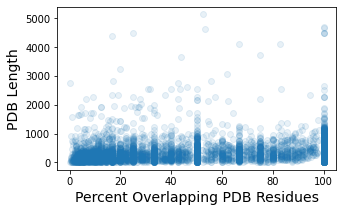

In [23]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(pdb_mapped_filt_df['percent_match'], pdb_mapped_filt_df['len'], alpha=0.1)
ax.set_xlabel("Percent Overlapping PDB Residues", fontsize=14)
ax.set_ylabel("PDB Length", fontsize=14)

## 9. Finalize Sites
---
* Filter duplicates, etc.

In [24]:
sites_mapped_df = list()

for idx,row in tqdm(pdb_mapped_filt_df.iterrows(), total=pdb_mapped_filt_df.shape[0]):
    try:
        _df = pd.read_parquet(
            os.path.join(REF_DIR, "pdb_matches/acc_mapped_sites", "{}.parquet".format(row["proteins"]))).loc[:,[
            "{}_{}_res_i".format(row["PDB"],row["CHAIN"]),
            "{}_{}_res".format(row["PDB"],row["CHAIN"]),
            "{}_{}_res_match".format(row["PDB"],row["CHAIN"])
        ]]

        _df.columns = ['pdb_res_i', 'pdb_res', 'pdb_res_match']
        _df['pdb'] = row["PDB"]
        _df['chain'] = row["CHAIN"]
        sites_mapped_df.append(_df)
    except:
        print("   * Error with {}".format(row['proteins']))
    
sites_mapped_df = pd.concat(sites_mapped_df)

100%|██████████| 6424/6424 [00:51<00:00, 125.35it/s]


In [30]:
# Drop duplicates
sites_mapped_df = sites_mapped_df.reset_index().drop_duplicates().set_index("id")

# Select for matched sites / rank multi sites by position
sites_mapped_df = sites_mapped_df[sites_mapped_df['pdb_res_match']]
sites_mapped_df['pdb_res_i_rank'] = sites_mapped_df.reset_index().groupby("id")['pdb_res_i'].rank("dense").astype(int).values

In [33]:
# Drop duplicate ptmSites (i.e. NP_000005.2_K608k_1_1_608_608 - has two sites mapped from different cohorts)
ptm_comb_filt_pdb_df = ptm_comb_filt_df.reset_index().drop_duplicates(['id','ptmSite']).set_index('id')

# Rank multi-sites by position
ptm_comb_filt_pdb_df['pdb_res_i_rank'] = ptm_comb_filt_pdb_df.reset_index().groupby("id")['acc_res_i'].rank("dense").astype(int).values

# Combine pdb level annotations
ptm_comb_filt_pdb_df = pd.merge(ptm_comb_filt_pdb_df.reset_index(), sites_mapped_df.reset_index(), how='left').set_index('id')
ptm_comb_filt_pdb_df['pdb_res_match'] = ptm_comb_filt_pdb_df['pdb_res_match'].fillna(False)
ptm_comb_filt_pdb_df['pdb_res_match'] = (ptm_comb_filt_pdb_df['pdb_res_match']) & (ptm_comb_filt_pdb_df['pdb_res'] == ptm_comb_filt_pdb_df['acc_res'])

# Only matched sites
ptm_comb_filt_match_pdb_df = ptm_comb_filt_pdb_df[ptm_comb_filt_pdb_df['pdb_res_match']==True].copy()
ptm_comb_filt_match_pdb_df['pdb_res_i'] = ptm_comb_filt_match_pdb_df['pdb_res_i'].astype(int)
ptm_comb_filt_match_pdb_df = ptm_comb_filt_match_pdb_df[ptm_comb_filt_match_pdb_df['uniprot_res_i']!='X']

In [12]:
ptm_comb_filt_df.shape

(174831, 38)

In [11]:
pd.read_csv(os.path.join(REF_DIR, "full_mapped_sites_to_pdbs.tsv"), sep='\t', index_col=0)

,id.description,geneSymbol,protein_mw,accession_number,feature,variableSites,sequence,sequenceVML,ptmSite,Hit_def,...,acc_res_idx,uniprot_res,uniprot_res_i,uniprot_match,pdb_res_i_rank,pdb_res_i,pdb_res,pdb_res_match,pdb,chain
id,,,,,,,,,,,,,,,,,,,,,
NP_001333374.1_S18s_1_1_18_18,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,S18s,"['ELLLPNWQGsGSHGLTIAQR', 'ELLLPNWQGsGSHGLTIAQR']","['ELLLPNWQGS(0.99)GS(0.0)HGLT(0.0)IAQR', 'ELLL...",S18s,sp|Q09666|AHNK_HUMAN Neuroblast differentiatio...,...,17,S,18,True,1,NaN,NaN,False,NaN,NaN
NP_001333374.1_S41s_1_1_41_41,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,S41s,"['DDGVFVQEVTQNsPAAR', 'DDGVFVQEVTQNsPAAR']","['DDGVFVQEVT(0.0)QNS(0.99)PAAR', 'DDGVFVQEVT(0...",S41s,sp|Q09666|AHNK_HUMAN Neuroblast differentiatio...,...,40,S,41,True,1,NaN,NaN,False,NaN,NaN
NP_001333374.1_S93s_1_1_93_93,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,S93s,"['GDRsPEPGQTWTR', 'KGDRsPEPGQTWTR', 'KGDRsPEPG...","['GDRS(0.99)PEPGQT(0.0)WT(0.0)R', 'KGDRS(0.99)...",S93s,sp|Q09666|AHNK_HUMAN Neuroblast differentiatio...,...,92,S,93,True,1,NaN,NaN,False,NaN,NaN
NP_001333374.1_T99t_1_1_99_99,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,T99t,"['SPEPGQtWTR', 'GDRSPEPGQtWTR']","['S(0.0)PEPGQT(0.99)WT(0.0)R', 'GDRS(0.0)PEPGQ...",T99t,sp|Q09666|AHNK_HUMAN Neuroblast differentiatio...,...,98,T,99,True,1,NaN,NaN,False,NaN,NaN
NP_001333374.1_S110s_1_1_110_110,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,S110s,"['EVFSSCSsEVVLSGDDEEYQR', 'EVFSSCSsEVVLSGDDEEY...",['EVFS(0.0)S(0.0)CS(0.0)S(0.99)EVVLS(0.0)GDDEE...,S110s,sp|Q09666|AHNK_HUMAN Neuroblast differentiatio...,...,109,S,110,True,1,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_003585.3_K82kK86k_2_2_82_86,transcription termination factor 2 GN=TTF2,TTF2,130841.0,NP_003585.3,acetylome,K82k K86k,['SkAEGkRWCGSIPWQDPDSK'],['SK(0.99)AEGK(0.99)RWCGSIPWQDPDSK(0.0)'],K86k,sp|Q6CJM4|RAD5_KLULA DNA repair protein RAD5 O...,...,X,NaN,X,False,2,NaN,NaN,False,NaN,NaN
NP_443155.1_K257kK260k_2_2_257_260,SCAN domain-containing protein 3 isoform 1 GN...,ZBED9,153546.1,NP_443155.1,acetylome,K257k K260k,['EVkEAkAKAK'],['EVK(0.99)EAK(0.99)AK(0.0)AK(0.0)'],K257k,sp|Q9H4T2|ZSC16_HUMAN Zinc finger and SCAN dom...,...,X,NaN,X,False,1,NaN,NaN,False,NaN,NaN
NP_443155.1_K257kK260k_2_2_257_260,SCAN domain-containing protein 3 isoform 1 GN...,ZBED9,153546.1,NP_443155.1,acetylome,K257k K260k,['EVkEAkAKAK'],['EVK(0.99)EAK(0.99)AK(0.0)AK(0.0)'],K260k,sp|Q9H4T2|ZSC16_HUMAN Zinc finger and SCAN dom...,...,X,NaN,X,False,2,NaN,NaN,False,NaN,NaN


## 10. Save Files + Summary
---

In [36]:
ptm_comb_filt_pdb_df.to_csv(os.path.join(REF_DIR, "full_mapped_sites_to_pdbs.tsv"), sep='\t')
ptm_comb_filt_match_pdb_df.to_csv(os.path.join(REF_DIR, "mapped_sites_to_pdbs.tsv"), sep='\t')

In [37]:
print(" {} acetylsites mapped.".format(ptm_comb_filt_match_pdb_df.groupby('feature').size()['acetylome']))
print(" {} phosphosites mapped.".format(ptm_comb_filt_match_pdb_df.groupby('feature').size()['phosphoproteome']))
print(" {} unique accession numbers.".format(np.unique(ptm_comb_filt_match_pdb_df['accession_number']).shape[0]))
print(" {} unique uniprots.".format(np.unique(ptm_comb_filt_match_pdb_df['uniprot']).shape[0]))

 13934 acetylsites mapped.
 14367 phosphosites mapped.
 6381 unique accession numbers.
 5077 unique uniprots.


In [38]:
ptm_comb_filt_pdb_df.groupby('uniprot_match').size()

uniprot_match
False     39036
True     127559
dtype: int64

In [39]:
ptm_comb_filt_pdb_df.groupby('pdb_res_match').size()

pdb_res_match
False    138292
True      28303
dtype: int64